# Imports 

In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from matplotlib.pyplot import figure
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from scipy import stats
import seaborn as sns
import powerlaw
from scipy.stats import poisson
from scipy.stats import norm  
from sklearn.model_selection import train_test_split
import math
from random import shuffle
from scipy.stats import norm
from statsmodels.distributions.empirical_distribution import ECDF
import random
from collections import defaultdict
import itertools

C:\Users\Ayan\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Ayan\anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\Ayan\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


# Custom functions

In [4]:
def get_all_indices(mylist, myval):
    
    all_indices = []
    
    for i in range(len(mylist)):
        if mylist[i] == myval:
            all_indices.append(i)
            
    return all_indices

# unipartite positive and negative layers ...k01, k10 are column vectors

def multidegree_entropy_pos_neg(k01, k10, precision=10**(-5), loops=10000):
    n=len(k01)
    t01=np.random.uniform(size=(n,1))
    t10=np.random.uniform(size=(n,1))
    oldt01=np.random.uniform(size=(n,1))
    oldt10=np.random.uniform(size=(n,1))    
    
    for kk in tqdm(range(loops)):
            T01=t01*(t01.transpose())
            T10=t10*(t10.transpose())
            Z=1+ T01 + T10
            
            #p01
            summat=(np.ones((n,1))*t01.transpose())/(Z+(Z==0))
            summat=summat-np.diag(np.diagonal(summat))
            summat=np.sum(summat,axis=1, keepdims=True);
            t01=k01/(summat+(summat==0))
            T01=t01*(t01.transpose())
            
            Z=1+ T01 + T10
    
            #p10
            summat=(np.ones((n,1))*t10.transpose())/(Z+(Z==0))
            summat=summat-np.diag(np.diagonal(summat))
            summat=np.sum(summat,axis=1,keepdims=True)
            t10=k10/(summat+(summat==0))
            
            #print((max(abs((t01>0)*(1-t01/(oldt01+(oldt01==0)))))))
            
            #print(max(abs((t10>0)*(1-t10/(oldt10+(oldt10==0))))))
            
            if np.logical_and((max(abs((t01>0)*(1-t01/(oldt01+(oldt01==0)))))< precision),(max(abs((t10>0)*(1-t10/(oldt10+(oldt10==0)))))<precision)):
                break

            oldt01=t01
            oldt10=t10
            
            
    print("Loops ", kk+1)
    print('Error margin: ', max((max(abs((t01>0)*(1-t01/(oldt01+(oldt01==0)))))),max(abs((t10>0)*(1-t10/(oldt10+(oldt10==0)))))))
    T01=t01*(t01.transpose());
    T10=t10*(t10.transpose());

    Z=1+ T01 + T10;
    
    
    summat01=T01/(Z+(Z==0))
    summat01=summat01-np.diag(np.diagonal(summat01))
    k01cal=np.sum(summat01,axis=1,keepdims=True);  
    
    summat10=T10/(Z+(Z==0))
    summat10=summat10-np.diag(np.diagonal(summat10))
    k10cal=np.sum(summat10,axis=1,keepdims=True)
                    
    pconditional=summat10/(summat10+summat01+(summat10==0))
    
    return (summat01, k01cal, summat10, k10cal, pconditional)   

    return network_data

def run_configuration_model(network_data, precision=10**(-5), loops=10000):

    ## Create train-test split

    train, test = train_test_split(network_data, test_size=0.3)

    train_nodes = list(set(train['node_1']).union(set(train['node_2'])))
    train_nodes_index_map = dict(zip(train_nodes, range(len(train_nodes)))) ## Mapping between training ndoes and indices for selecting from summat matrices

    degree_train_1_0 = []
    degree_train_0_1 = []

    for node in tqdm(train_nodes):
        sub_df = train[(train['node_1'] == node) | (train['node_2'] == node)]
        degree_train_1_0.append(len(sub_df[sub_df['binary_label'] == 1]))
        degree_train_0_1.append(len(sub_df[sub_df['binary_label'] == 0]))
    
    ## Degree ratio distirbution

    degree_ratio_list = [degree_train_1_0[i]/(degree_train_1_0[i] + degree_train_0_1[i]) for i in range(len(train_nodes))]

    figure(figsize=(8, 8),dpi=300)
    #ax = sns.distplot(degree_ratio_list, norm_hist=True, hist_kws=dict(alpha=0.1))
    ax = sns.histplot(degree_ratio_list, stat='density', linewidth=0)
    ax.set(xlim = [0,1], xlabel=r'$\rho$', ylabel='PDF')
    plt.savefig("Varying-fluctuations-degree-ratio.svg", format="svg")
    plt.show()
    
    df = pd.DataFrame()
    df['degree_ratio_list'] = degree_ratio_list
    df.to_csv('Varying-fluctuations-degree-ratio.csv')

    sum_degree =  [a + b for a,b in zip(degree_train_1_0,degree_train_0_1)]
    print('Number of nodes with not positive or negative annotation: ', sum_degree.count(0))

    print('Validating p_bind value from binary labels: ', network_data['binary_label'].tolist().count(1) / len(network_data))

    summat01, k01cal, summat10, k10cal, pconditional = multidegree_entropy_pos_neg(np.array([degree_train_0_1]).T, np.array([degree_train_1_0]).T, precision=precision, loops=loops)

    test_probabilty_predicted_conditioned = []
    test_type_list = []

    ## Average conditional probability
    p10_avg = np.mean(summat10)
    p01_avg = np.mean(summat01)
    average_conditional_probability = p10_avg / (p10_avg + p01_avg)

    for index, row in tqdm(test.iterrows()):      
    
        if row['node_1'] in train_nodes and row['node_2'] in train_nodes:
            mapped_index_in_matrix_node_1 = train_nodes_index_map[row['node_1']]
            mapped_index_in_matrix_node_2 = train_nodes_index_map[row['node_2']]
            p10_conditioned = pconditional[mapped_index_in_matrix_node_1, mapped_index_in_matrix_node_2]
            test_probabilty_predicted_conditioned.append(p10_conditioned)
            test_type_list.append('Transductive')
        
        elif row['node_1'] in train_nodes and row['node_2'] not in train_nodes:
            mapped_index_in_matrix_node_1 = train_nodes_index_map[row['node_1']]
            p10_conditioned = degree_train_1_0[mapped_index_in_matrix_node_1] / (degree_train_0_1[mapped_index_in_matrix_node_1] + degree_train_1_0[mapped_index_in_matrix_node_1] ) ## k_+ / (k_+ + k_-)
            test_probabilty_predicted_conditioned.append(p10_conditioned)
            test_type_list.append('Semi-inductive')
        
        elif row['node_1'] not in train_nodes and row['node_2'] in train_nodes:
            mapped_index_in_matrix_node_2 = train_nodes_index_map[row['node_2']]
            p10_conditioned = degree_train_1_0[mapped_index_in_matrix_node_2] / (degree_train_0_1[mapped_index_in_matrix_node_2] + degree_train_1_0[mapped_index_in_matrix_node_2] ) ## k_+ / (k_+ + k_-)
            test_probabilty_predicted_conditioned.append(p10_conditioned)
            test_type_list.append('Semi-inductive')
        
        else:
            p10_conditioned = average_conditional_probability
            test_probabilty_predicted_conditioned.append(p10_conditioned)
            test_type_list.append('Inductive')
        
    test_predictions = test.copy()
    test_predictions['predicted_probability'] = test_probabilty_predicted_conditioned
    test_predictions['test_type'] = test_type_list

    ## Performance on the test dataset

    print('AUC: ', roc_auc_score(test_predictions['binary_label'].tolist(), test_predictions['predicted_probability'].tolist()))
    print('AUP: ', average_precision_score(test_predictions['binary_label'].tolist(), test_predictions['predicted_probability'].tolist()))

    print('Transductive performance:')

    test_predictions_transductive = test_predictions[test_predictions['test_type'] == 'Transductive']
    print('AUC: ', roc_auc_score(test_predictions_transductive['binary_label'].tolist(), test_predictions_transductive['predicted_probability'].tolist()))
    print('AUP: ', average_precision_score(test_predictions_transductive['binary_label'].tolist(), test_predictions_transductive['predicted_probability'].tolist()))

    figure(figsize=(8, 8),dpi=300)
    #ax = sns.distplot(test_predictions['predicted_probability'].tolist(), norm_hist=True, hist_kws=dict(alpha=0.1))
    #ax = sns.distplot(test_predictions_transductive['predicted_probability'].tolist(), norm_hist=True, hist_kws=dict(alpha=0.1))
    ax = sns.histplot(test_predictions_transductive['predicted_probability'].tolist(), stat='density', linewidth=0)
    ax.set(xlim = [0,1], xlabel='$p^{conditional}$', ylabel='PDF')
    plt.savefig("Varying-fluctuations-pconditional.svg", format="svg")
    plt.show()
    
    df = pd.DataFrame()
    df['pconditional'] = test_predictions_transductive['predicted_probability'].tolist()
    df.to_csv('Varying-fluctuations-pconditional.csv') 
    
    return

def plot_k_Kd_relation_from_node(network_dataOrig): ## Node level 

    nodes = list(set(network_dataOrig['node_1']).union(set(network_dataOrig['node_2'])))
    all_k = []
    all_Kd_mean = []
    all_logKd_mean = []

    for node in tqdm(nodes):
        temp = []
        temp_log = []
        sub_df_1 = network_dataOrig[(network_dataOrig['node_1'] == node)]
        temp = temp + list(sub_df_1['node_1_Kd'])
        temp_log = temp_log + list(np.log(sub_df_1['node_1_Kd']))
        sub_df_2 = network_dataOrig[(network_dataOrig['node_2'] == node)]
        temp = temp + list(sub_df_2['node_2_Kd'])
        temp_log = temp_log + list(np.log(sub_df_2['node_2_Kd']))
        all_k.append(len(network_dataOrig[(network_dataOrig['node_1'] == node) | (network_dataOrig['node_2'] == node)]))
        all_Kd_mean.append(np.mean(temp))
        all_logKd_mean.append(np.mean(np.log(temp)))
    
    unique_deg_vals = set(all_k)   
    unique_deg_vals_Kd_mean = []
    unique_deg_vals_Kd_std = []
    unique_deg_vals_logKd_mean = []
    unique_deg_vals_logKd_std = []
    sample_n = []

    for deg in tqdm(unique_deg_vals):
        all_i = get_all_indices(all_k,deg)
        temp = []
        temp_log = []
        for l in all_i:
            temp.append(all_Kd_mean[l])
            temp_log.append(all_logKd_mean[l])
        unique_deg_vals_Kd_mean.append(np.mean(temp))
        unique_deg_vals_Kd_std.append(np.std(temp))
        unique_deg_vals_logKd_mean.append(np.mean(temp_log))
        unique_deg_vals_logKd_std.append(np.std(temp_log))
        sample_n.append(len(temp_log))
        
    figure(figsize=(12, 12), dpi=300)
    plt.errorbar(list(unique_deg_vals),unique_deg_vals_Kd_mean, yerr=unique_deg_vals_Kd_std, fmt='o', elinewidth=0.5, capsize=0, alpha=0.7)
    plt.xscale('log')
    plt.yscale('log')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig("Varying-fluctuations-k-Kd-Node.svg", format="svg")
    plt.show()
                
    df = pd.DataFrame()
    df['different_protein_annotations'] = list(unique_deg_vals)
    df['unique_Kd_proteins'] = unique_deg_vals_Kd_mean
    df['unique_Kd_proteins_std'] = unique_deg_vals_Kd_std
    df['sample_size'] = sample_n
    df.to_csv('Varying-fluctuations-k-Kd-Node.csv') 
    
    figure(figsize=(12, 12), dpi=300)
    plt.errorbar(list(unique_deg_vals),unique_deg_vals_logKd_mean, yerr=unique_deg_vals_logKd_std, fmt='o', elinewidth=0.5, capsize=0, alpha=0.7)
    plt.xscale('log')
    plt.yscale('log')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig("Varying-fluctuations-k-logKd-Node.svg", format="svg")
    plt.show()
            
    figure(figsize=(12, 12), dpi=300)
    plt.loglog(list(unique_deg_vals), unique_deg_vals_Kd_std, 'o', alpha=0.7)
    #plt.xscale('log')
    #plt.yscale('log')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig("Varying-fluctuations-k-STDKd-Node.svg", format="svg")
    plt.show()
    
    figure(figsize=(12, 12), dpi=300)
    plt.loglog(list(unique_deg_vals), unique_deg_vals_logKd_std, 'o', alpha=0.7)
    #plt.xscale('log')
    #plt.yscale('log')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig("Varying-fluctuations-k-STDlogKd-Node.svg", format="svg")
    plt.show()
    
    return 

def plot_k_Kd_relation_from_edges(network_data): ## Edge level
    
    nodes = list(set(network_data['node_1']).union(set(network_data['node_2'])))

    tk=[]
    tk2K=defaultdict(list)
    tk2logK=defaultdict(list)
    tk2n=defaultdict(list)
    
    for node in tqdm(nodes):
        sub_df = network_data[(network_data['node_1'] == node) | (network_data['node_2'] == node)]
        tk.append(len(sub_df))
        tk2K[len(sub_df)].append(list(sub_df['edge_Kd']))
        tk2logK[len(sub_df)].append(list(np.log(sub_df['edge_Kd'].tolist())))
        tk2n[len(sub_df)].append(len(list(sub_df['edge_Kd'])))
        
    ##################################### Linear #################################
    
    print('Linear Kd Relationship')
    
    vector_mean=[np.mean(list(itertools.chain.from_iterable(tk2K[k]))) for k in tk]
    vector_std=[np.std(list(itertools.chain.from_iterable(tk2K[k]))) for k in tk]

    print('With linear mean: ', stats.spearmanr(tk,vector_mean))
    print('With linear std: ', stats.spearmanr(tk,vector_std))
    
    figure(figsize=(12, 12), dpi=300)
    plt.errorbar(tk,vector_mean, yerr=vector_std, fmt='o', elinewidth=0.5, capsize=0, alpha=0.7)
    plt.xscale('log')
    plt.yscale('log')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig("Varying-fluctuations-k-Kd-errorbar-Edge.svg", format="svg")
    
    df = pd.DataFrame()
    df['k'] = [k for k in tk]
    df['mean_Kd'] = vector_mean
    df['std_Kd'] = vector_std
    df['n_k'] = [sum(tk2n[k]) for k in tk]
    df.to_csv('Varying-fluctuations-k-Kd-Edge.csv') 
    
    figure(figsize=(12, 12), dpi=300)
    plt.loglog(tk, vector_mean, 'o', alpha=0.7)
    #plt.xscale('log')
    #plt.yscale('log')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig("Varying-fluctuations-k-Kd-Edge.svg", format="svg")
    plt.show()
    
    figure(figsize=(12, 12), dpi=300)
    plt.loglog(tk, vector_std, 'o', alpha=0.7)
    #plt.xscale('log')
    #plt.yscale('log')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig("Varying-fluctuations-k-STDKd-Edge.svg", format="svg")
    plt.show()
    
    ##################################### Log ####################################
    
    print('Log Kd Relationship')
    
    vector_mean=[np.mean(list(itertools.chain.from_iterable(tk2logK[k]))) for k in tk]
    vector_std=[np.std(list(itertools.chain.from_iterable(tk2logK[k]))) for k in tk]

    print('With log mean: ', stats.spearmanr(tk,vector_mean))
    print('With log std: ', stats.spearmanr(tk,vector_std))
    
    figure(figsize=(12, 12), dpi=300)
    plt.errorbar(tk,vector_mean, yerr=vector_std, fmt='o', elinewidth=0.5, capsize=0, alpha=0.7)
    plt.xscale('log')
    plt.yscale('log')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig("Varying-fluctuations-k-logKd-errorbar-Edge.svg", format="svg")
    
    df = pd.DataFrame()
    df['k'] = [k for k in tk]
    df['mean_Kd'] = vector_mean
    df['std_Kd'] = vector_std
    df['n_k'] = [sum(tk2n[k]) for k in tk]
    df.to_csv('Varying-fluctuations-k-logKd-Edge.csv') 
    
    figure(figsize=(12, 12), dpi=300)
    plt.scatter(tk, vector_mean, alpha=0.7)
    plt.xscale('log')
    #plt.yscale('log')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig("Varying-fluctuations-k-logKd-Edge.svg", format="svg")
    plt.show()
    
    figure(figsize=(12, 12), dpi=300)
    plt.scatter(tk, vector_std, alpha=0.7)
    #plt.ylim([0,6])
    plt.xscale('log')
    #plt.yscale('log')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig("Varying-fluctuations-k-STDlogKd-Edge.svg", format="svg")
    plt.show()

    return    

def correlated_networks(kvec, dict_association, p_bind=0.16): ## Uses anti-correlation between k and Kd with varying fluctuations 
    avgk=np.mean(kvec)
    ecdfK =ECDF(kvec)
    x=ecdfK.x[1:]
    y=ecdfK.y[1:]
    lm=[dict_association[k][0] for k in x]
    ls=[dict_association[k][1] for k in x]
    MAT=np.array([x, y, poisson.ppf(y, avgk), lm, ls]).T
    MAT[-1,2]=poisson.ppf((MAT.shape[0]-0.5)/MAT.shape[0], avgk)
    
    node2lm={n: lm[n] for n in range(len(lm)) }
    node2ls={n: ls[n] for n in range(len(ls)) }
    
    # fat-tailed network
    Goriginaldegree= nx.configuration_model(MAT[:,0].astype(int), create_using=nx.Graph(), seed=None)
    Goriginaldegree.remove_edges_from(nx.selfloop_edges(Goriginaldegree))
    nx.set_node_attributes(Goriginaldegree, node2lm, "m")
    nx.set_node_attributes(Goriginaldegree, node2ls, "s")
    
    # poisson network
    Gpoisson= nx.configuration_model(MAT[:,2].astype(int),create_using=nx.Graph(), seed=None)
    Gpoisson.remove_edges_from(nx.selfloop_edges(Gpoisson))    
    nx.set_node_attributes(Gpoisson, node2lm, "m")
    nx.set_node_attributes(Gpoisson, node2ls, "s")  
    
    node_list_1 = []
    node_list_2 = []
    node_deg_list_1 = []
    node_deg_list_2 = []
    node_Kd_list_1 = []
    node_Kd_list_2 = []
    
    for edge in tqdm(list(Goriginaldegree.edges())):
        node_list_1.append(edge[0])
        node_list_2.append(edge[1])
        node_deg_list_1.append(Goriginaldegree.degree(edge[0]))
        node_deg_list_2.append(Goriginaldegree.degree(edge[1]))
        node_Kd_list_1.append(np.exp(norm.rvs(loc=Goriginaldegree.nodes[edge[0]]['m'], scale=Goriginaldegree.nodes[edge[0]]['s'])))
        node_Kd_list_2.append(np.exp(norm.rvs(loc=Goriginaldegree.nodes[edge[1]]['m'], scale=Goriginaldegree.nodes[edge[1]]['s'])))

    
    network_dataOrig = pd.DataFrame()
    network_dataOrig['node_1'] = node_list_1
    network_dataOrig['node_2'] = node_list_2
    network_dataOrig['node_1_Kd'] = node_Kd_list_1
    network_dataOrig['node_2_Kd'] = node_Kd_list_2
    network_dataOrig['edge_Kd'] = [np.sqrt(a*b) for a,b in zip(node_Kd_list_1,node_Kd_list_2)]
    
    
    #############################################################################################################
    ##################################### Plot k and kd relations node level ####################################
    plot_k_Kd_relation_from_node(network_dataOrig)
    #############################################################################################################

    node_list_1 = []
    node_list_2 = []
    node_Kd_list_1 = []
    node_Kd_list_2 = []
    
    for edge in tqdm(list(Gpoisson.edges())):
        node_list_1.append(edge[0])
        node_list_2.append(edge[1])
        node_Kd_list_1.append(np.exp(norm.rvs(loc=Gpoisson.nodes[edge[0]]['m'], scale=Gpoisson.nodes[edge[0]]['s'])))
        node_Kd_list_2.append(np.exp(norm.rvs(loc=Gpoisson.nodes[edge[1]]['m'], scale=Gpoisson.nodes[edge[1]]['s'])))

    
    network_dataPois = pd.DataFrame()
    network_dataPois['node_1'] = node_list_1
    network_dataPois['node_2'] = node_list_2
    network_dataPois['node_1_Kd'] = node_Kd_list_1
    network_dataPois['node_2_Kd'] = node_Kd_list_2
    network_dataPois['edge_Kd'] = [np.sqrt(a*b) for a,b in zip(node_Kd_list_1,node_Kd_list_2)]
    
    
    Kd_for_edges = network_dataOrig['edge_Kd'].tolist()
    threshold = np.exp(norm.ppf(p_bind, loc=np.mean(np.log(Kd_for_edges)), scale=np.std(np.log(Kd_for_edges))))
    print('Threshold Fat-tailed: ', threshold) ## in nM
    binary_labels = [1 if x < threshold else 0 for x in Kd_for_edges]
    network_dataOrig['binary_label'] = binary_labels
    
    Kd_for_edges = network_dataPois['edge_Kd'].tolist()
    threshold = np.exp(norm.ppf(p_bind, loc=np.mean(np.log(Kd_for_edges)), scale=np.std(np.log(Kd_for_edges))))
    print('Threshold Poisson: ', threshold) ## in nM
    binary_labels = [1 if x < threshold else 0 for x in Kd_for_edges]
    network_dataPois['binary_label'] = binary_labels  
    
    return   Goriginaldegree, Gpoisson, network_dataOrig, network_dataPois

def remove_zeros_distribution(x):

    return [i for i in x if i != 0]

def log_binning_distribution(x_i, B = 20): 
    
    x_i = remove_zeros_distribution(x_i)

    b_1 = min(x_i)
    b_Bp1 = max(x_i)
    q_1 = np.log(b_1)
    q_Bp1 = np.log(b_Bp1)
    D_q = q_Bp1 - q_1
    L_q = D_q / B

    q_list = []
    b_list = []

    for i in range(B):
        j = i + 1
        q_list.append(q_1 + (j-1)*L_q)
        b_list.append(np.exp(q_1 + (j-1)*L_q))
   
    binned_x_i = []
    density_list = []

    for i in range(len(b_list)-1):
        bin_low = b_list[i]
        bin_high = b_list[i+1]
        count_bin = 0
        for j in range(len(x_i)):
            if x_i[j] >= bin_low and x_i[j] < bin_high:
                count_bin = count_bin + 1
                
        if count_bin > 0:
            density_bin = count_bin / (len(x_i)*(bin_high-bin_low))
            density_list.append(density_bin)
            binned_x_i.append(bin_low)
        else:
            continue 
            
    return binned_x_i, density_list

def remove_correlation_run_configuration_model(network_data, precision=10**(-5), loops=10000):
    
    c = list(zip(network_data['edge_Kd'].tolist(), network_data['binary_label'].tolist())) 
    random.shuffle(c)
    shuffled_edge_Kd, shuffled_binary_label = zip(*c) ## Shuffle the node Kd values
    
    network_data_shuffled = network_data.copy()
    network_data_shuffled['edge_Kd'] = shuffled_edge_Kd
    network_data_shuffled['binary_label'] = shuffled_binary_label
    
    nodes = list(set(network_data_shuffled['node_1']).union(set(network_data_shuffled['node_2'])))

    K_from_copula_list = []
    Kd_from_copula_list = []

    for node in tqdm(nodes):
        sub_df = network_data_shuffled[(network_data_shuffled['node_1'] == node) | (network_data_shuffled['node_2'] == node)]
        K_from_copula_list.append(len(sub_df))
        Kd_from_copula_list.append(np.mean(sub_df['edge_Kd'].tolist()))

    different_target_annotations_copula = list(set(K_from_copula_list))
    unique_Kd_targets_copula = []

    for unique_ann in tqdm(different_target_annotations_copula):
    
        all_Kd_list = []    
        all_indices = get_all_indices(K_from_copula_list,unique_ann)
    
        for j in all_indices:
            all_Kd_list.append(Kd_from_copula_list[j])
        
        unique_Kd_targets_copula.append(np.mean(all_Kd_list))
        
    print('Correlation between k and <Kd>: ', stats.spearmanr(different_target_annotations_copula,unique_Kd_targets_copula))
    
    figure(figsize=(8, 8),dpi=300)
    ax = sns.scatterplot(different_target_annotations_copula,unique_Kd_targets_copula)
    ax.set(title='After removing correlation',xscale='log',yscale='log',xlabel='$k$',ylabel='Kd')
    plt.show()

    figure(figsize=(8, 8),dpi=300)
    binned_deg_ann, binned_ki_ann = log_binning_distribution(K_from_copula_list,B = 20)
    ax = sns.scatterplot(binned_deg_ann, binned_ki_ann)
    ax.set(title='After removing correlation',xscale='log',yscale='log',xlabel='$k$',ylabel='PDF')
    plt.show()
    
    run_configuration_model(network_data_shuffled, precision=precision, loops=loops)
    
    return network_data_shuffled


# Loading and analysing BindingDB

b'Skipping line 896772: expected 193 fields, saw 205\nSkipping line 896798: expected 193 fields, saw 205\n'
b'Skipping line 929491: expected 193 fields, saw 205\n'
b'Skipping line 952161: expected 193 fields, saw 265\n'
b'Skipping line 1355895: expected 193 fields, saw 241\n'
b'Skipping line 1469800: expected 193 fields, saw 241\nSkipping line 1469801: expected 193 fields, saw 241\nSkipping line 1469802: expected 193 fields, saw 241\nSkipping line 1469803: expected 193 fields, saw 241\nSkipping line 1469804: expected 193 fields, saw 241\nSkipping line 1469805: expected 193 fields, saw 241\nSkipping line 1469806: expected 193 fields, saw 241\nSkipping line 1469807: expected 193 fields, saw 241\nSkipping line 1469808: expected 193 fields, saw 241\n'
b'Skipping line 1483073: expected 193 fields, saw 205\n'
b'Skipping line 1502296: expected 193 fields, saw 241\nSkipping line 1502297: expected 193 fields, saw 241\nSkipping line 1502298: expected 193 fields, saw 241\nSkipping line 1502299: e

There are 70746 drug target pairs.


100%|█████████████████████████████████████████████████████████████████████████████| 1507/1507 [00:08<00:00, 169.32it/s]


Average annotations for proteins:  46.94492368944924
Mean Log  7.1043771550585095
Std Log  3.333684955402517


100%|██████████████████████████████████████████████████████████████████████████████| 1507/1507 [00:16<00:00, 92.56it/s]
C:\Users\Ayan\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Ayan\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Ayan\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please 

Number of proteins/nodes:  1507


  0%|                                                                                          | 0/172 [00:00<?, ?it/s]


NameError: name 'get_all_indices' is not defined

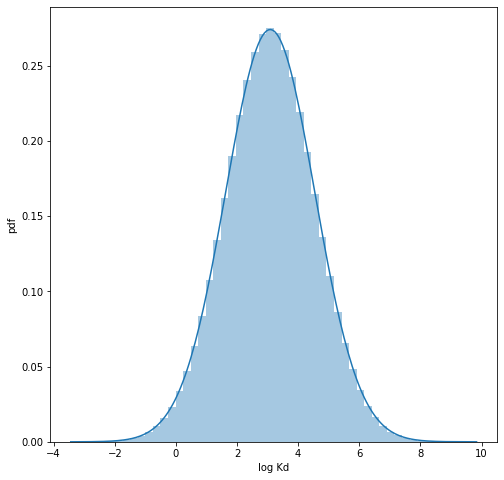

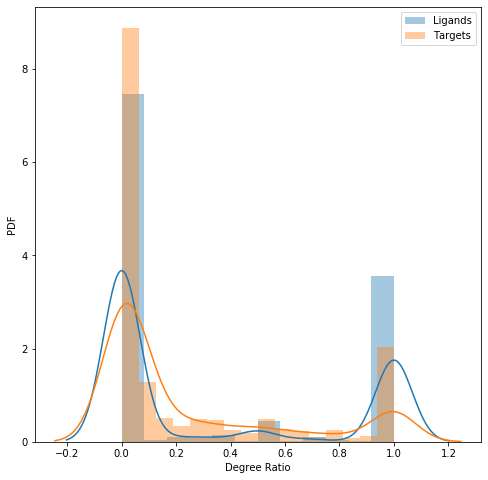

In [2]:
df = pd.read_csv('../../BindingDB_All.tsv', sep = '\t', error_bad_lines=False)
df = df[df['Number of Protein Chains in Target (>1 implies a multichain complex)'] == 1.0]
df = df[df['Ligand SMILES'].notnull()]

idx_str = 'Kd (nM)'

df_want = df[df[idx_str].notnull()]
df_want = df_want[['BindingDB Reactant_set_id', 'Ligand InChI', 'Ligand SMILES',\
                    'PubChem CID', 'UniProt (SwissProt) Primary ID of Target Chain',\
                    'BindingDB Target Chain  Sequence', idx_str]]

df_want.rename(columns={'BindingDB Reactant_set_id':'ID', 'Ligand SMILES':'SMILES',\
                        'Ligand InChI':'InChI', 'PubChem CID':'PubChem_ID',
                        'UniProt (SwissProt) Primary ID of Target Chain':'UniProt_ID',
                        'BindingDB Target Chain  Sequence': 'Target Sequence',
                            idx_str: 'Label'}, inplace=True)

df_want['Label'] = df_want['Label'].str.replace('>', '')
df_want['Label'] = df_want['Label'].str.replace('<', '')
df_want['Label'] = df_want['Label'].astype(float)

# have at least uniprot or pubchem ID
df_want = df_want[df_want.PubChem_ID.notnull() | df_want.UniProt_ID.notnull()]
df_want = df_want[df_want.InChI.notnull()]

df_want = df_want[(df_want.Label <= 10000000.0) & (df_want.Label != 0)]
#remove zeros
df_want=df_want[df_want['Label']>0]
print('There are ' + str(len(df_want)) + ' drug target pairs.')

df_want_Kd = df_want[['SMILES','Target Sequence','Label']]

threshold = 30 ## DeepPurpose threshold in nM

df_want_Kd_binary = df_want_Kd.copy()
df_want_Kd_binary['Label'] = [1 if x < threshold else 0 for x in tqdm(df_want_Kd['Label'].tolist())]

ligands = list(set(df_want_Kd_binary['SMILES'].tolist()))
targets = list(set(df_want_Kd_binary['Target Sequence'].tolist()))

target_annotations_bindingDB = []

for prot in tqdm(targets):
    sub_df = df_want_Kd_binary[df_want_Kd_binary['Target Sequence'] == prot]
    target_annotations_bindingDB.append(len(sub_df))
    
print('Average annotations for proteins: ', np.mean(target_annotations_bindingDB))

p_original=df_want_Kd_binary['Label'].mean()

df_want_Kd_binary['Constant']=df_want_Kd['Label']
df_want_Kd_binary['Constant_log']=df_want_Kd_binary['Constant'].apply(np.log)
meanlog_constant=df_want_Kd_binary['Constant_log'].mean()
stdlog_constant=df_want_Kd_binary['Constant_log'].std()
df_want_Kd_binary=df_want_Kd_binary.sort_values(by=['Constant'])
print('Mean Log ', df_want_Kd_binary['Constant_log'].mean())
print('Std Log ', df_want_Kd_binary['Constant_log'].std())

ecdfkr =ECDF(df_want_Kd_binary['Constant_log'])
MAT=np.array([ecdfkr.x, ecdfkr.y, norm.ppf(ecdfkr.y, loc=meanlog_constant, scale=stdlog_constant)]).T
MAT=MAT[1:,:]
MAT[-1,2]=norm.ppf((MAT.shape[0]-0.5)/MAT.shape[0], loc=meanlog_constant, scale=stdlog_constant)
df_want_Kd_binary['Constant_lognormal']=MAT[:,2]
df_want_Kd_binary['Constant_transformed']=np.exp(df_want_Kd_binary['Constant_lognormal'])

Tlog=max(df_want_Kd_binary['Constant_lognormal'][df_want_Kd_binary['Label']==1])
df_want_Kd_binary['Labelcheck']=[1 if x < Tlog else 0 for x in tqdm(df_want_Kd_binary['Constant_lognormal'].tolist())]

#tomonitor='Label'
tomonitor='Labelcheck'

#selectconstant='Constant'
selectconstant='Constant_transformed'


dictchem_kplus={}
dictchem_kminus={}
for chem in tqdm(ligands):
    dictchem_kplus[chem]=sum(df_want_Kd_binary[tomonitor][df_want_Kd_binary['SMILES']==chem]==1)
    dictchem_kminus[chem]=sum(df_want_Kd_binary[tomonitor][df_want_Kd_binary['SMILES']==chem]==0)
    
dictchem_k={chem:(dictchem_kplus[chem]+dictchem_kminus[chem]) for chem in ligands}
dictchem_ratio={chem:dictchem_kplus[chem]/dictchem_k[chem] for chem in ligands}

dicttarget_kplus={}
dicttarget_kminus={}
for t in tqdm(targets):
    dicttarget_kplus[t]=sum(df_want_Kd_binary[tomonitor][df_want_Kd_binary['Target Sequence']==t]==1)
    dicttarget_kminus[t]=sum(df_want_Kd_binary[tomonitor][df_want_Kd_binary['Target Sequence']==t]==0)
    
dicttarget_k={t:(dicttarget_kplus[t]+dicttarget_kminus[t]) for t in targets}
dicttarget_ratio={t:dicttarget_kplus[t]/dicttarget_k[t] for t in targets}

df_want_Kd_binary['k_l']=[dictchem_k[c] for c in df_want_Kd_binary['SMILES']]
df_want_Kd_binary['k_t']=[dicttarget_k[t] for t in df_want_Kd_binary['Target Sequence']]

kd_list = list(df_want_Kd_binary[selectconstant])
figure(figsize=(8, 8))
ax = sns.distplot(np.log10(kd_list), norm_hist=True)
ax.set(xlabel='log Kd', ylabel='pdf')

figure(figsize=(8, 8))
sns.distplot(list(dictchem_ratio.values()), label='Ligands')
sns.distplot(list(dicttarget_ratio.values()), label='Targets')
plt.legend()
plt.xlabel('Degree Ratio')
plt.ylabel('PDF')


# log space
selectconstant_log='Constant_log'
print('Number of proteins/nodes: ', len(targets))

target_annotations = []
target_all_Kd = []

## Node level computation over Kd ## 

for prot in tqdm(targets):
    sub_df = df_want_Kd_binary[df_want_Kd_binary['Target Sequence'] == prot]
    target_annotations.append(len(sub_df))
    target_all_Kd.append([np.mean(sub_df[selectconstant_log].tolist())])
    
different_target_annotations = sorted(list(set(target_annotations)))
unique_Kd_targets = []
unique_std_Kd_targets = []

for unique_ann in tqdm(different_target_annotations):
    
    all_Kd_list = []    
    all_indices = get_all_indices(target_annotations,unique_ann)
    
    for j in all_indices:
        all_Kd_list = all_Kd_list + target_all_Kd[j]
        
    unique_Kd_targets.append(np.mean(all_Kd_list))
    unique_std_Kd_targets.append(np.std(all_Kd_list))

In [6]:
selectconstant_log='Constant_log'
print('Number of proteins/nodes: ', len(targets))

target_annotations = []
target_all_Kd = []

## Node level computation over Kd ## 

for prot in tqdm(targets):
    sub_df = df_want_Kd_binary[df_want_Kd_binary['Target Sequence'] == prot]
    target_annotations.append(len(sub_df))
    target_all_Kd.append([np.mean(sub_df[selectconstant_log].tolist())])
    
different_target_annotations = sorted(list(set(target_annotations)))
unique_Kd_targets = []
unique_std_Kd_targets = []

for unique_ann in tqdm(different_target_annotations):
    
    all_Kd_list = []    
    all_indices = get_all_indices(target_annotations,unique_ann)
    
    for j in all_indices:
        all_Kd_list = all_Kd_list + target_all_Kd[j]
        
    unique_Kd_targets.append(np.mean(all_Kd_list))
    unique_std_Kd_targets.append(np.std(all_Kd_list))

Number of proteins/nodes:  1507


100%|██████████████████████████████████████████████████████████████████████████████| 172/172 [00:00<00:00, 7478.49it/s]


In [7]:
dict_association={k: (m,s) for (k, m,s) in zip(different_target_annotations, unique_Kd_targets, unique_std_Kd_targets)}

# Create networks

100%|██████████████████████████████████████████████████████████████████████████████| 165/165 [00:00<00:00, 6111.34it/s]


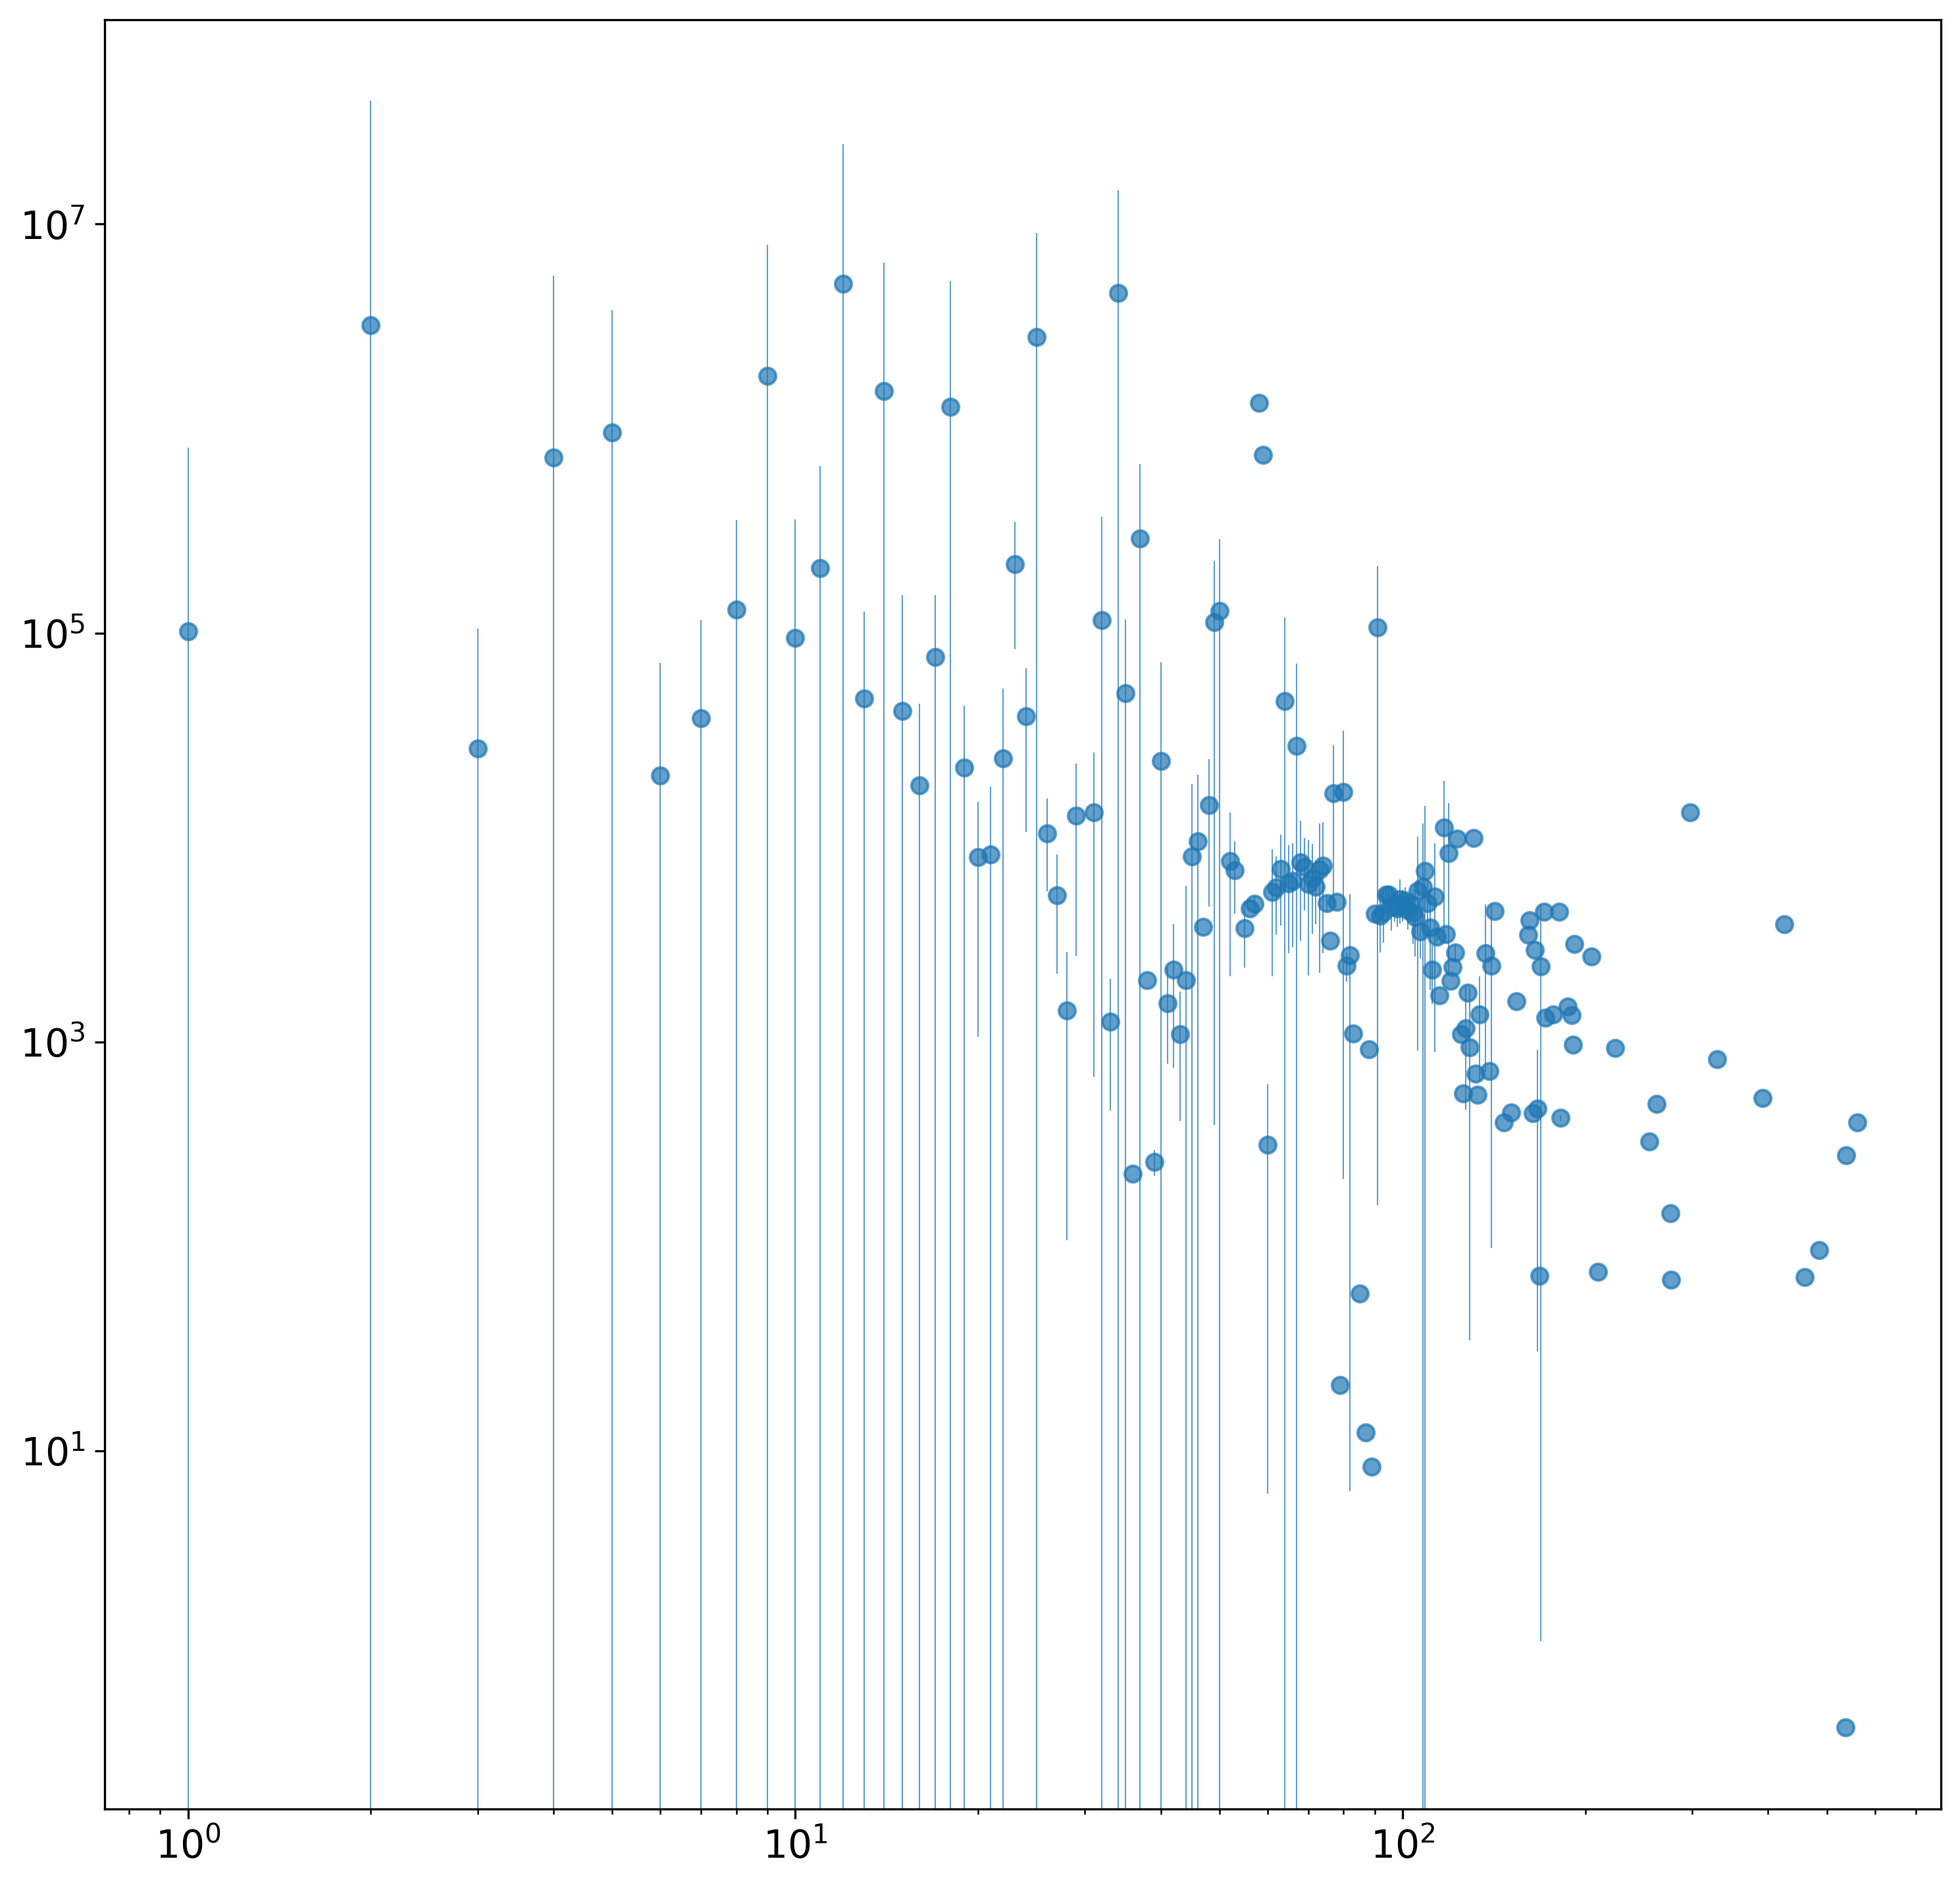

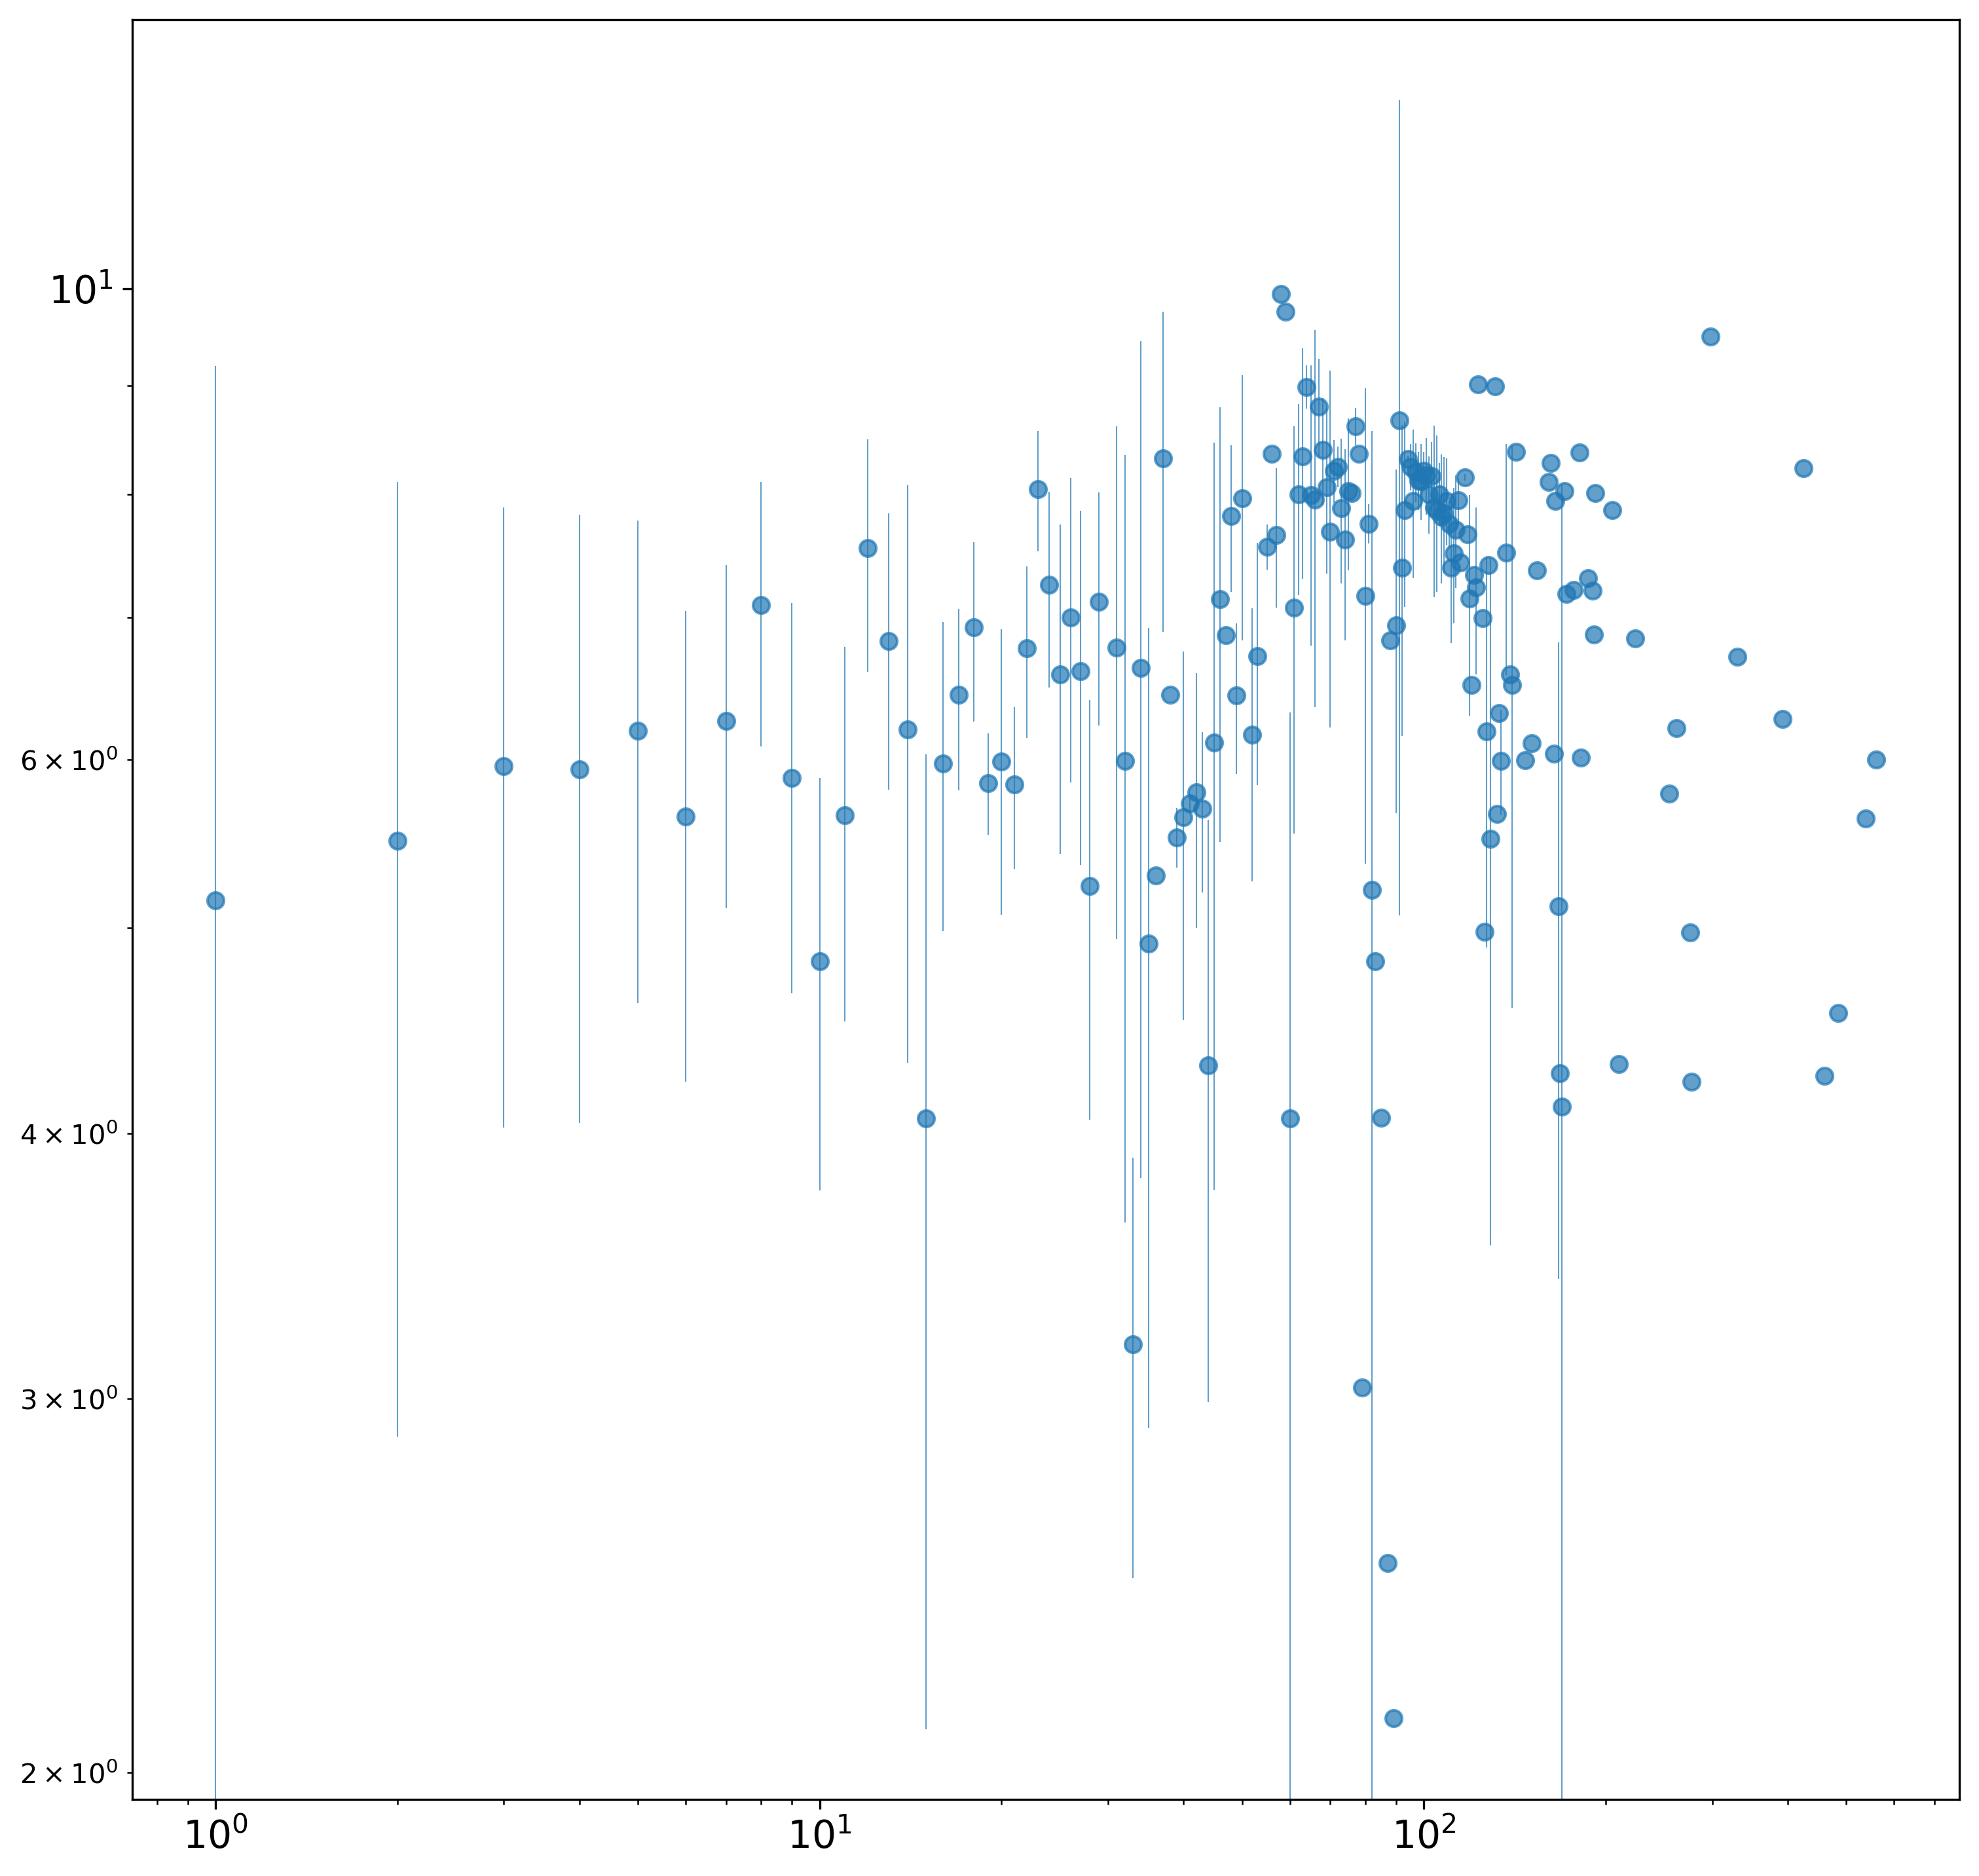

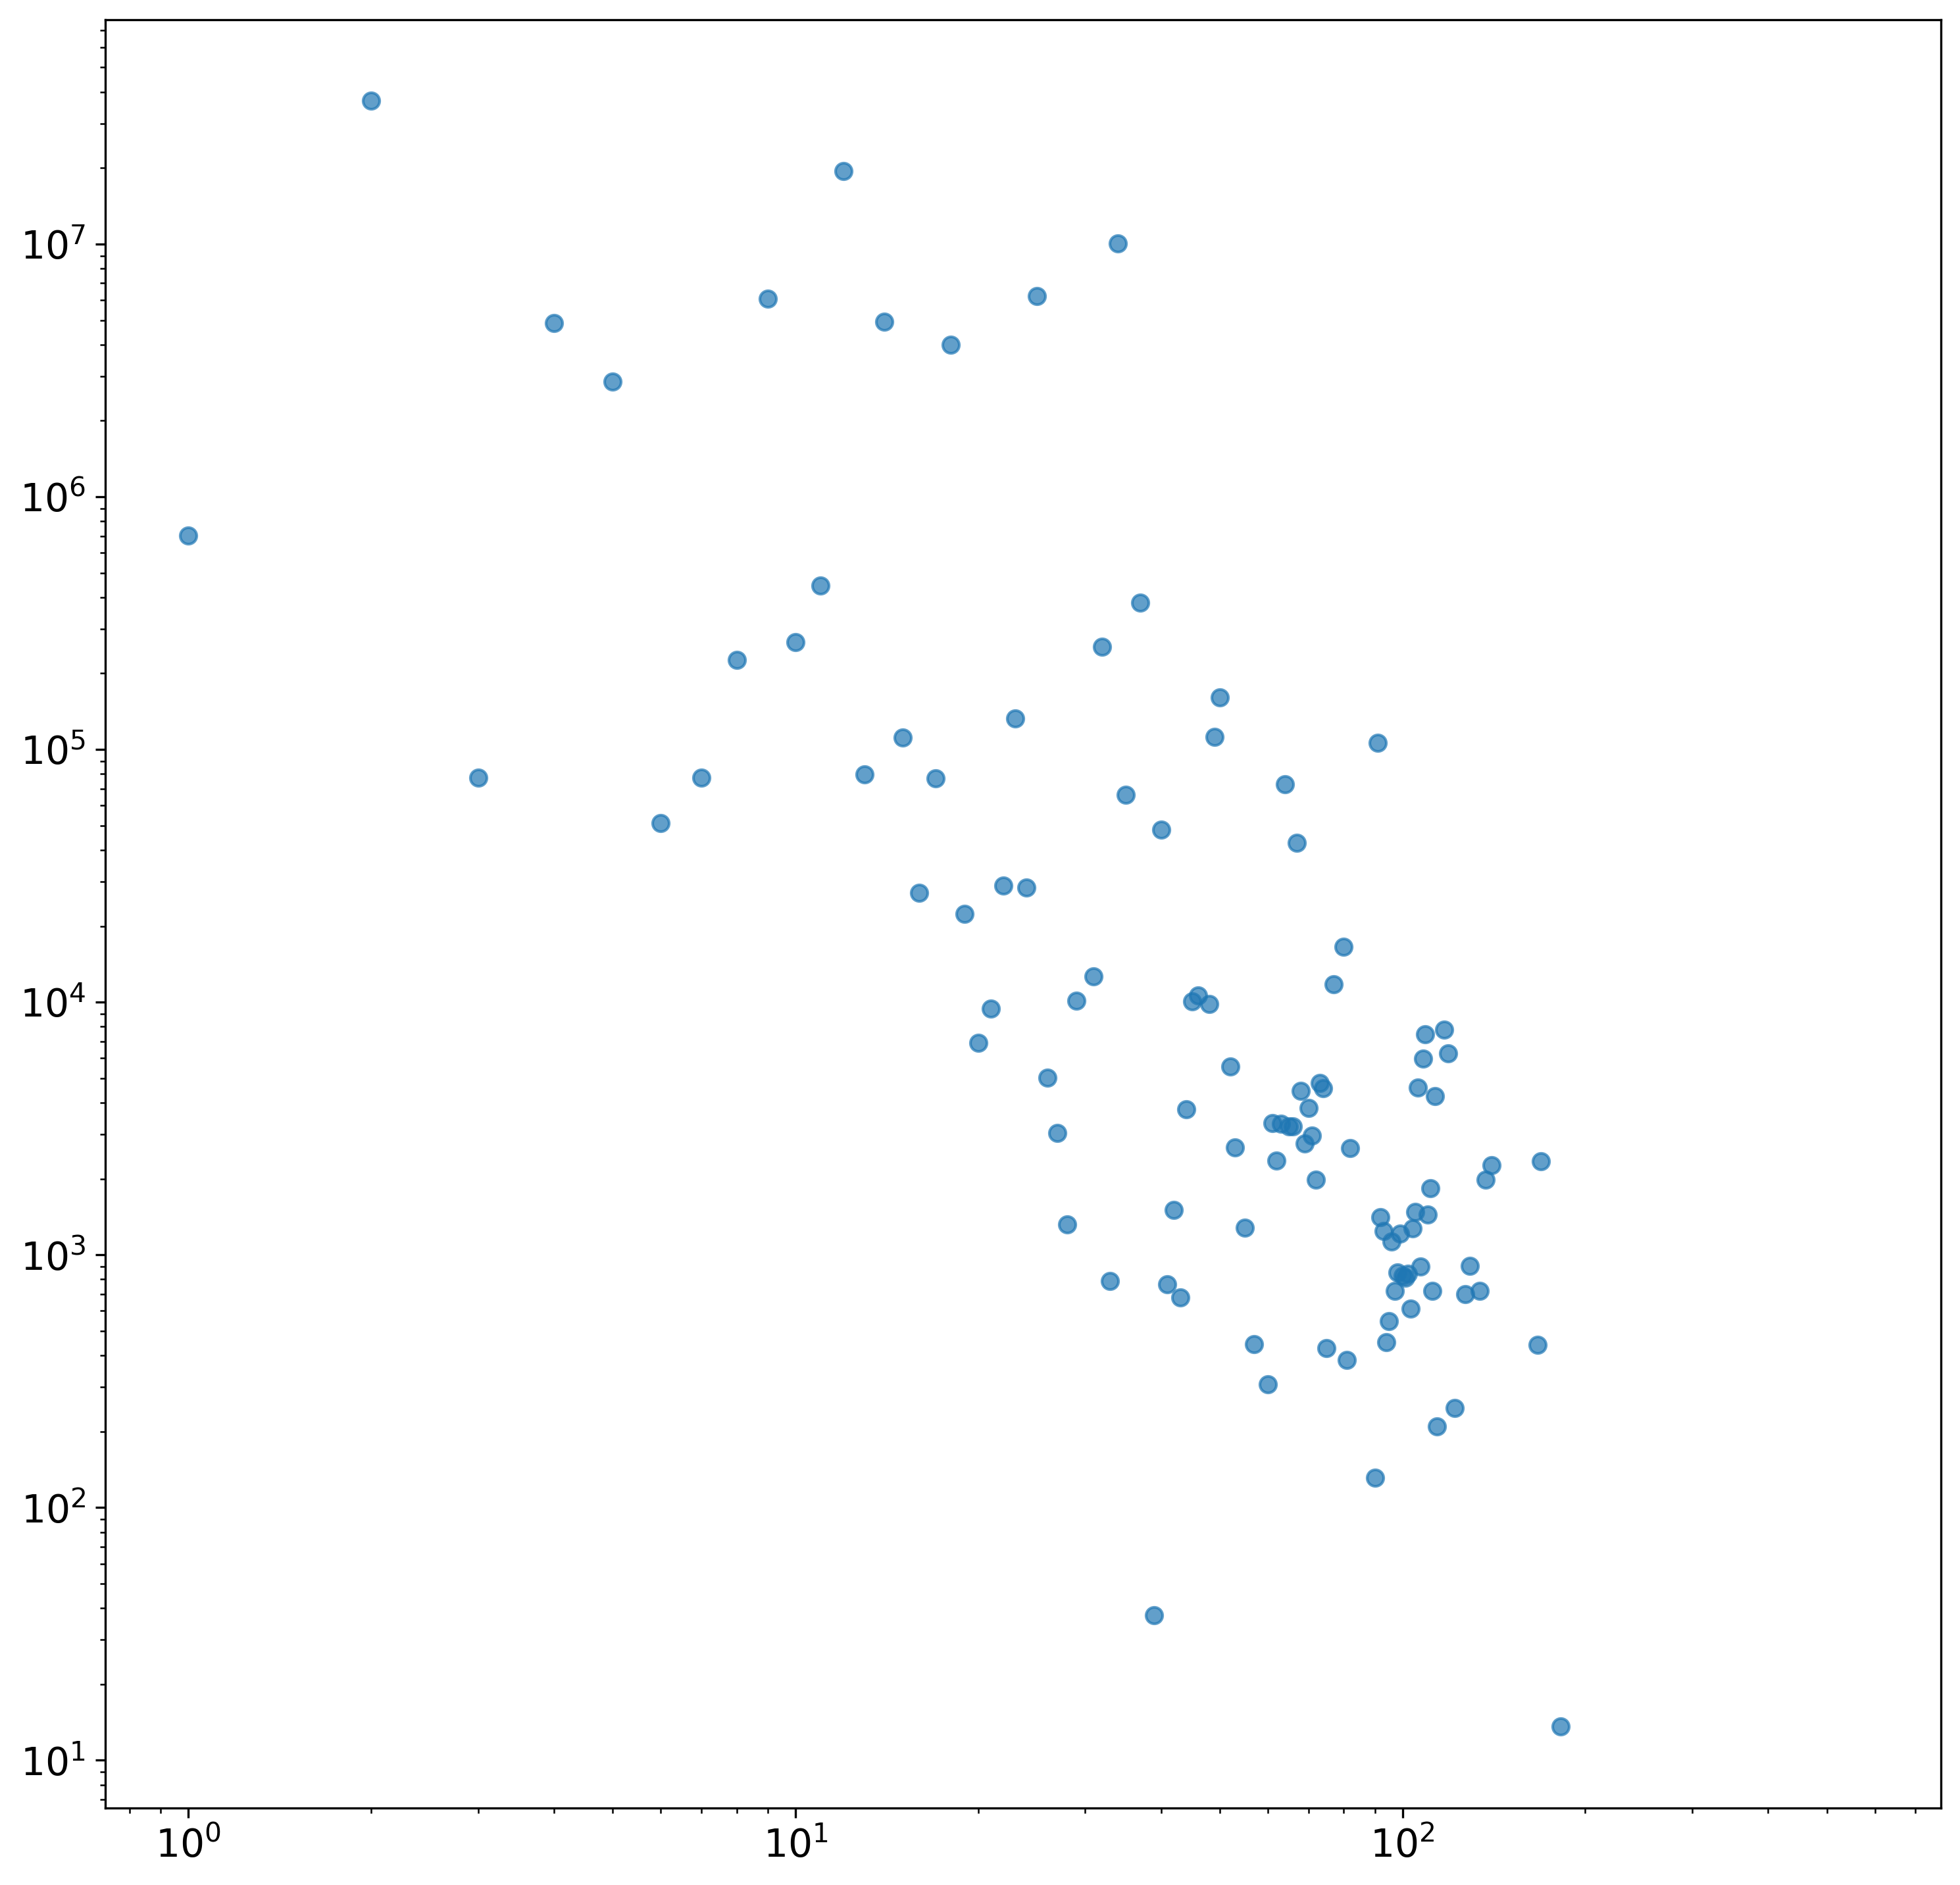

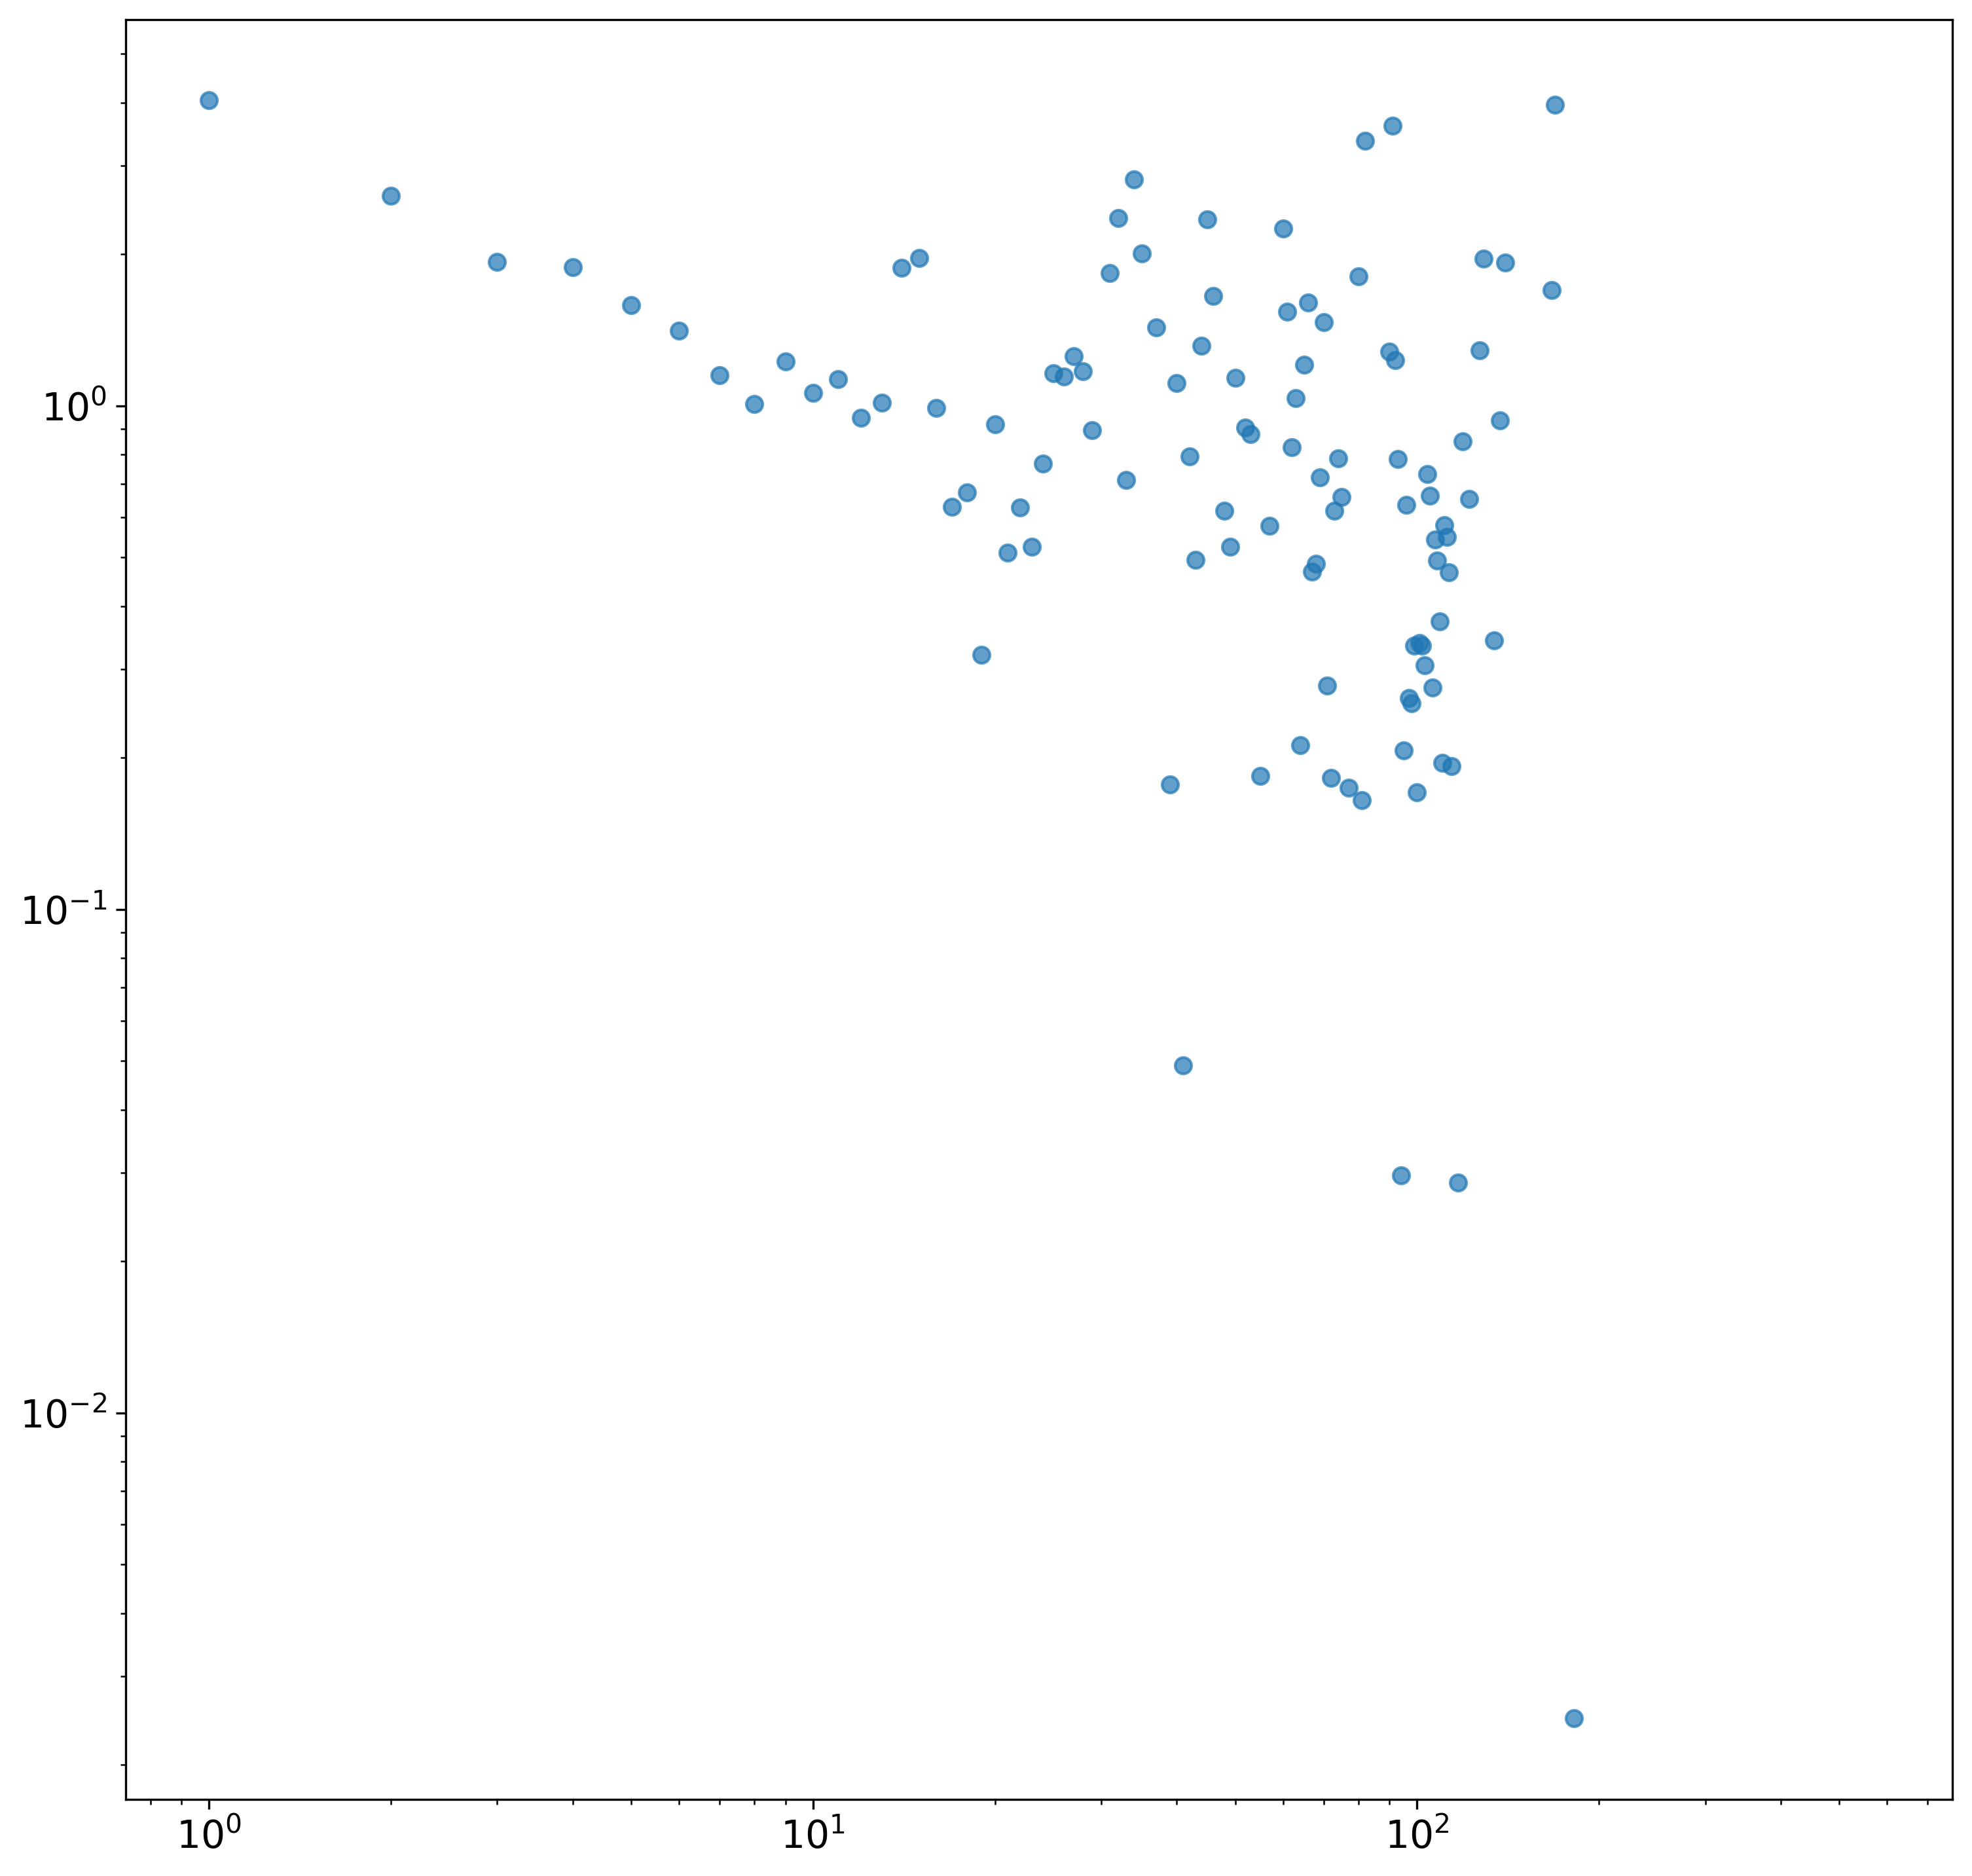

100%|█████████████████████████████████████████████████████████████████████████| 34778/34778 [00:02<00:00, 13462.68it/s]


Threshold Fat-tailed:  315.9284367974057
Threshold Poisson:  65.77878359301036


In [8]:
kvec=sorted(target_annotations)
Goriginaldegree, Gpoisson, network_dataOrig, network_dataPois = correlated_networks(kvec, dict_association,  p_bind=p_original)

100%|████████████████████████████████████████████████████████████████████████████| 1507/1507 [00:01<00:00, 1264.26it/s]


Linear Kd Relationship
With linear mean:  SpearmanrResult(correlation=-0.4180402811155733, pvalue=8.281417977667092e-65)
With linear std:  SpearmanrResult(correlation=-0.49629601614766233, pvalue=1.6000840306712142e-94)


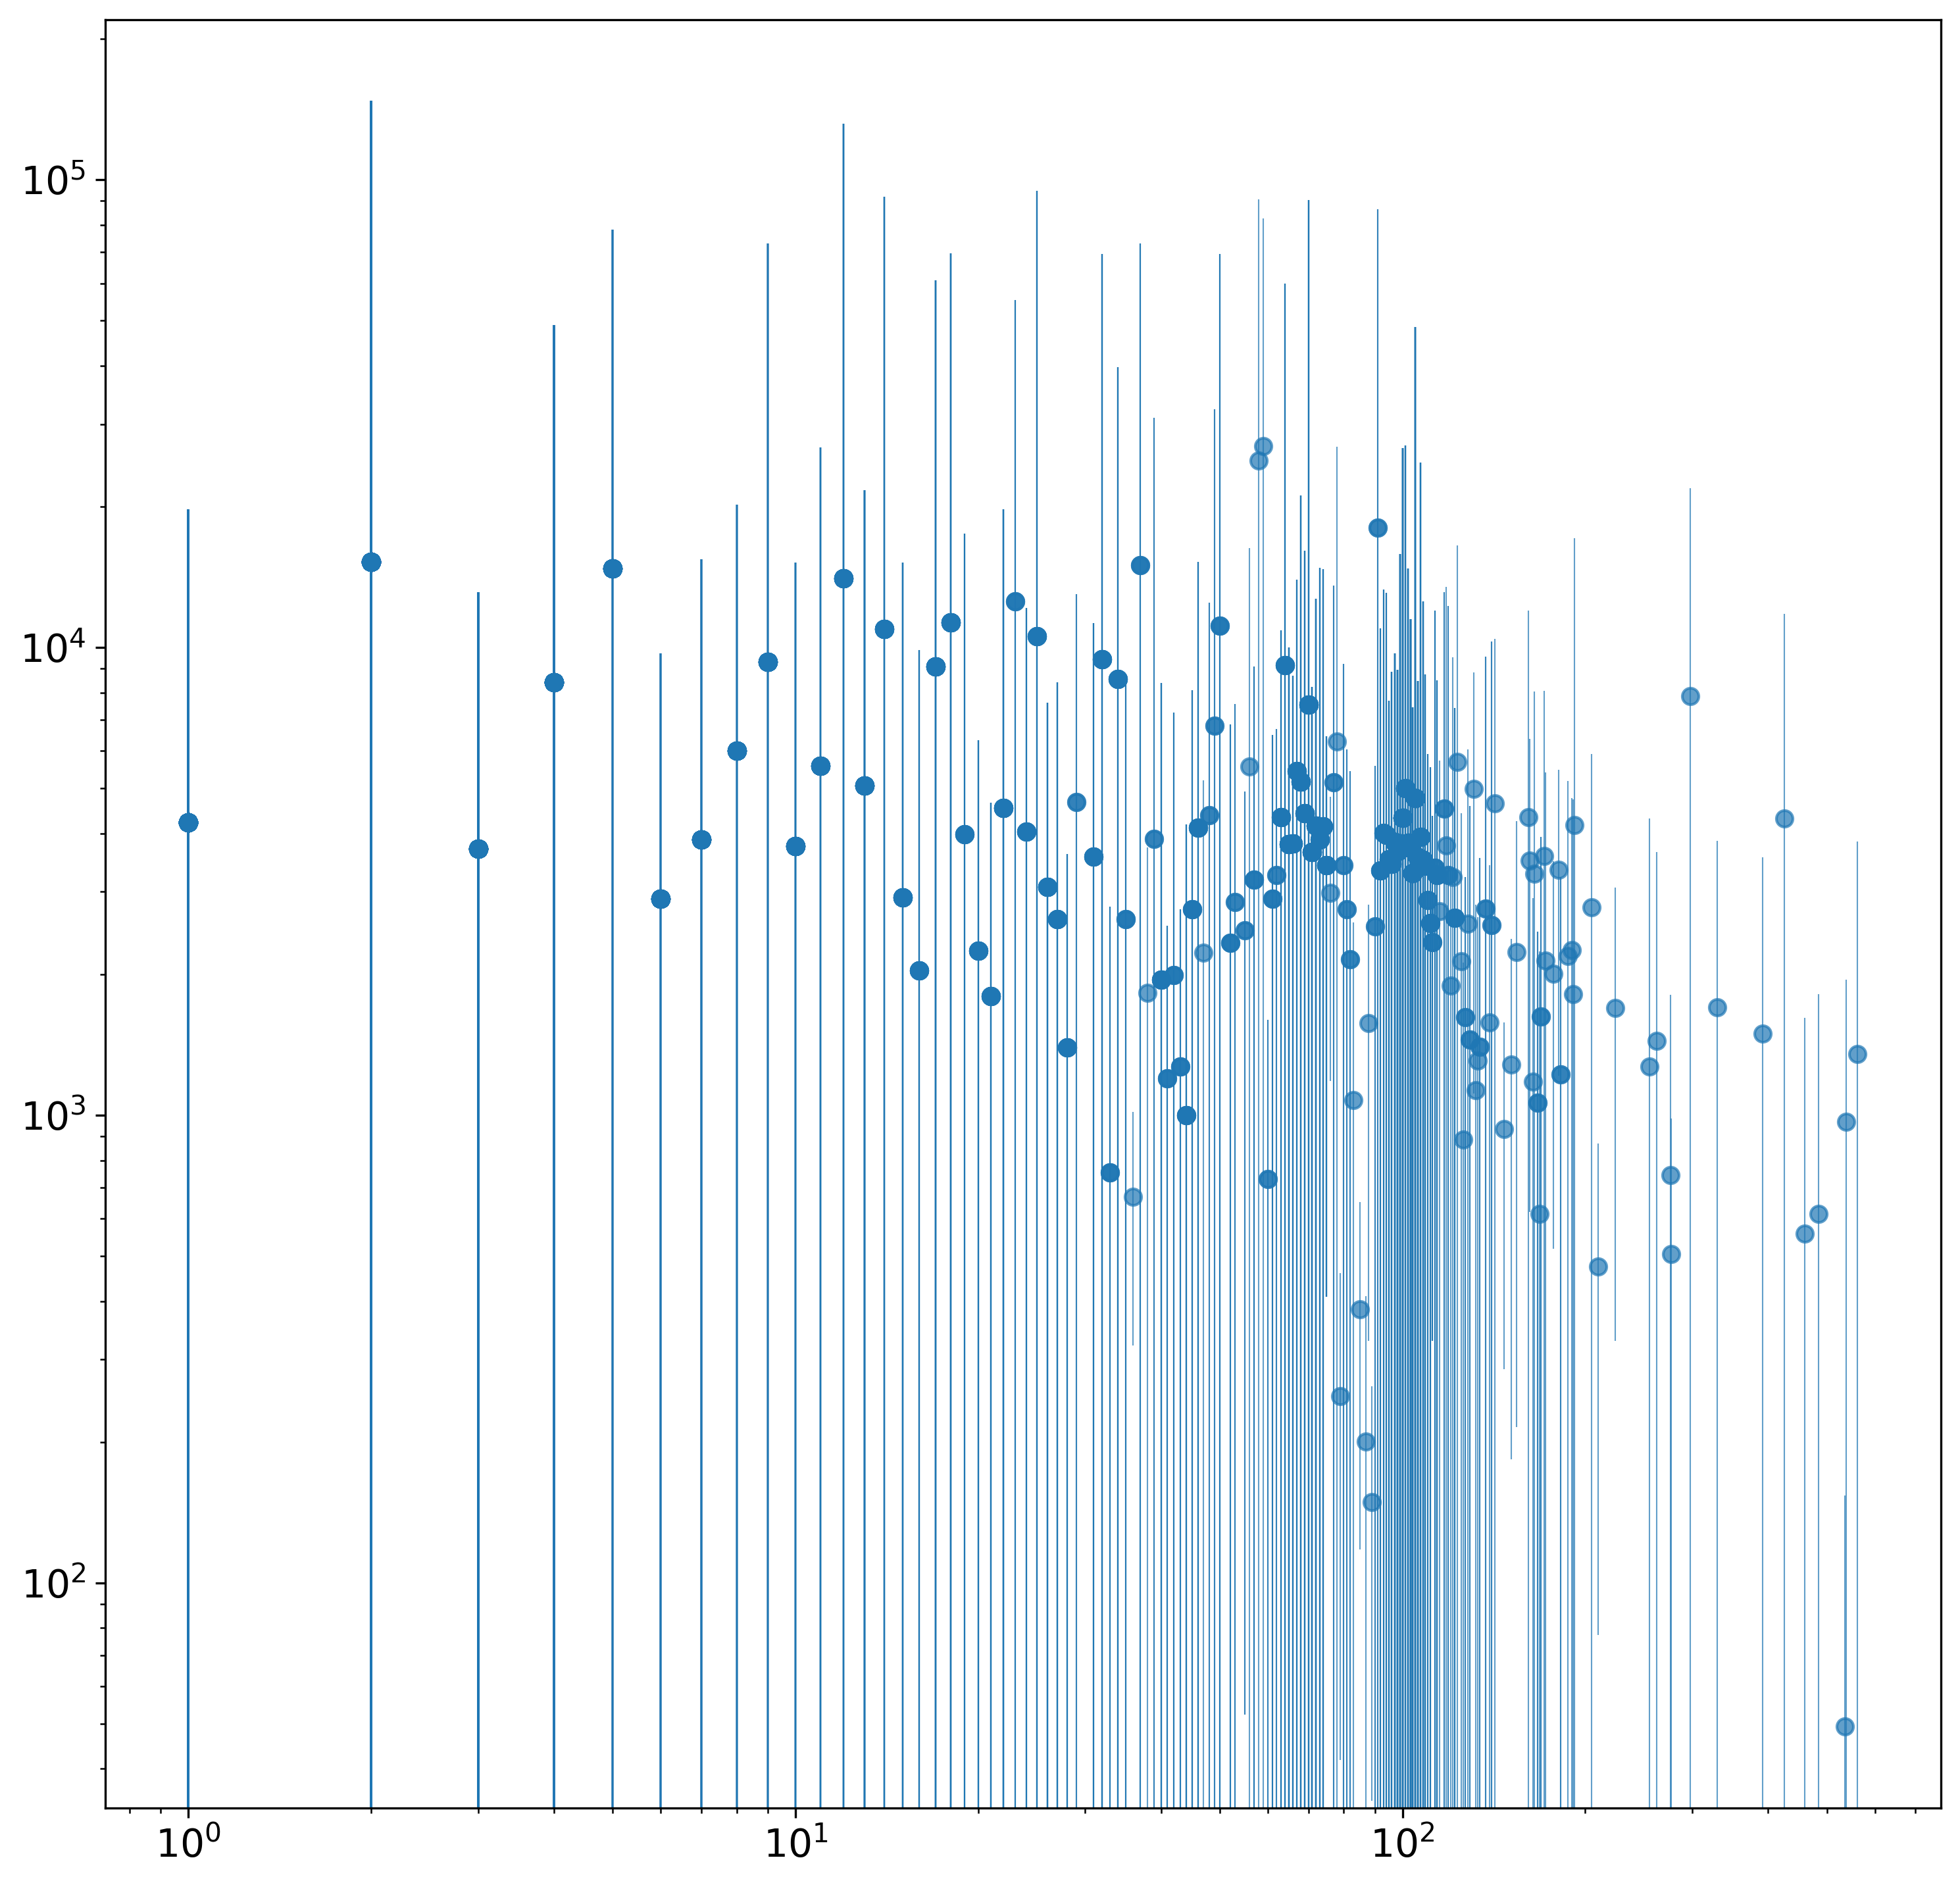

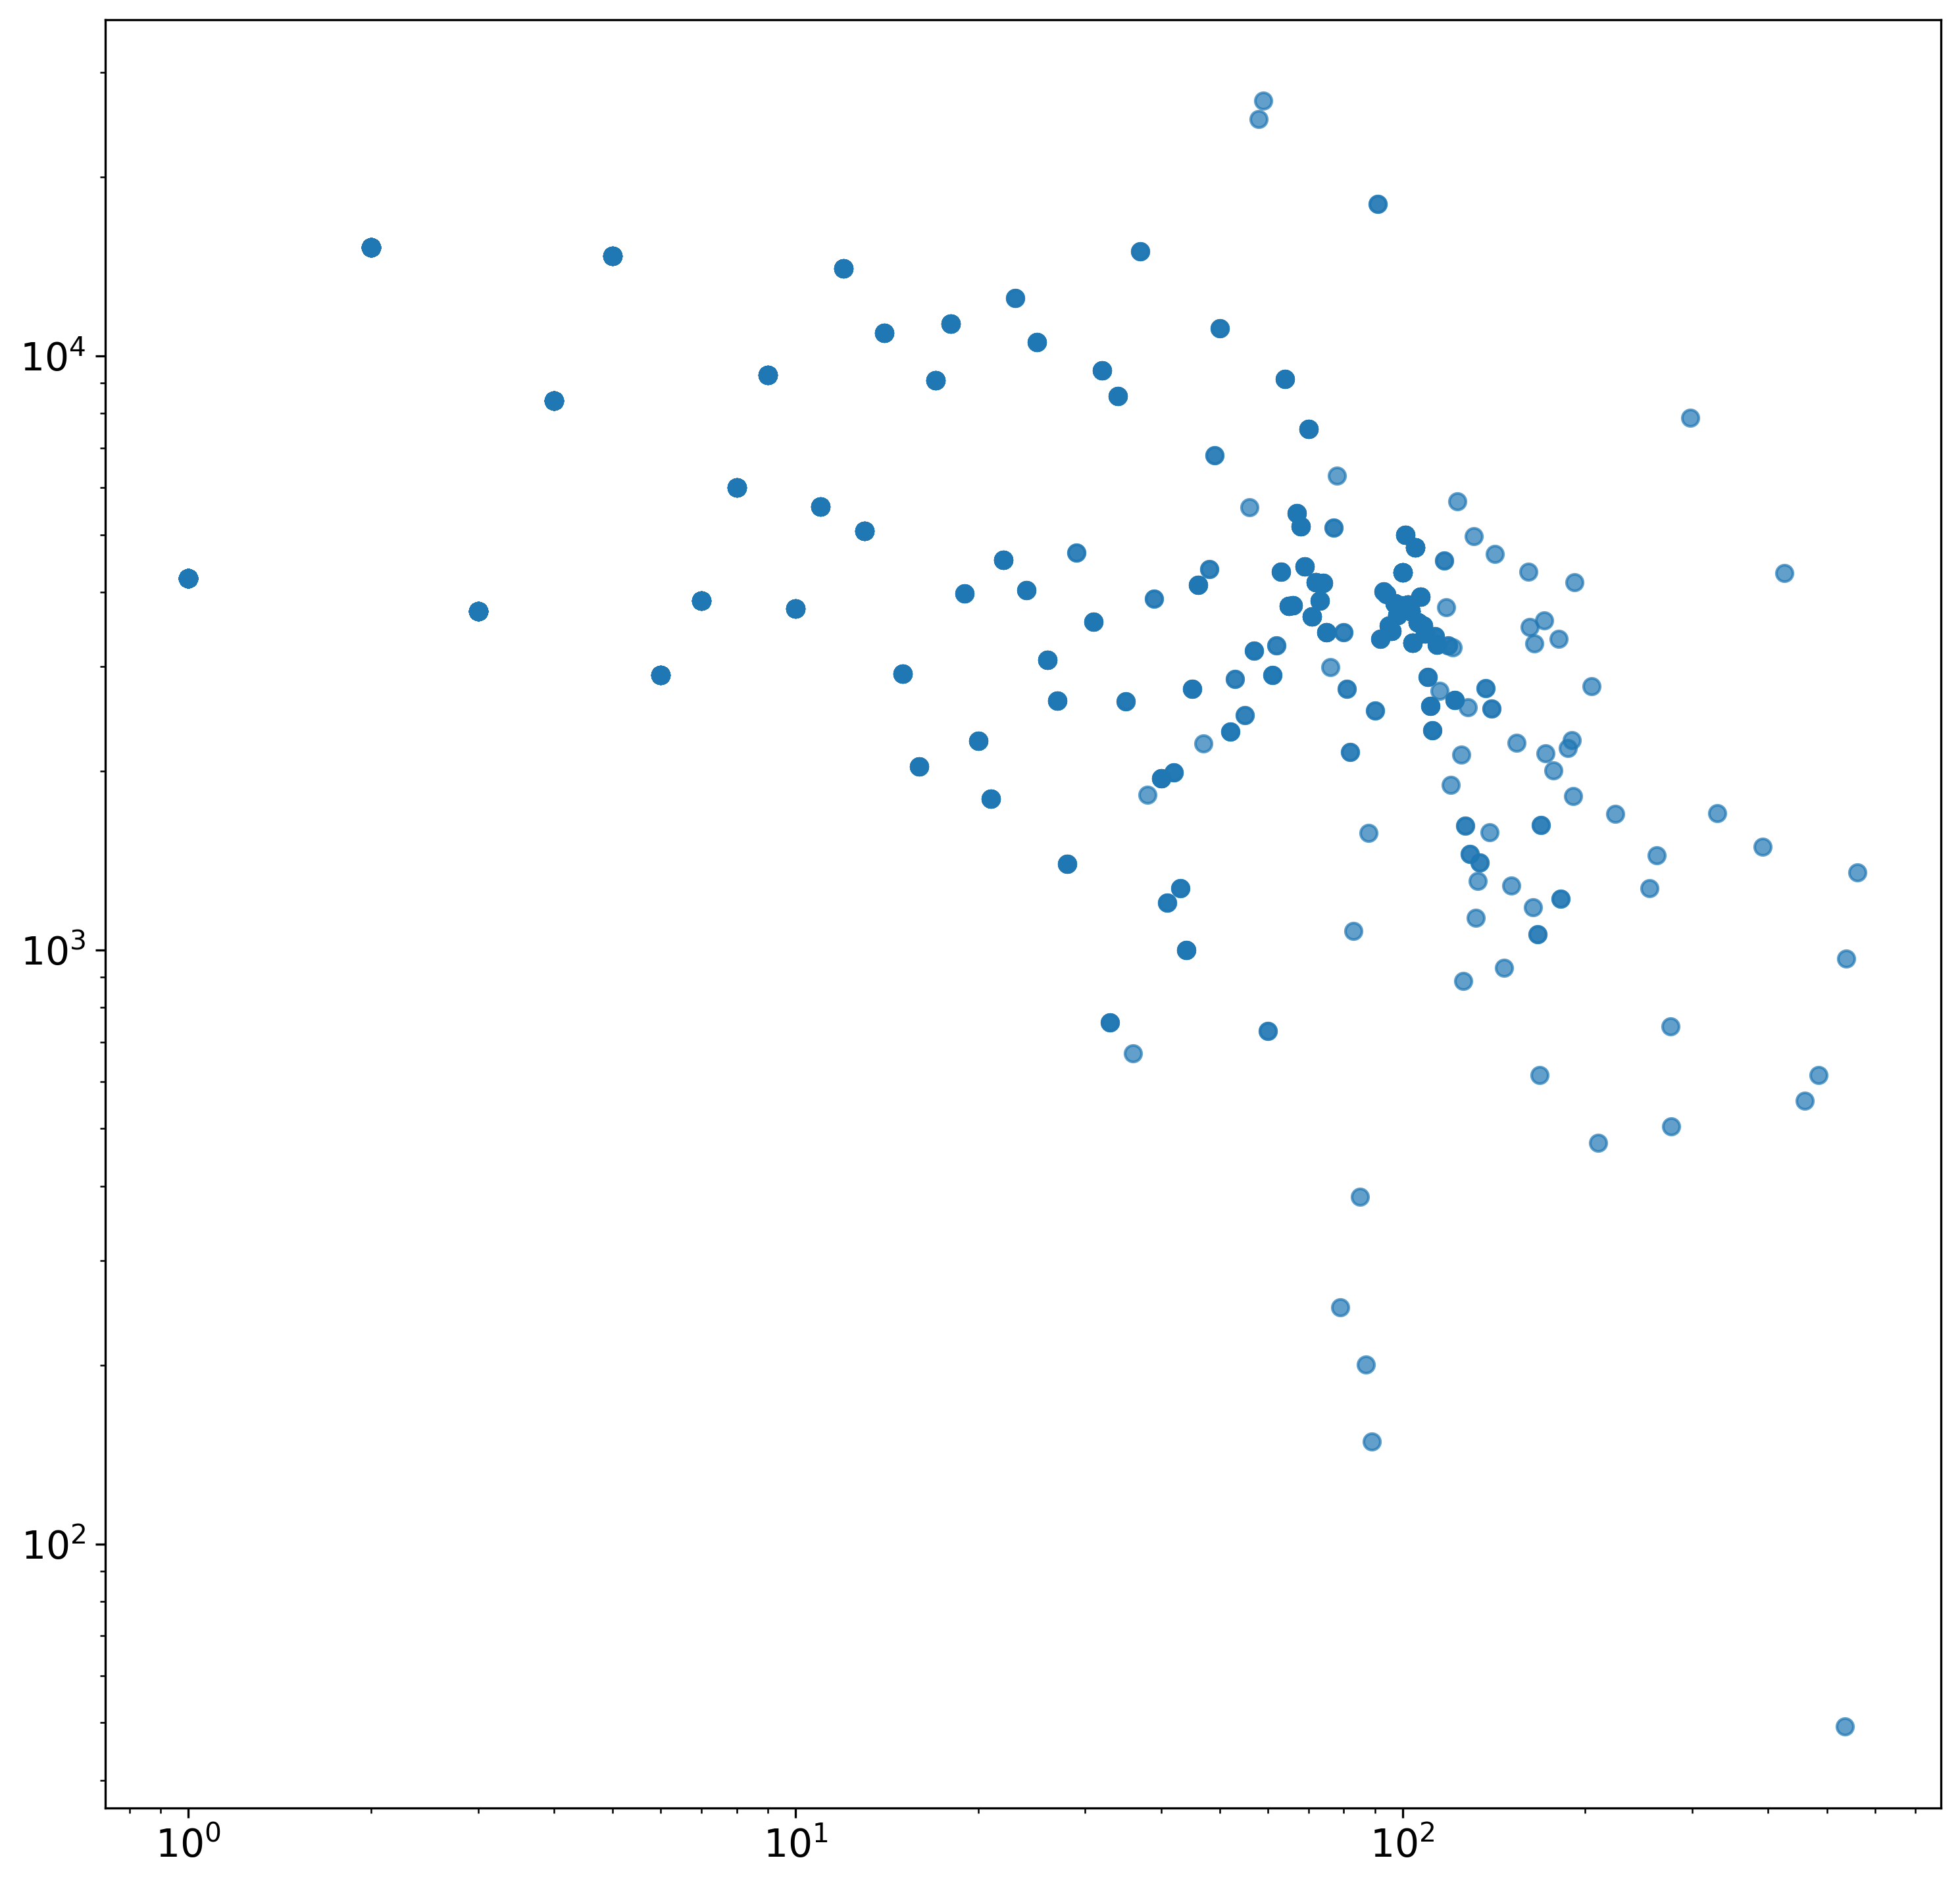

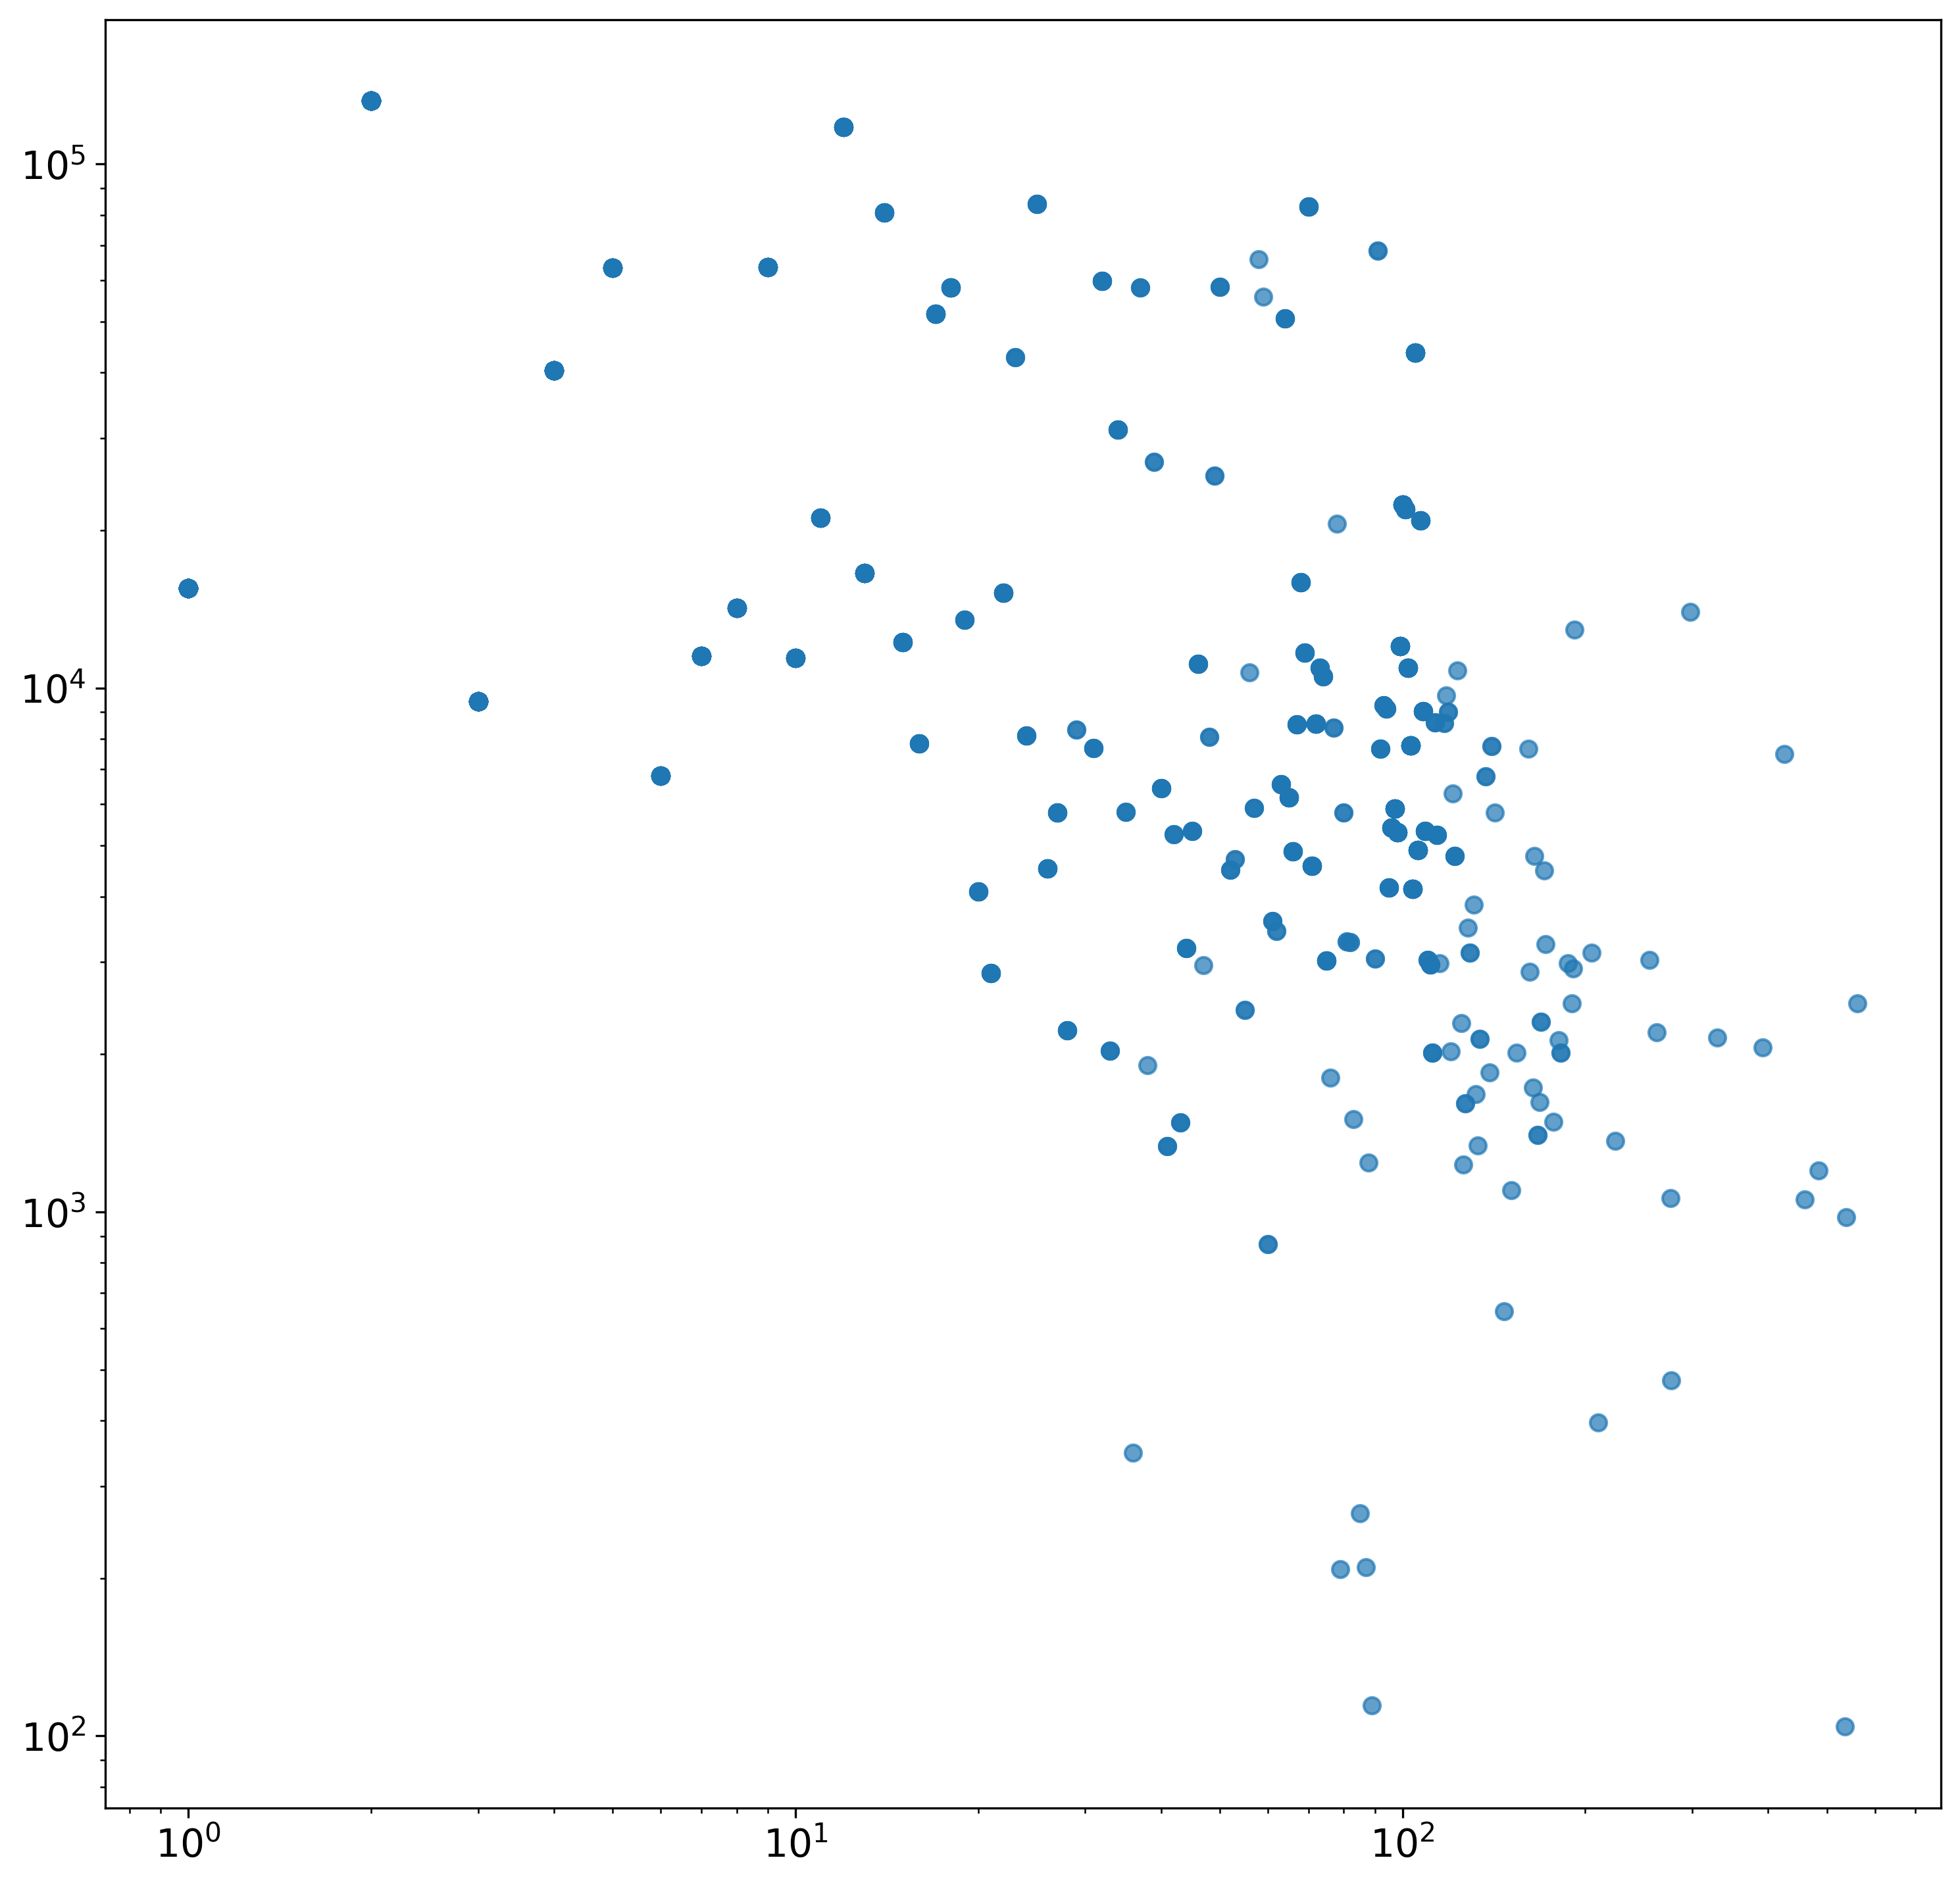

Log Kd Relationship
With log mean:  SpearmanrResult(correlation=0.7928670293436766, pvalue=0.0)
With log std:  SpearmanrResult(correlation=-0.8304423539385966, pvalue=0.0)


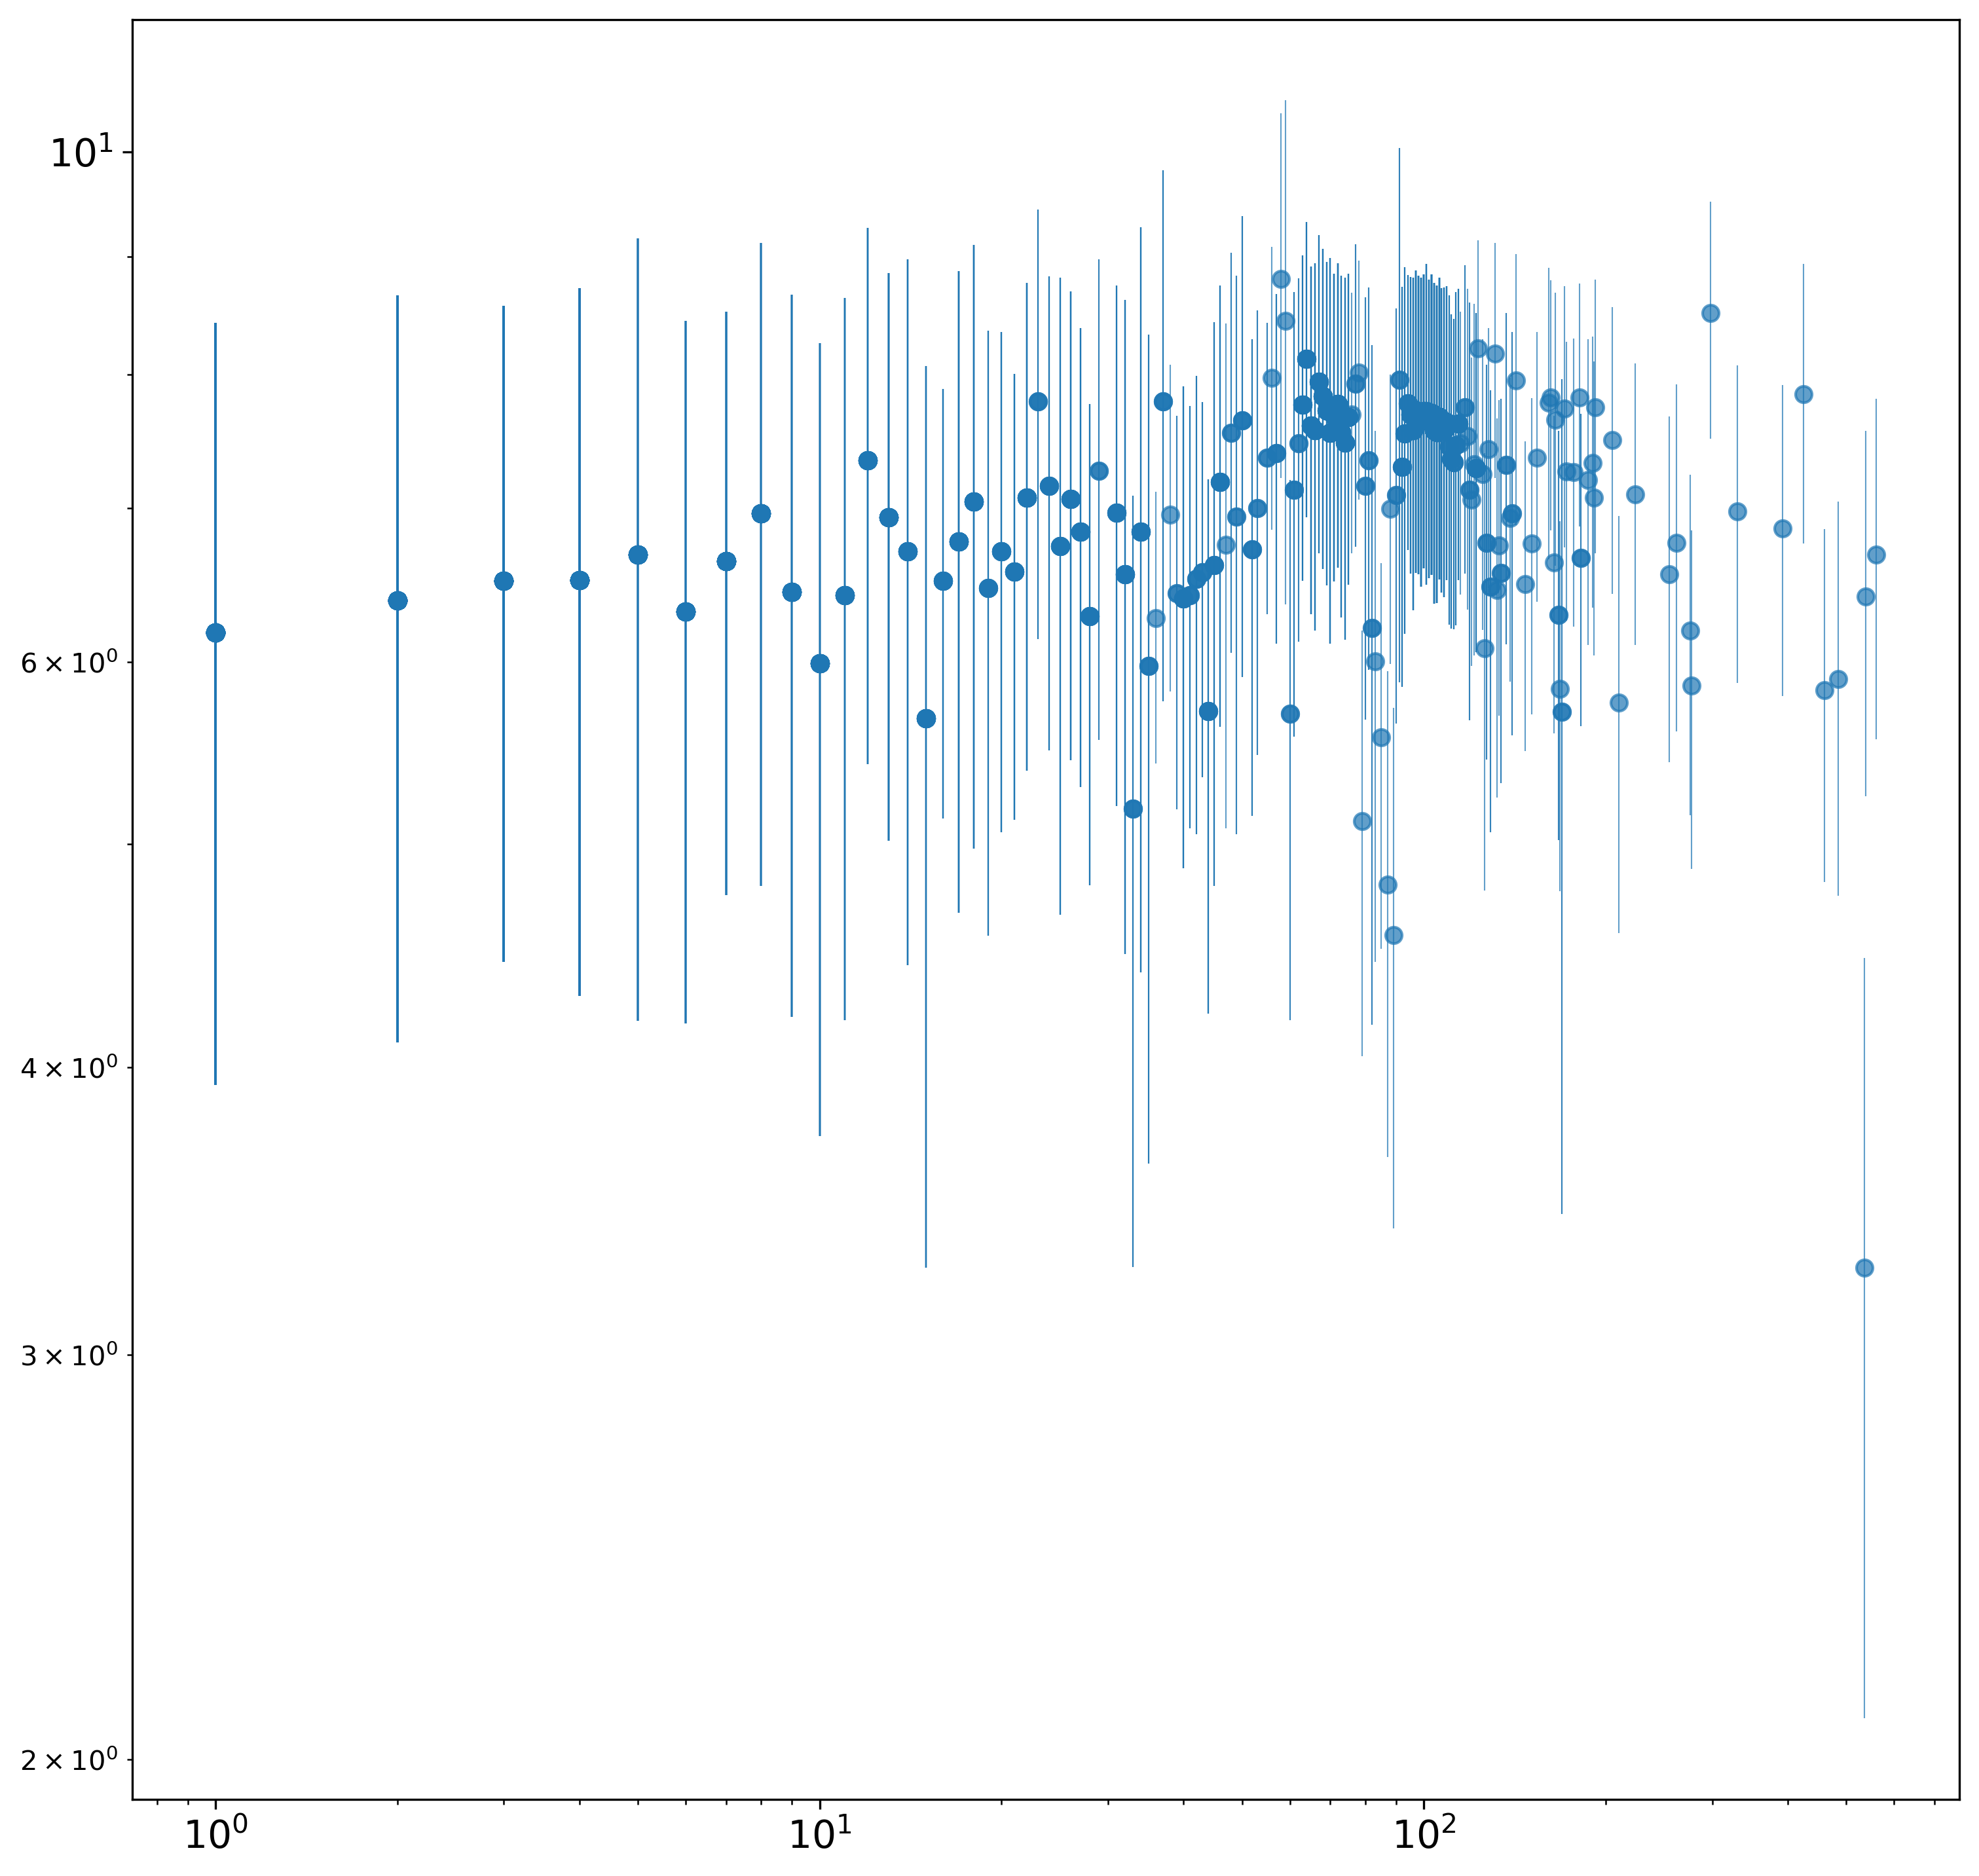

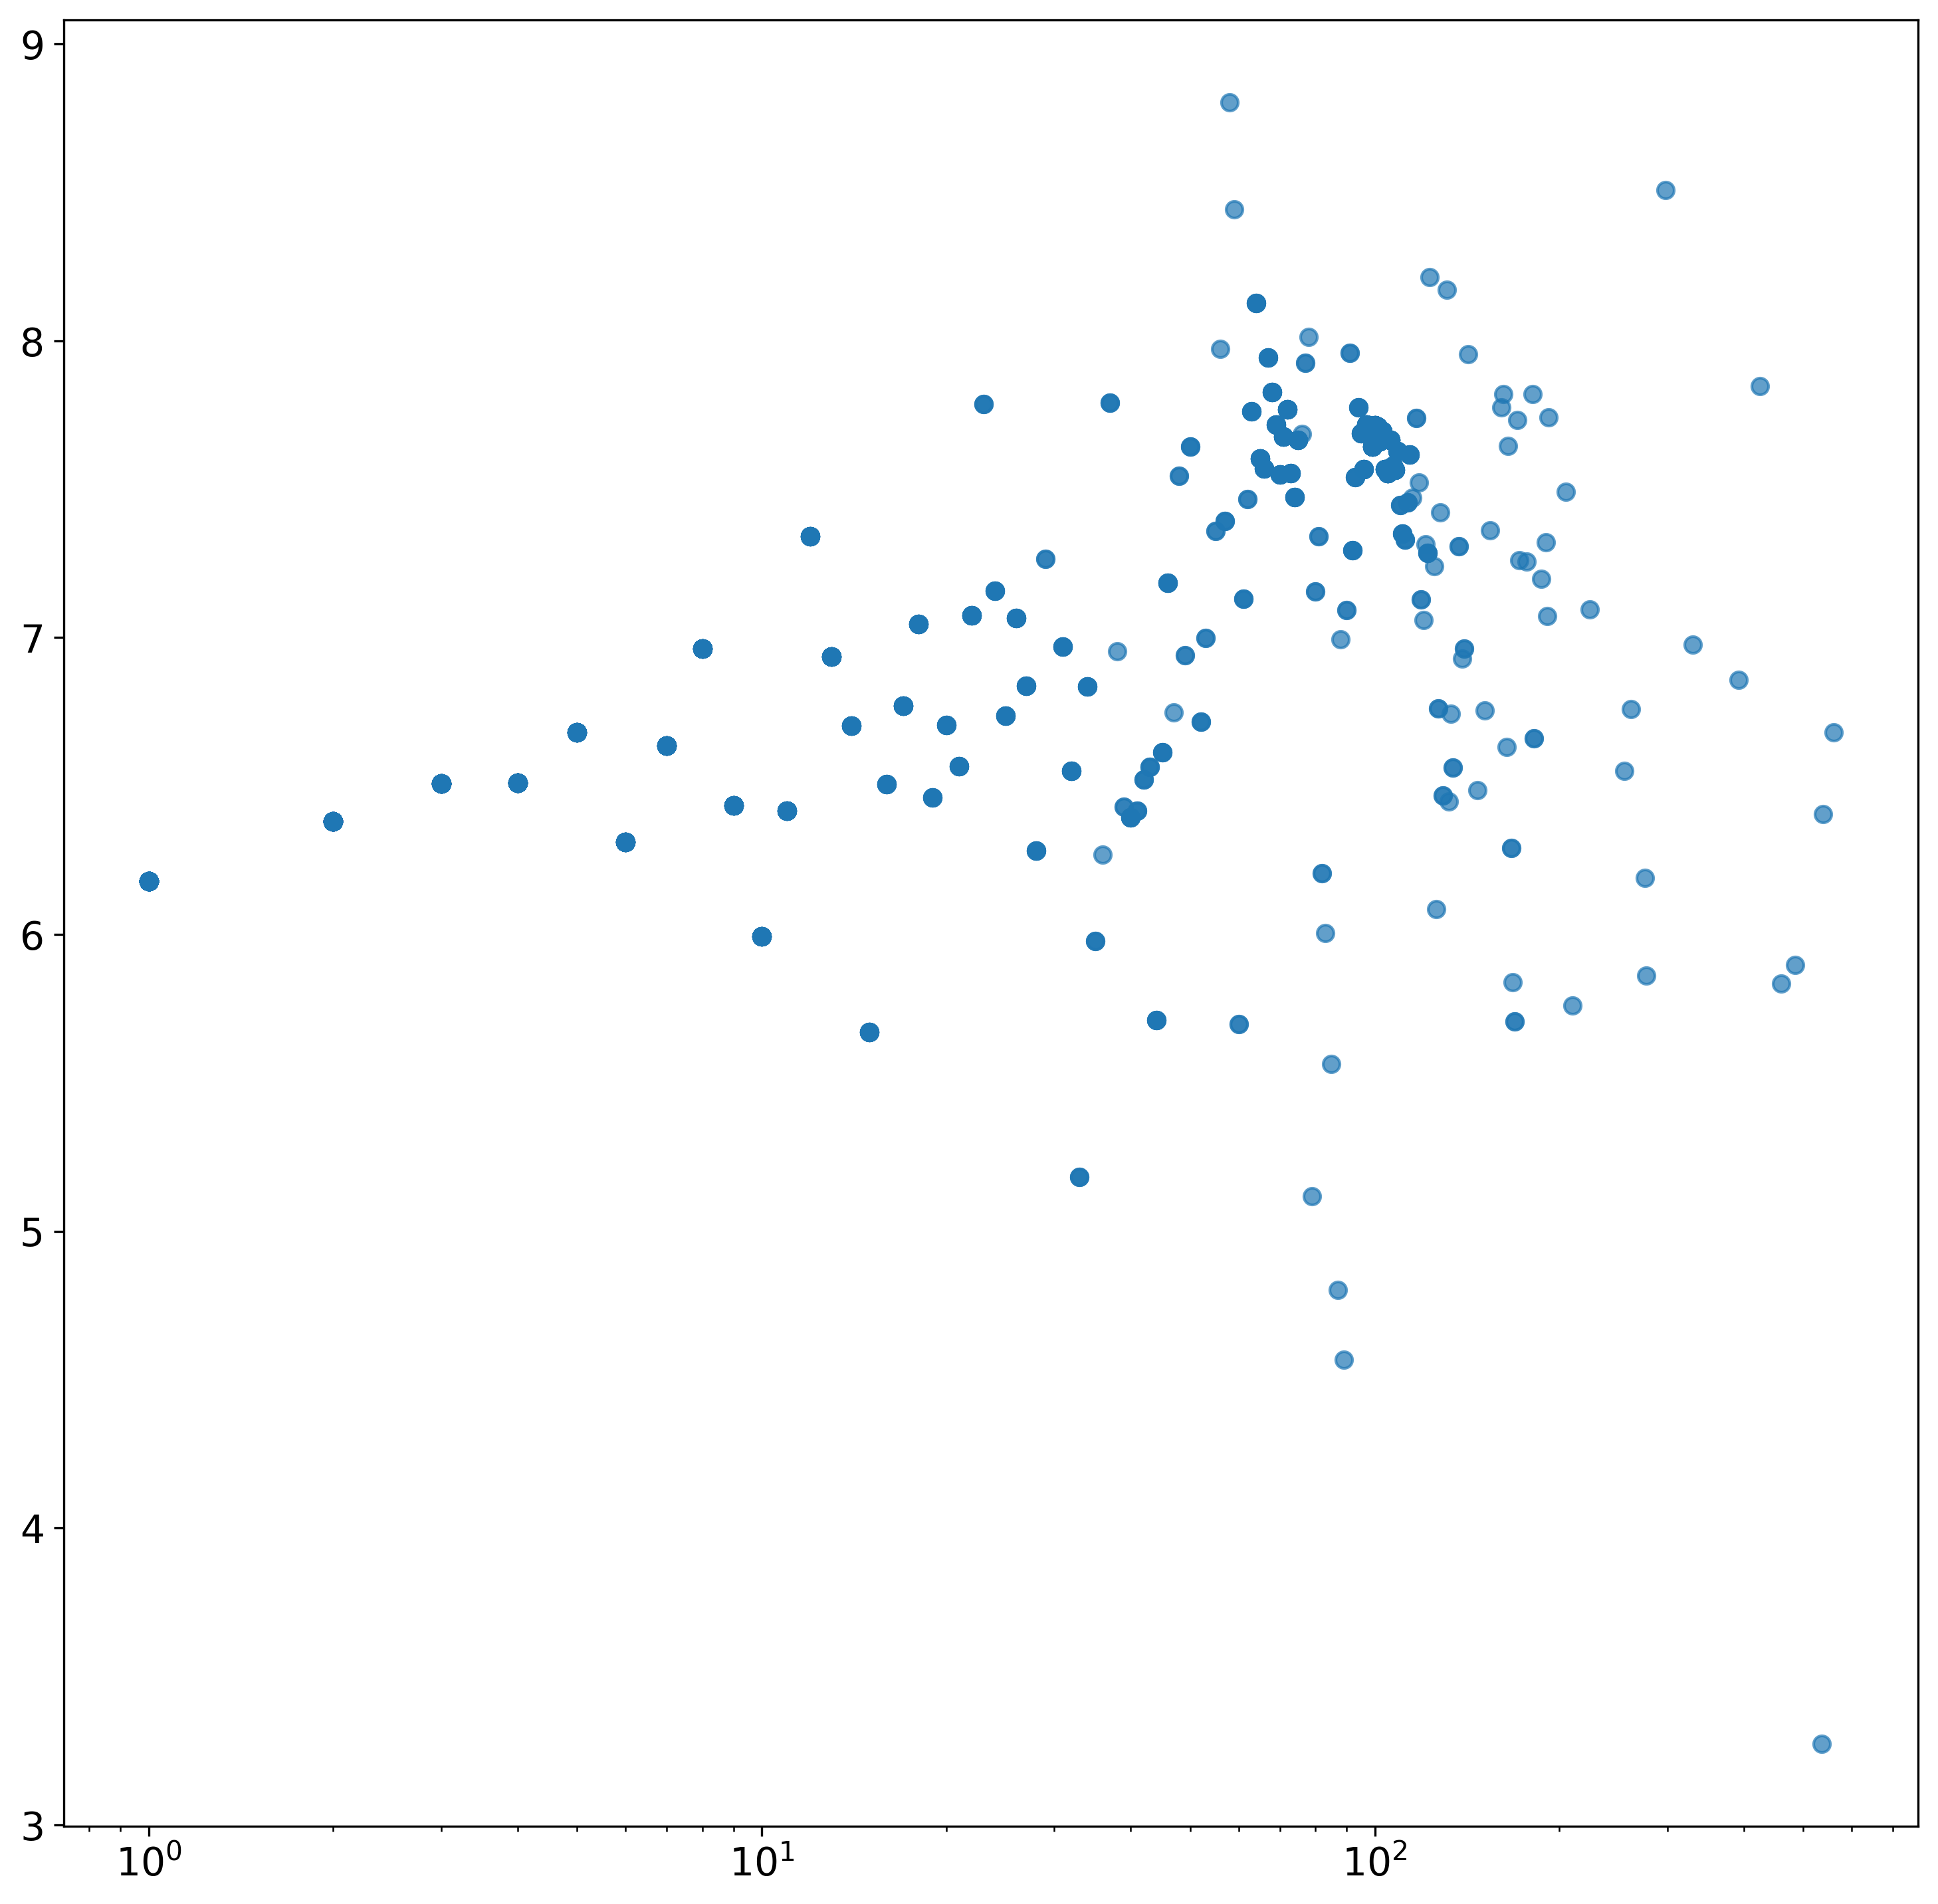

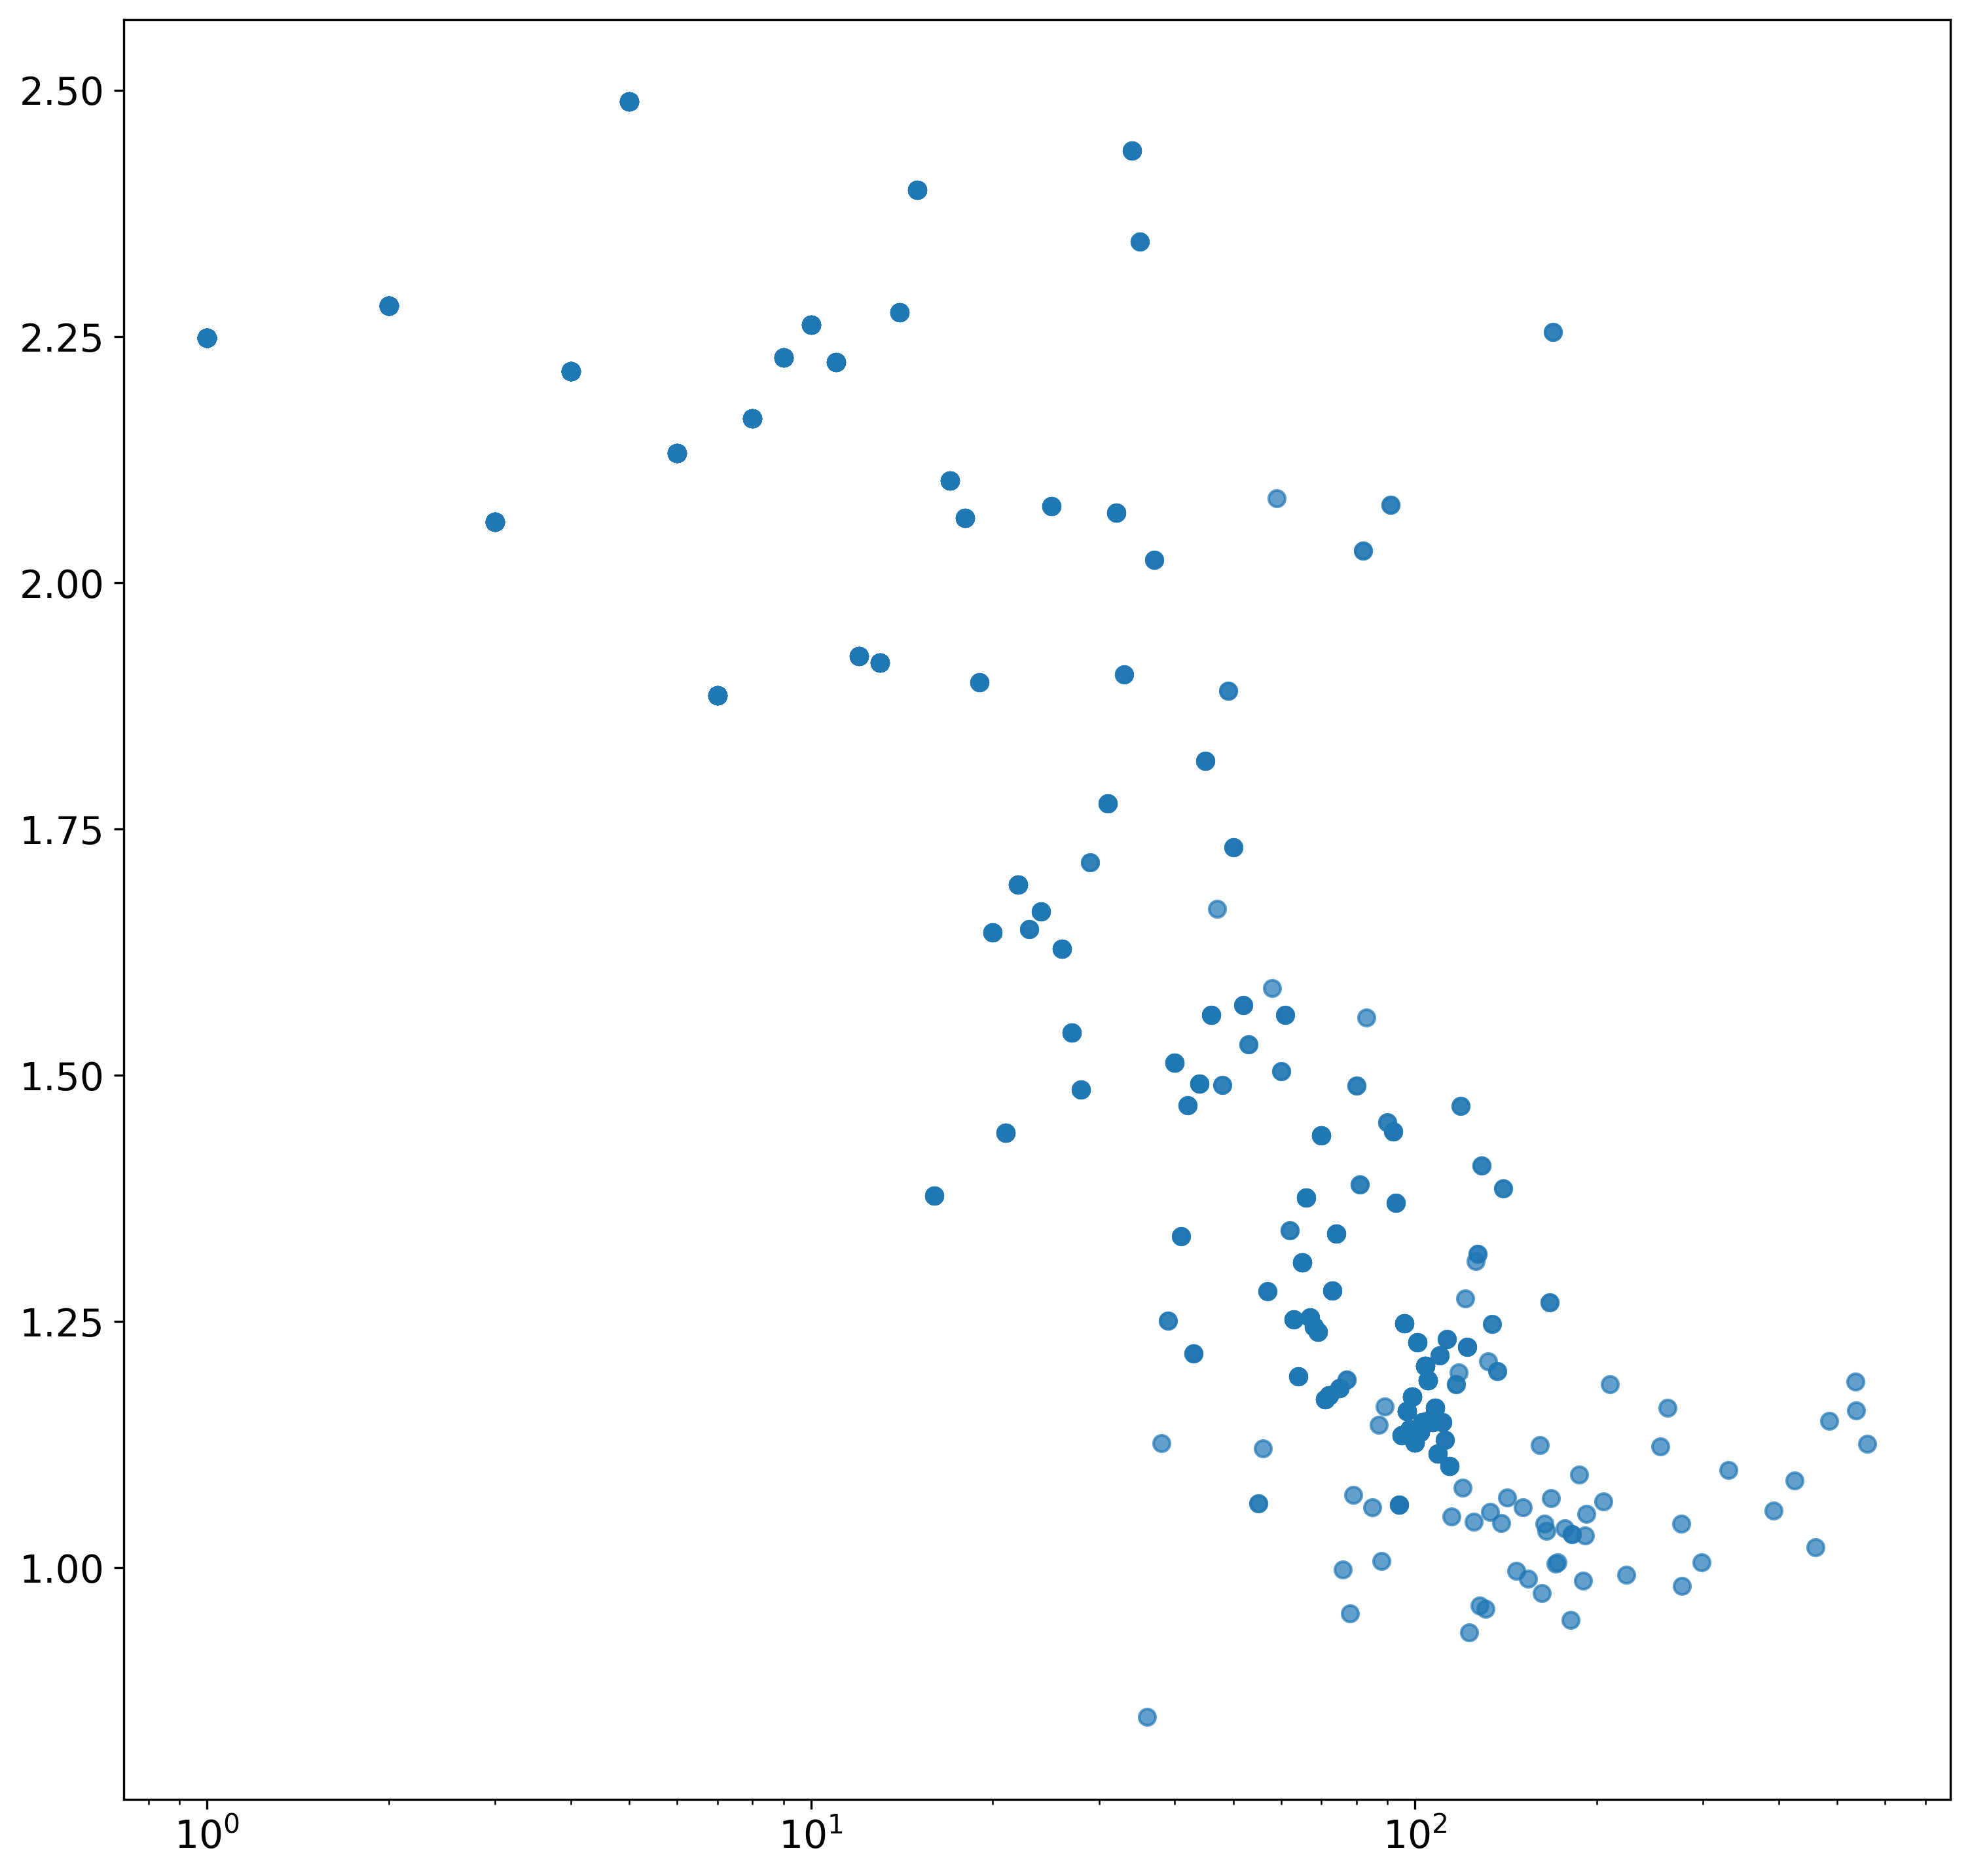

In [9]:
plot_k_Kd_relation_from_edges(network_dataOrig)

# Power-law with correlation 

100%|█████████████████████████████████████████████████████████████████████████████| 1416/1416 [00:02<00:00, 513.49it/s]


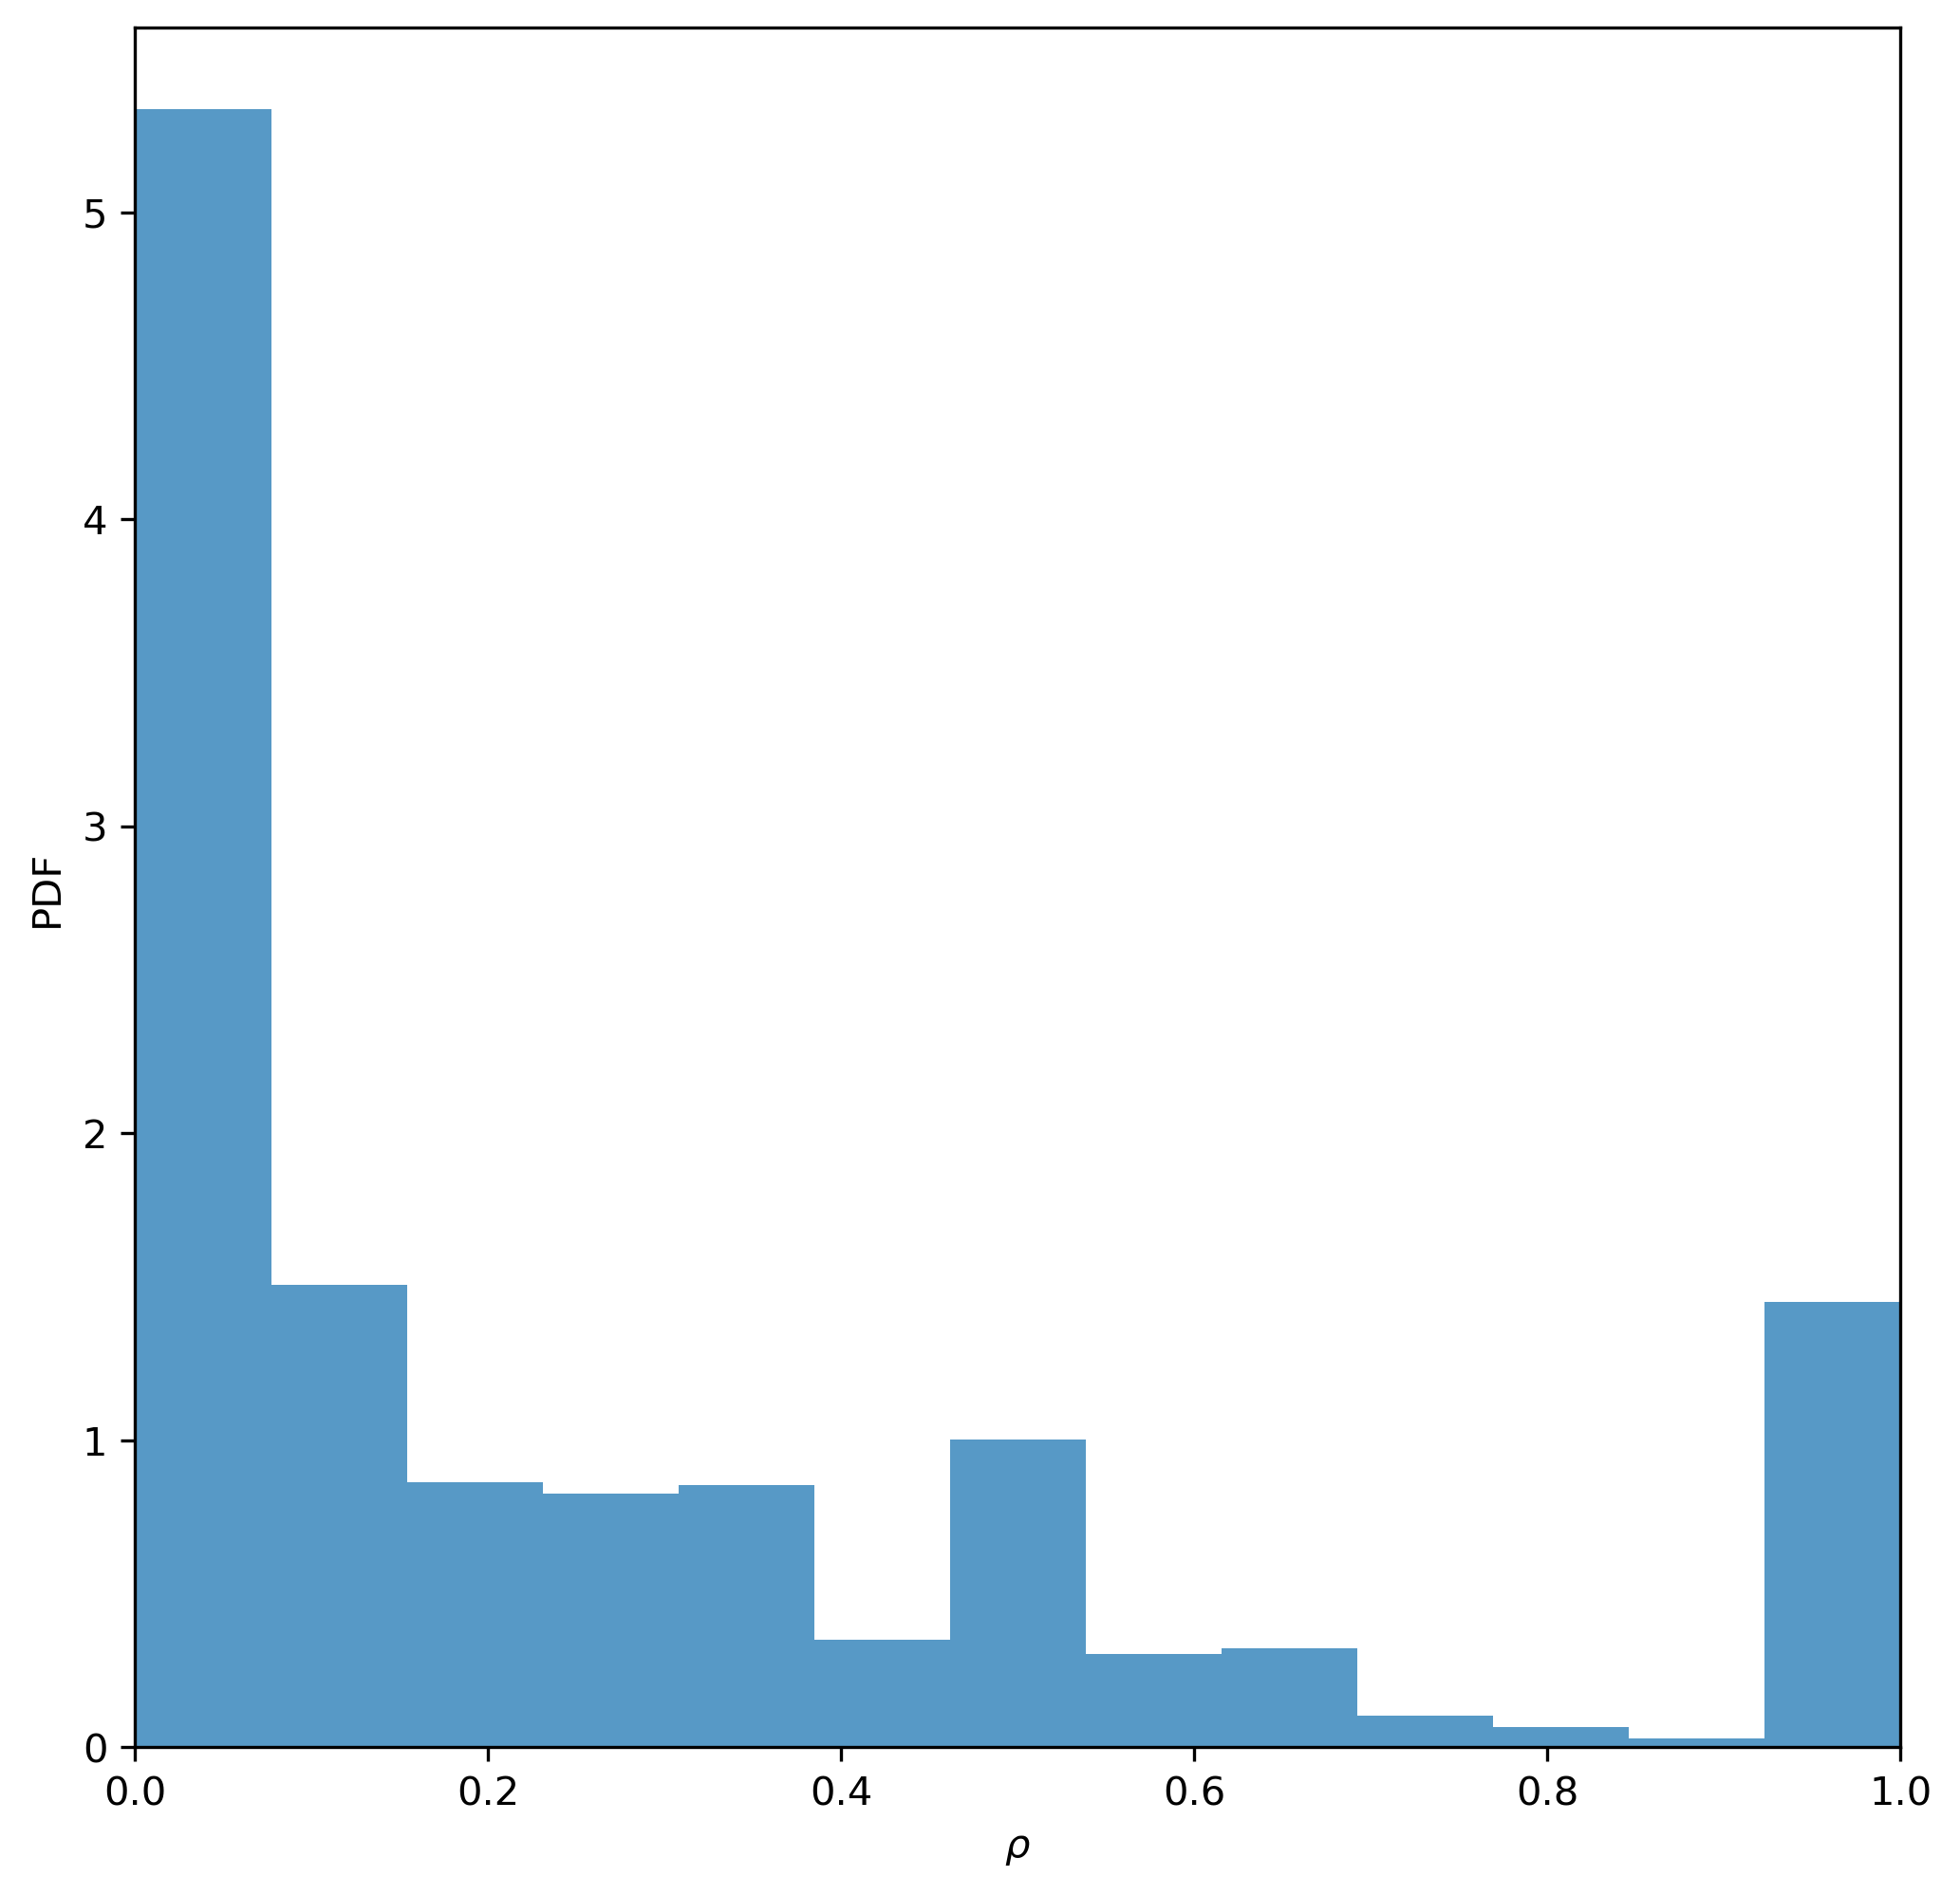

Number of nodes with not positive or negative annotation:  0
Validating p_bind value from binary labels:  0.14262730833799664


  0%|▍                                                                              | 48/10000 [00:05<17:26,  9.51it/s]


Loops  49
Error margin:  [9.13351665e-06]


8578it [00:04, 2028.26it/s]


AUC:  0.857650003879968
AUP:  0.5849547610423708
Transductive performance:
AUC:  0.863417102716891
AUP:  0.593926169753257


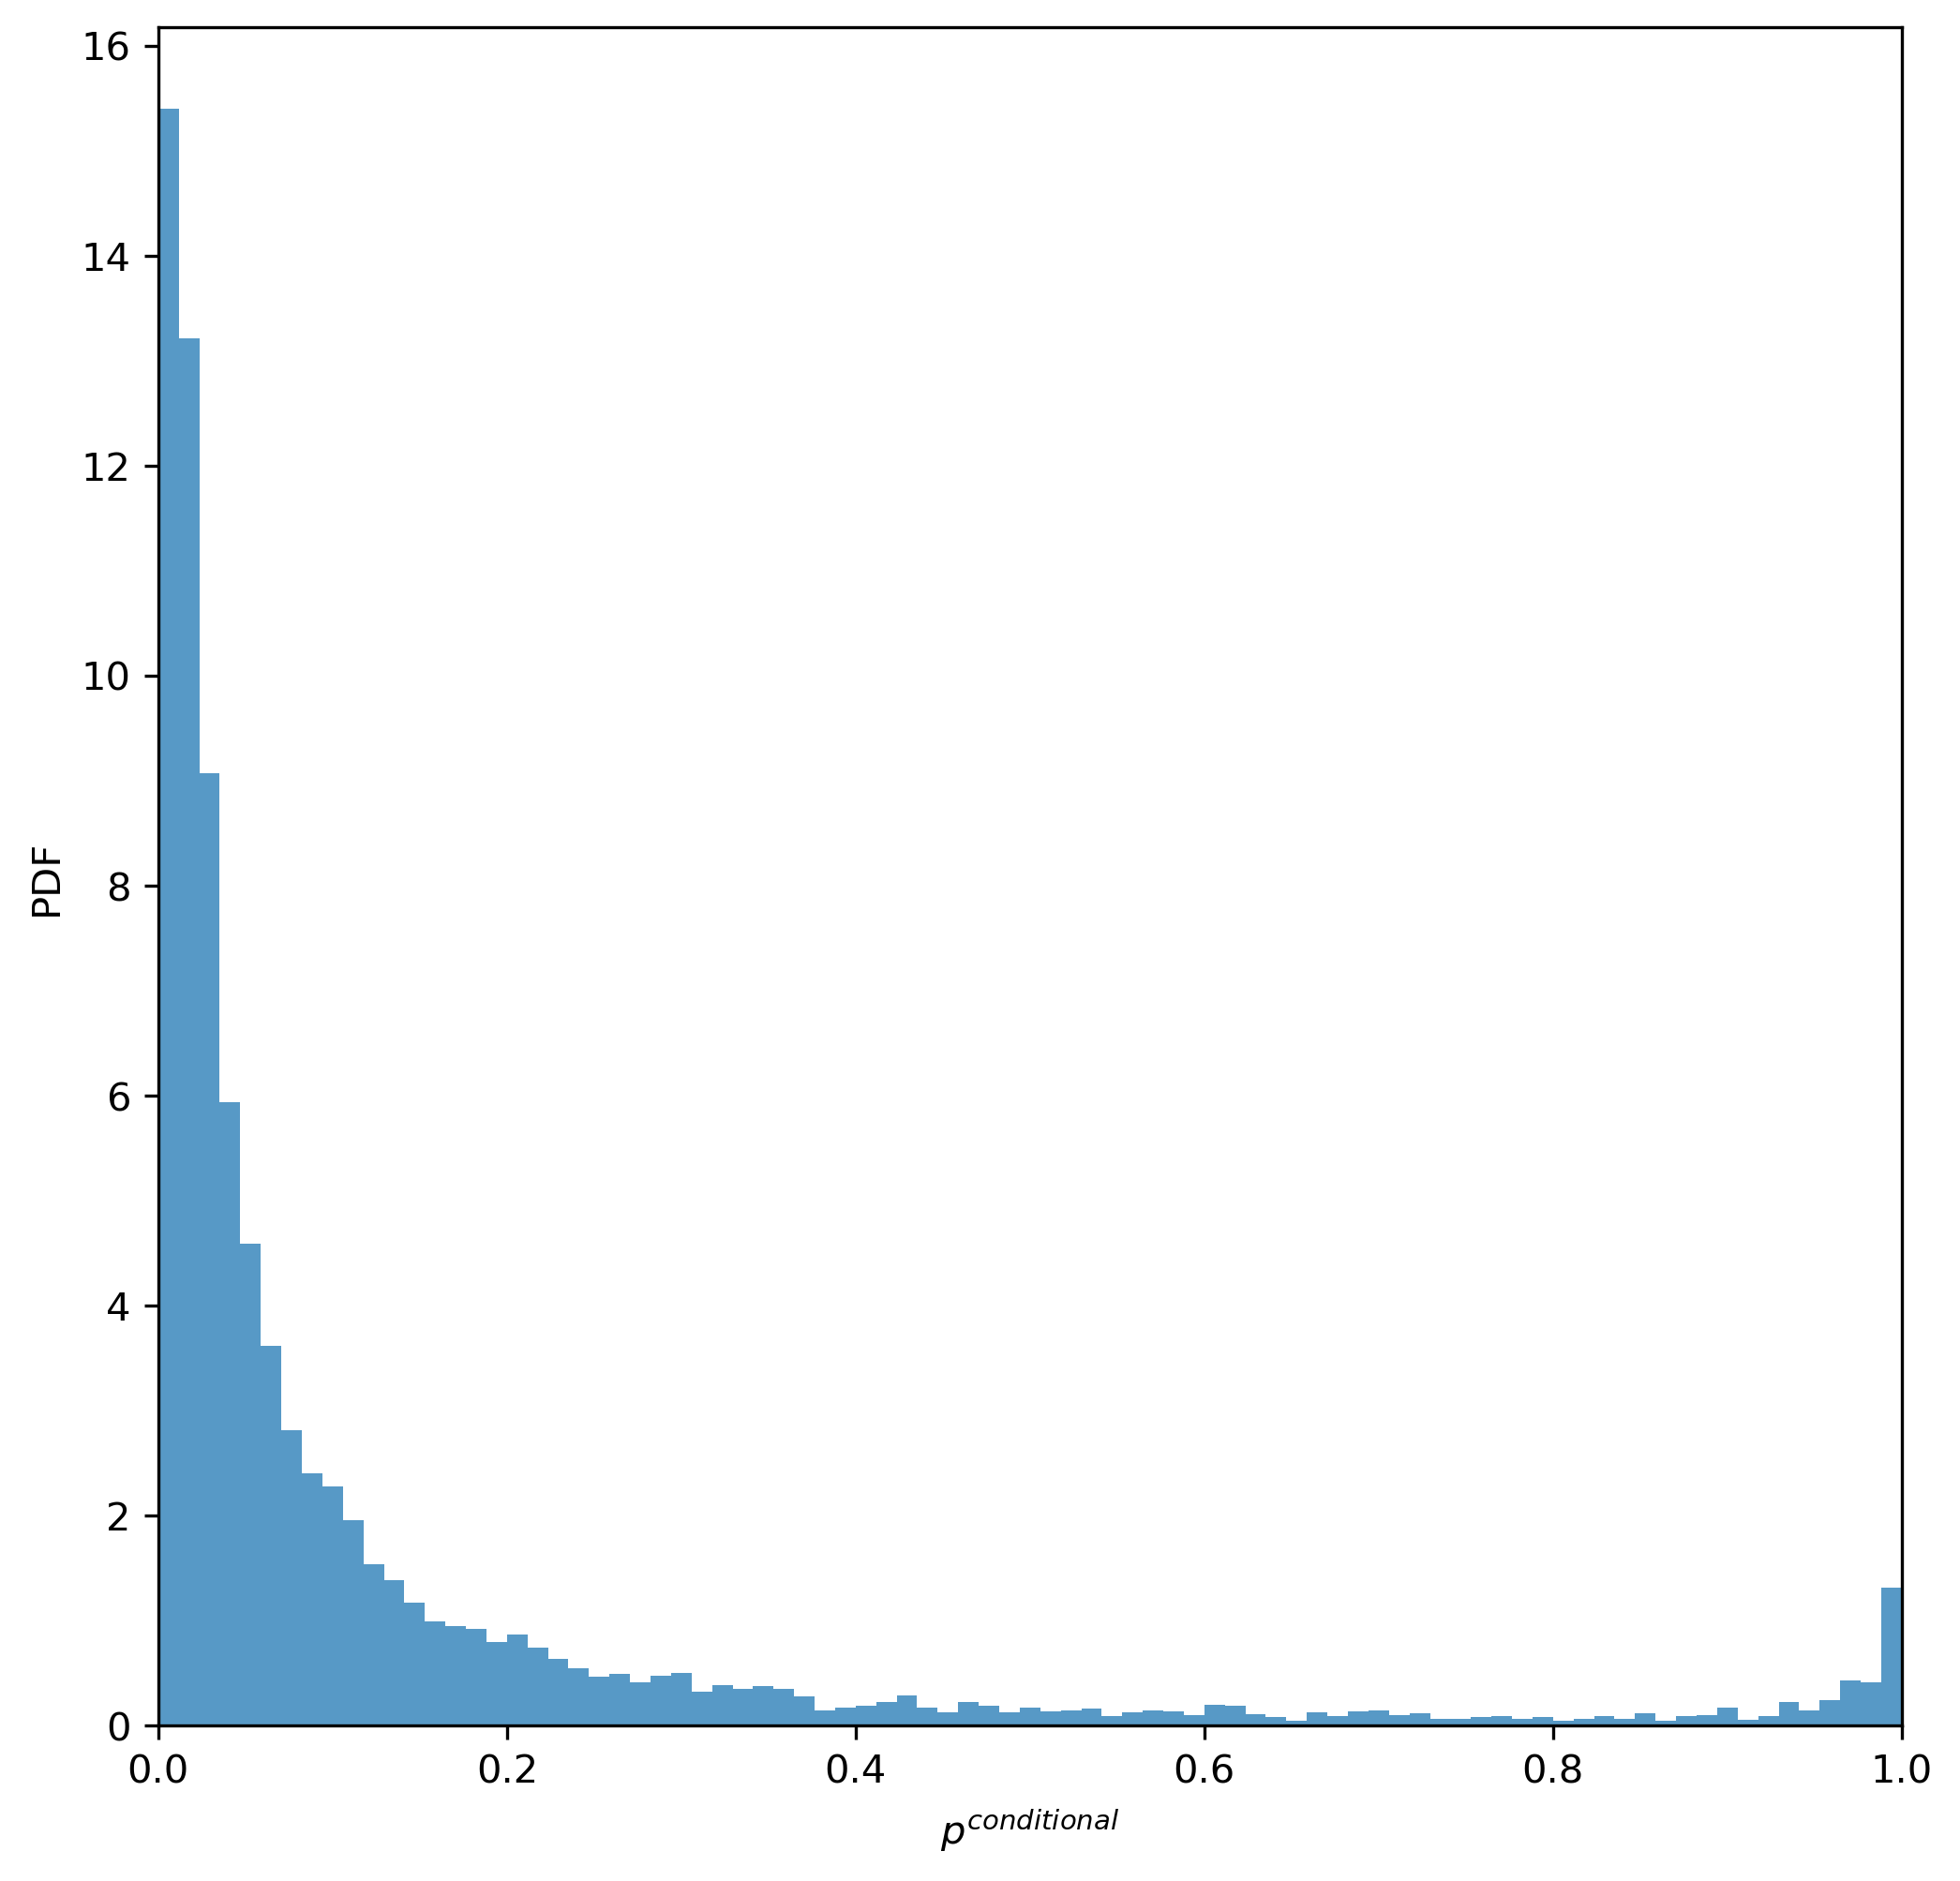

In [10]:
run_configuration_model(network_dataOrig)

# Poisson with correlation

100%|█████████████████████████████████████████████████████████████████████████████| 1507/1507 [00:02<00:00, 582.94it/s]


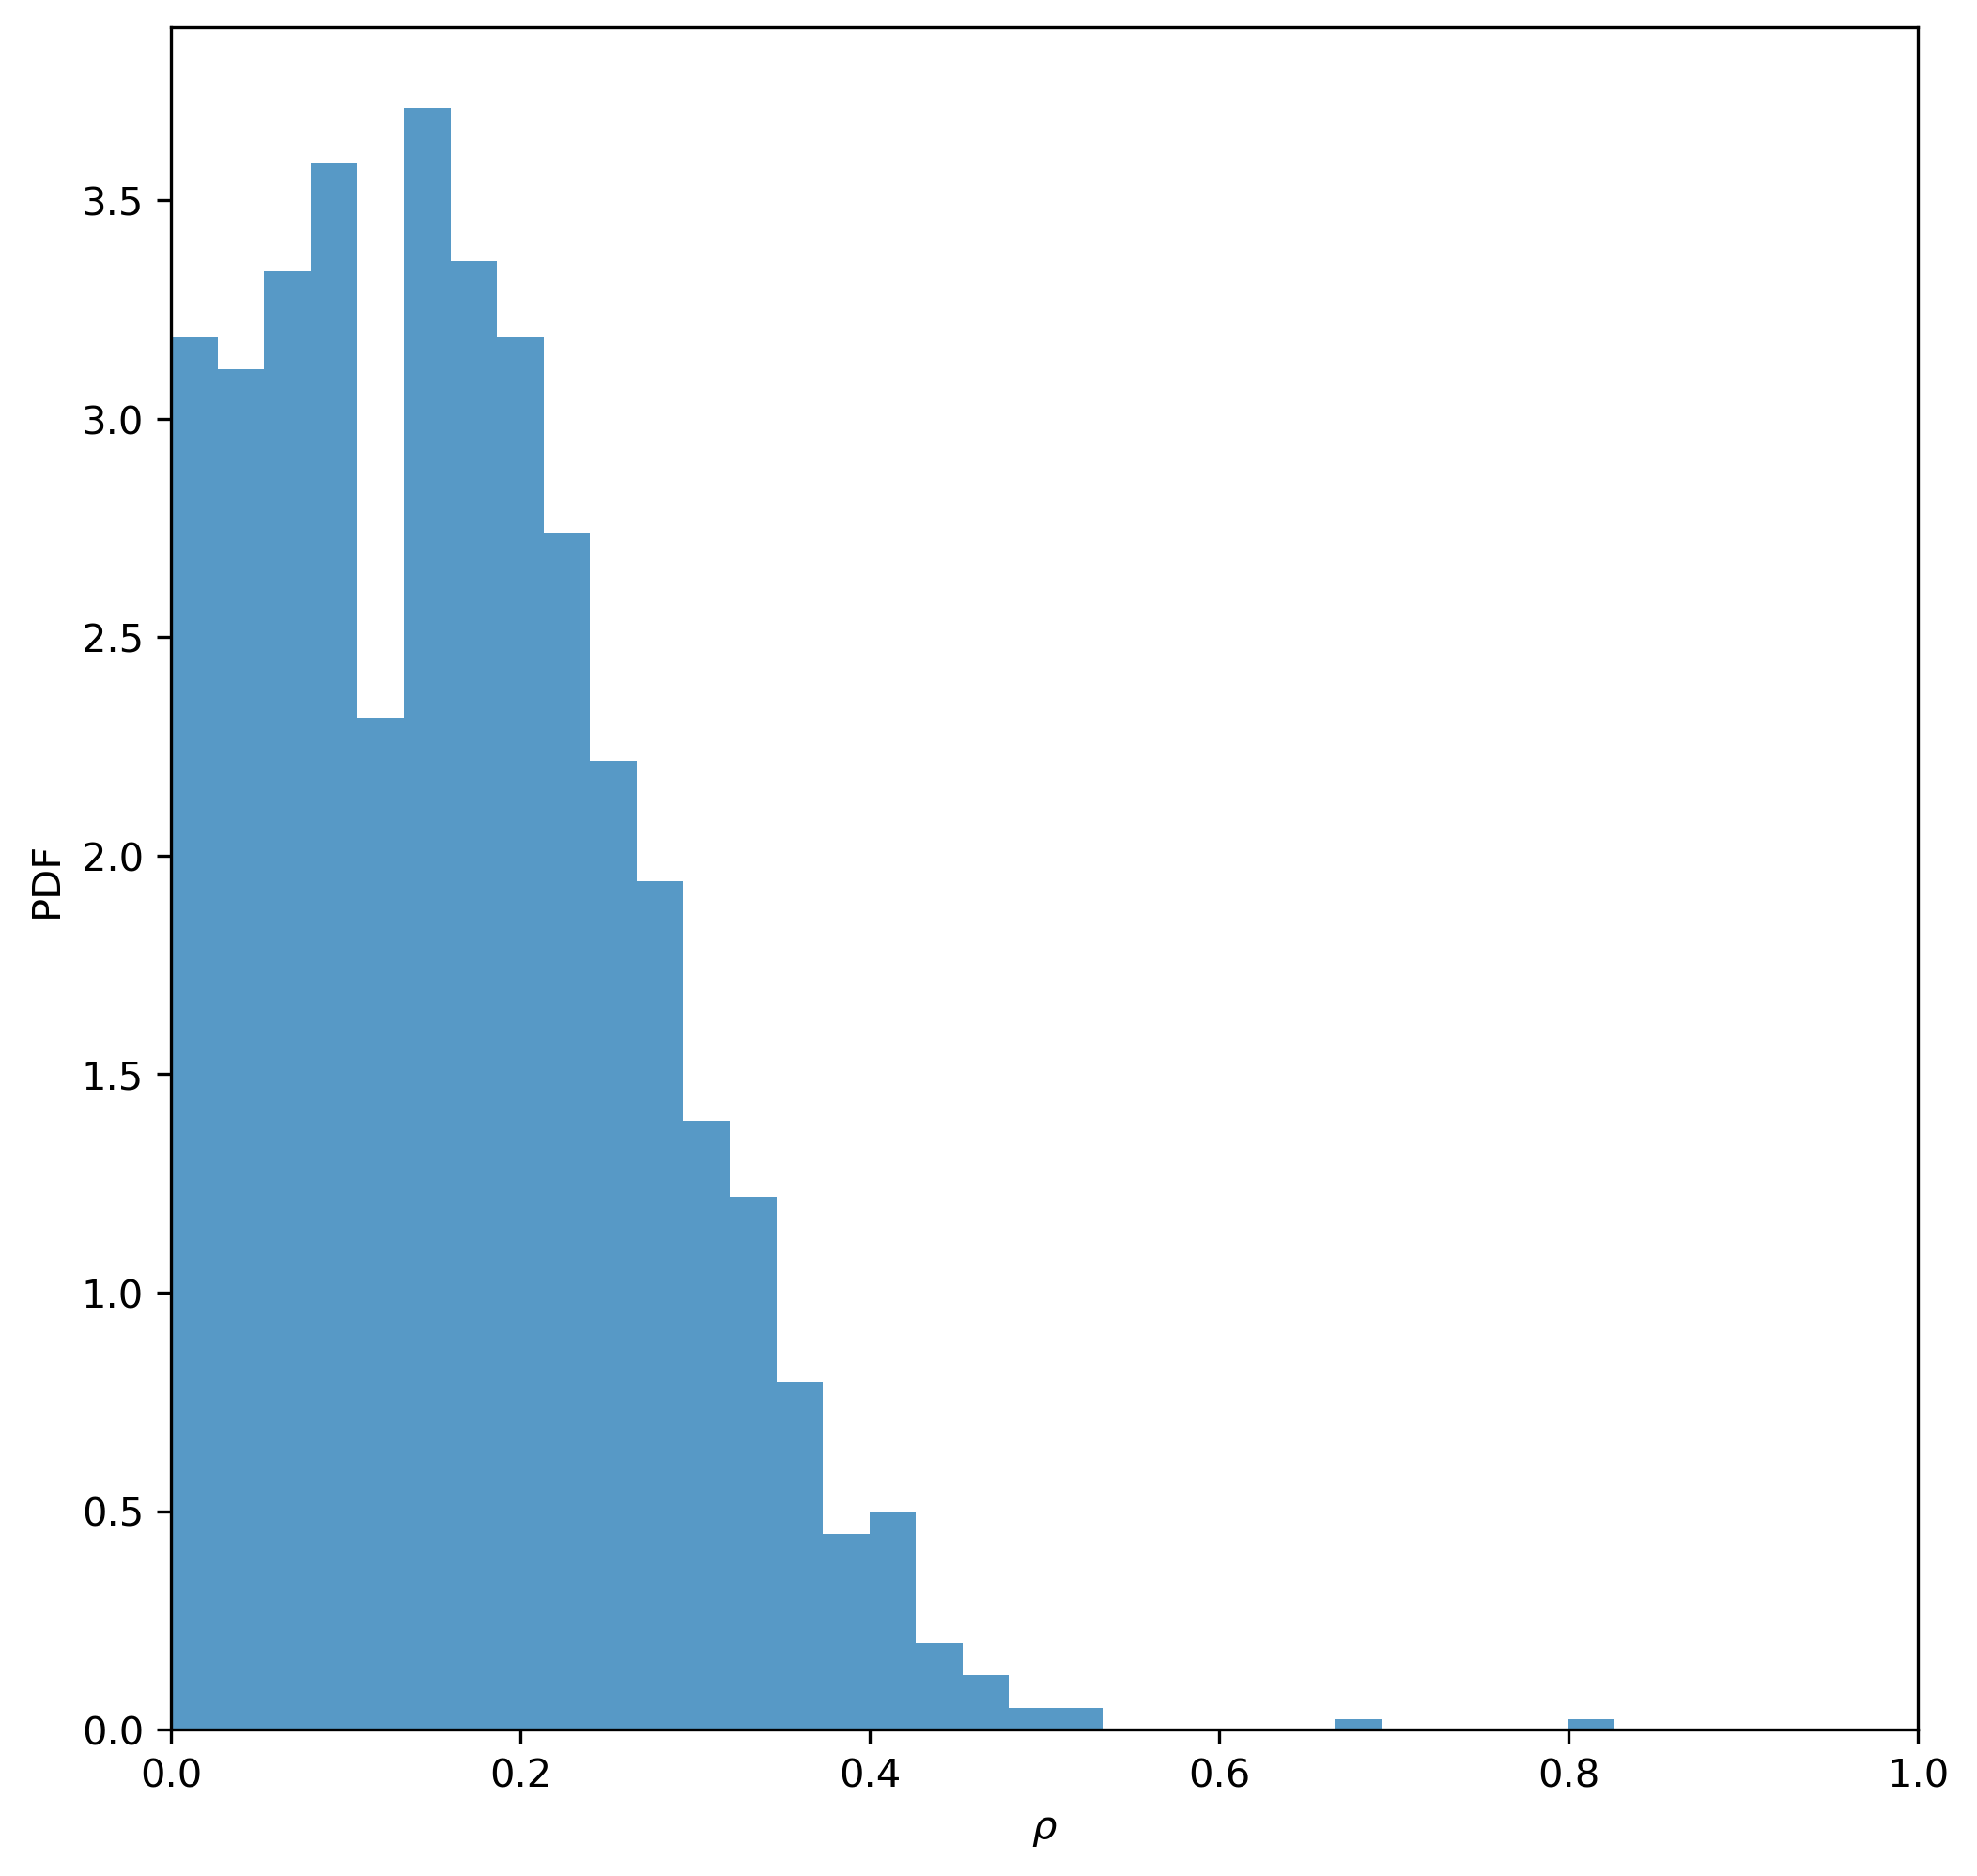

Number of nodes with not positive or negative annotation:  0
Validating p_bind value from binary labels:  0.15851975386738743


  6%|████▋                                                                         | 598/10000 [01:16<20:02,  7.82it/s]


Loops  599
Error margin:  [9.83283828e-06]


10434it [00:03, 2676.50it/s]


AUC:  0.7203046374811972
AUP:  0.32696962800282897
Transductive performance:
AUC:  0.7203046374811972
AUP:  0.32696962800282897


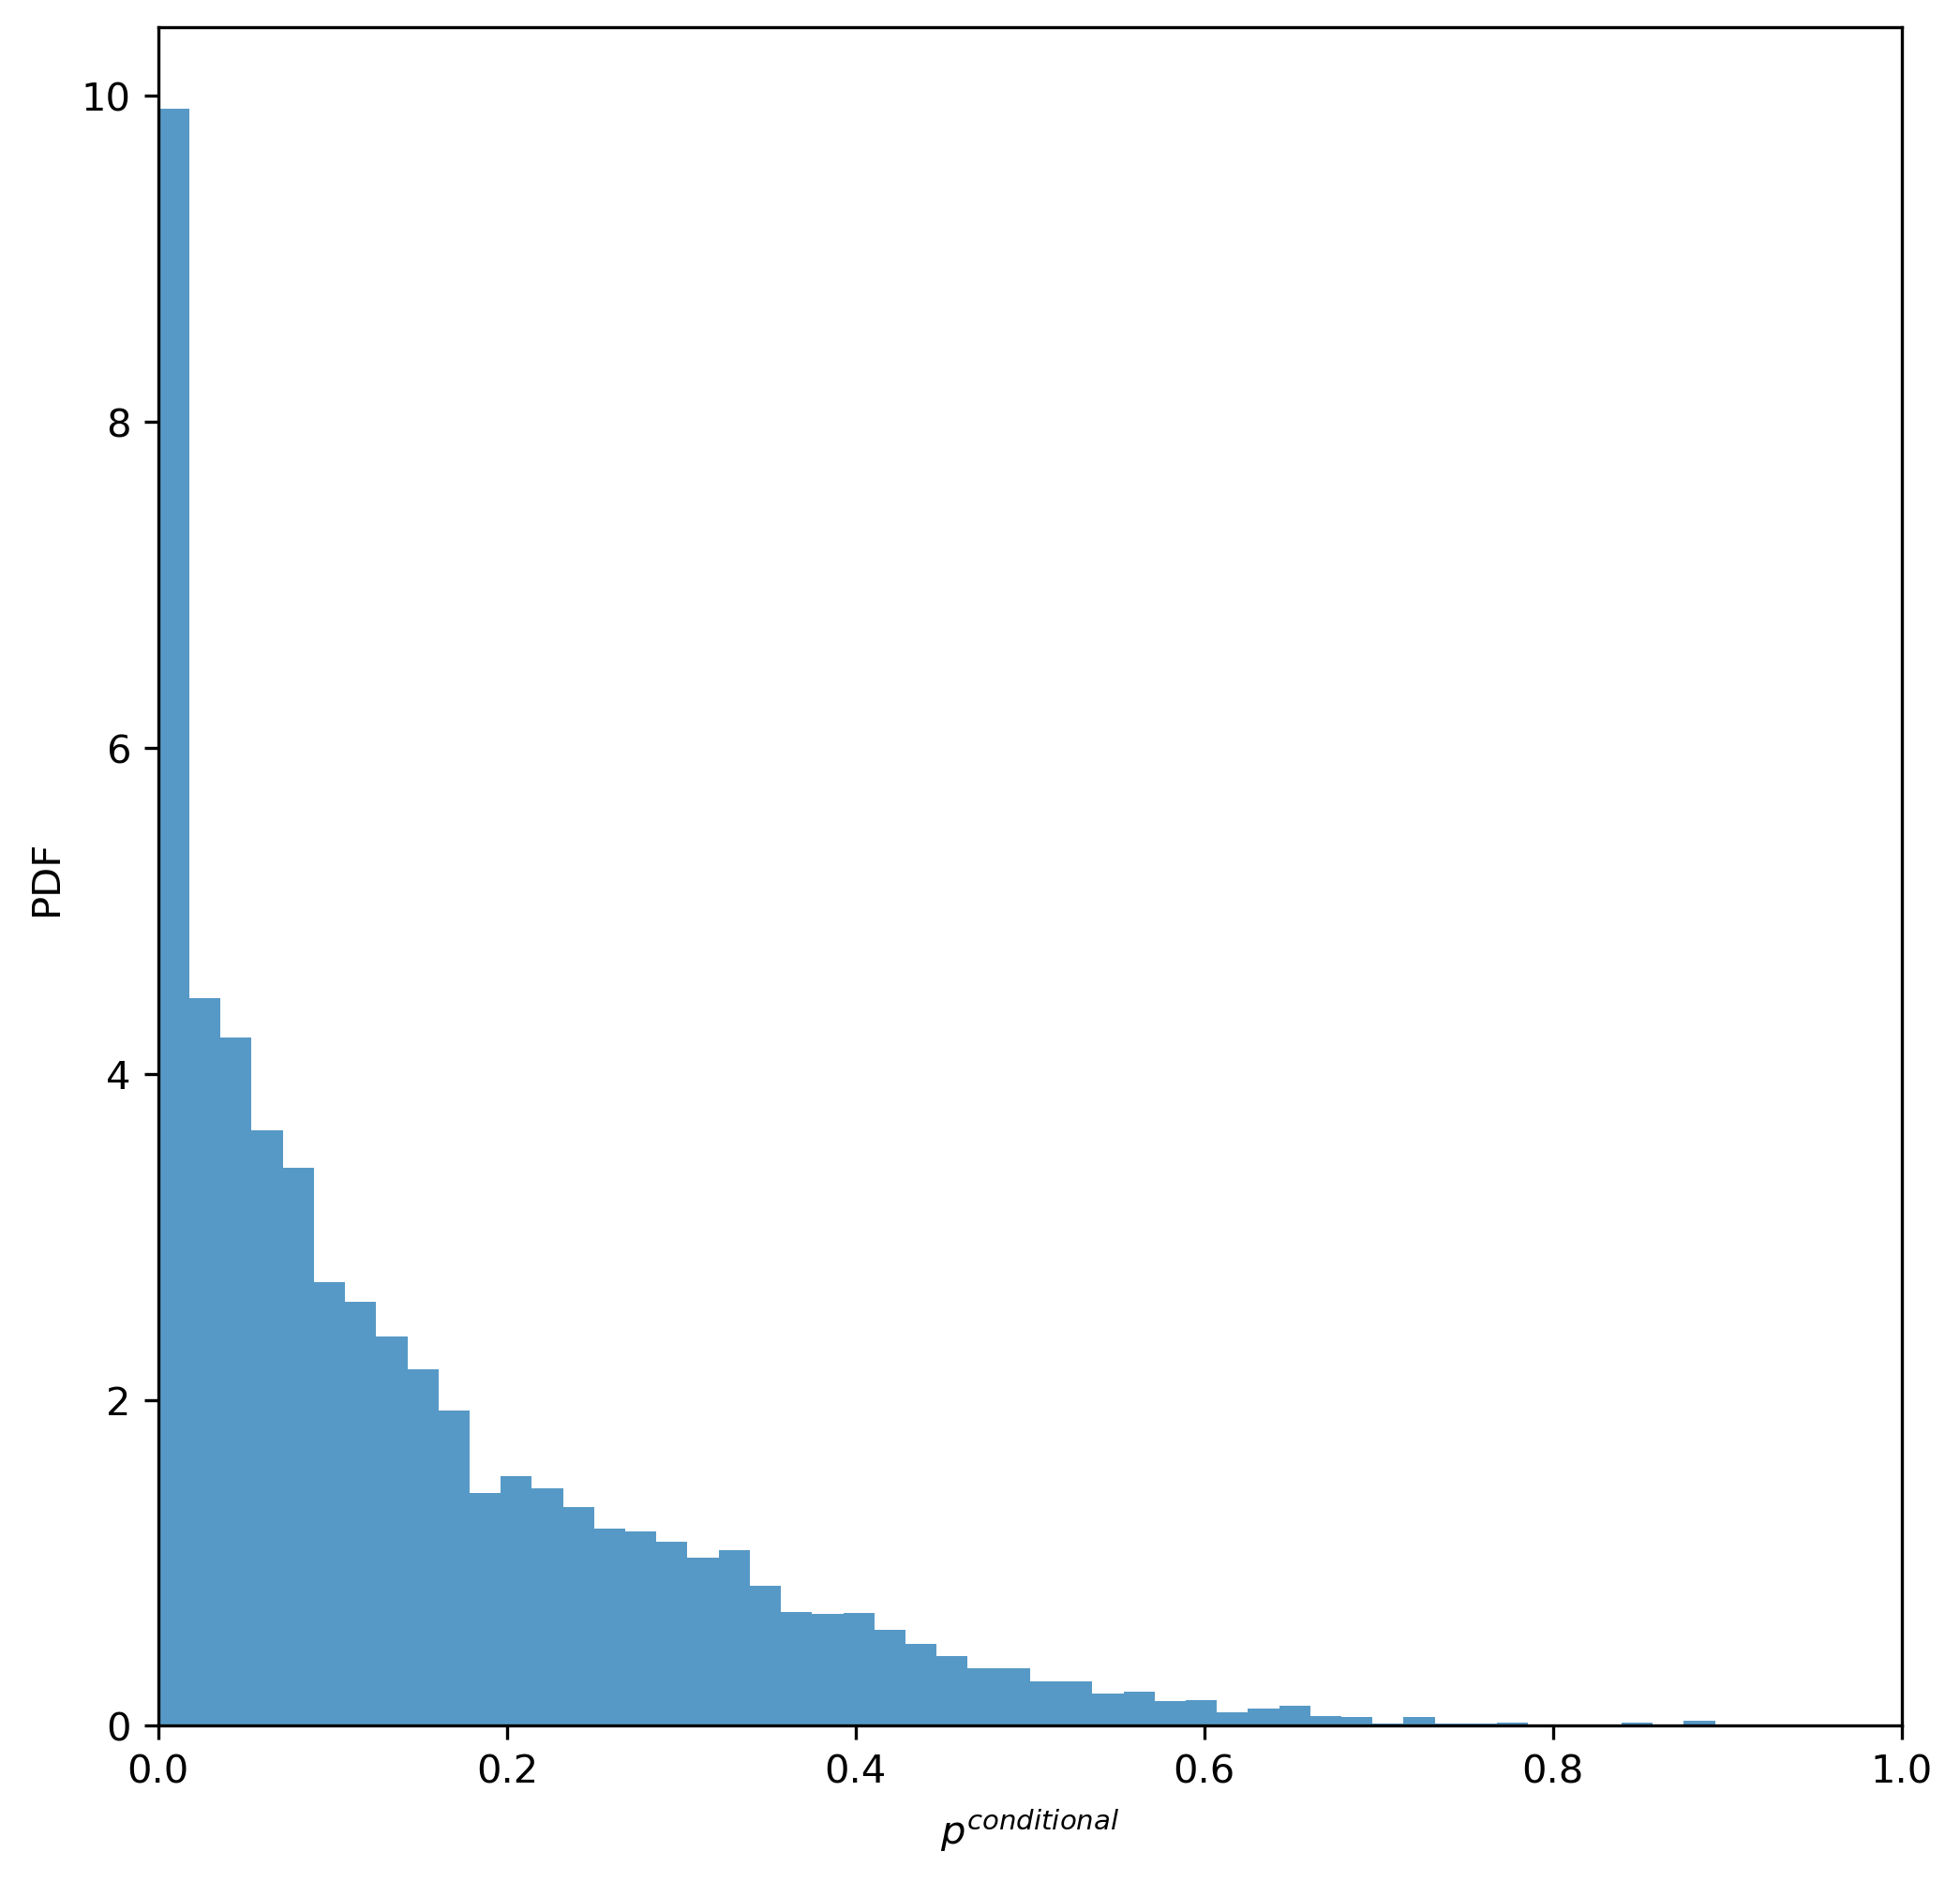

In [11]:
run_configuration_model(network_dataPois)

## Power-law without correlation

100%|█████████████████████████████████████████████████████████████████████████████| 165/165 [00:00<00:00, 10972.54it/s]
C:\Users\Ayan\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Correlation between k and <Kd>:  SpearmanrResult(correlation=0.04736195335666391, pvalue=0.5457842051266477)


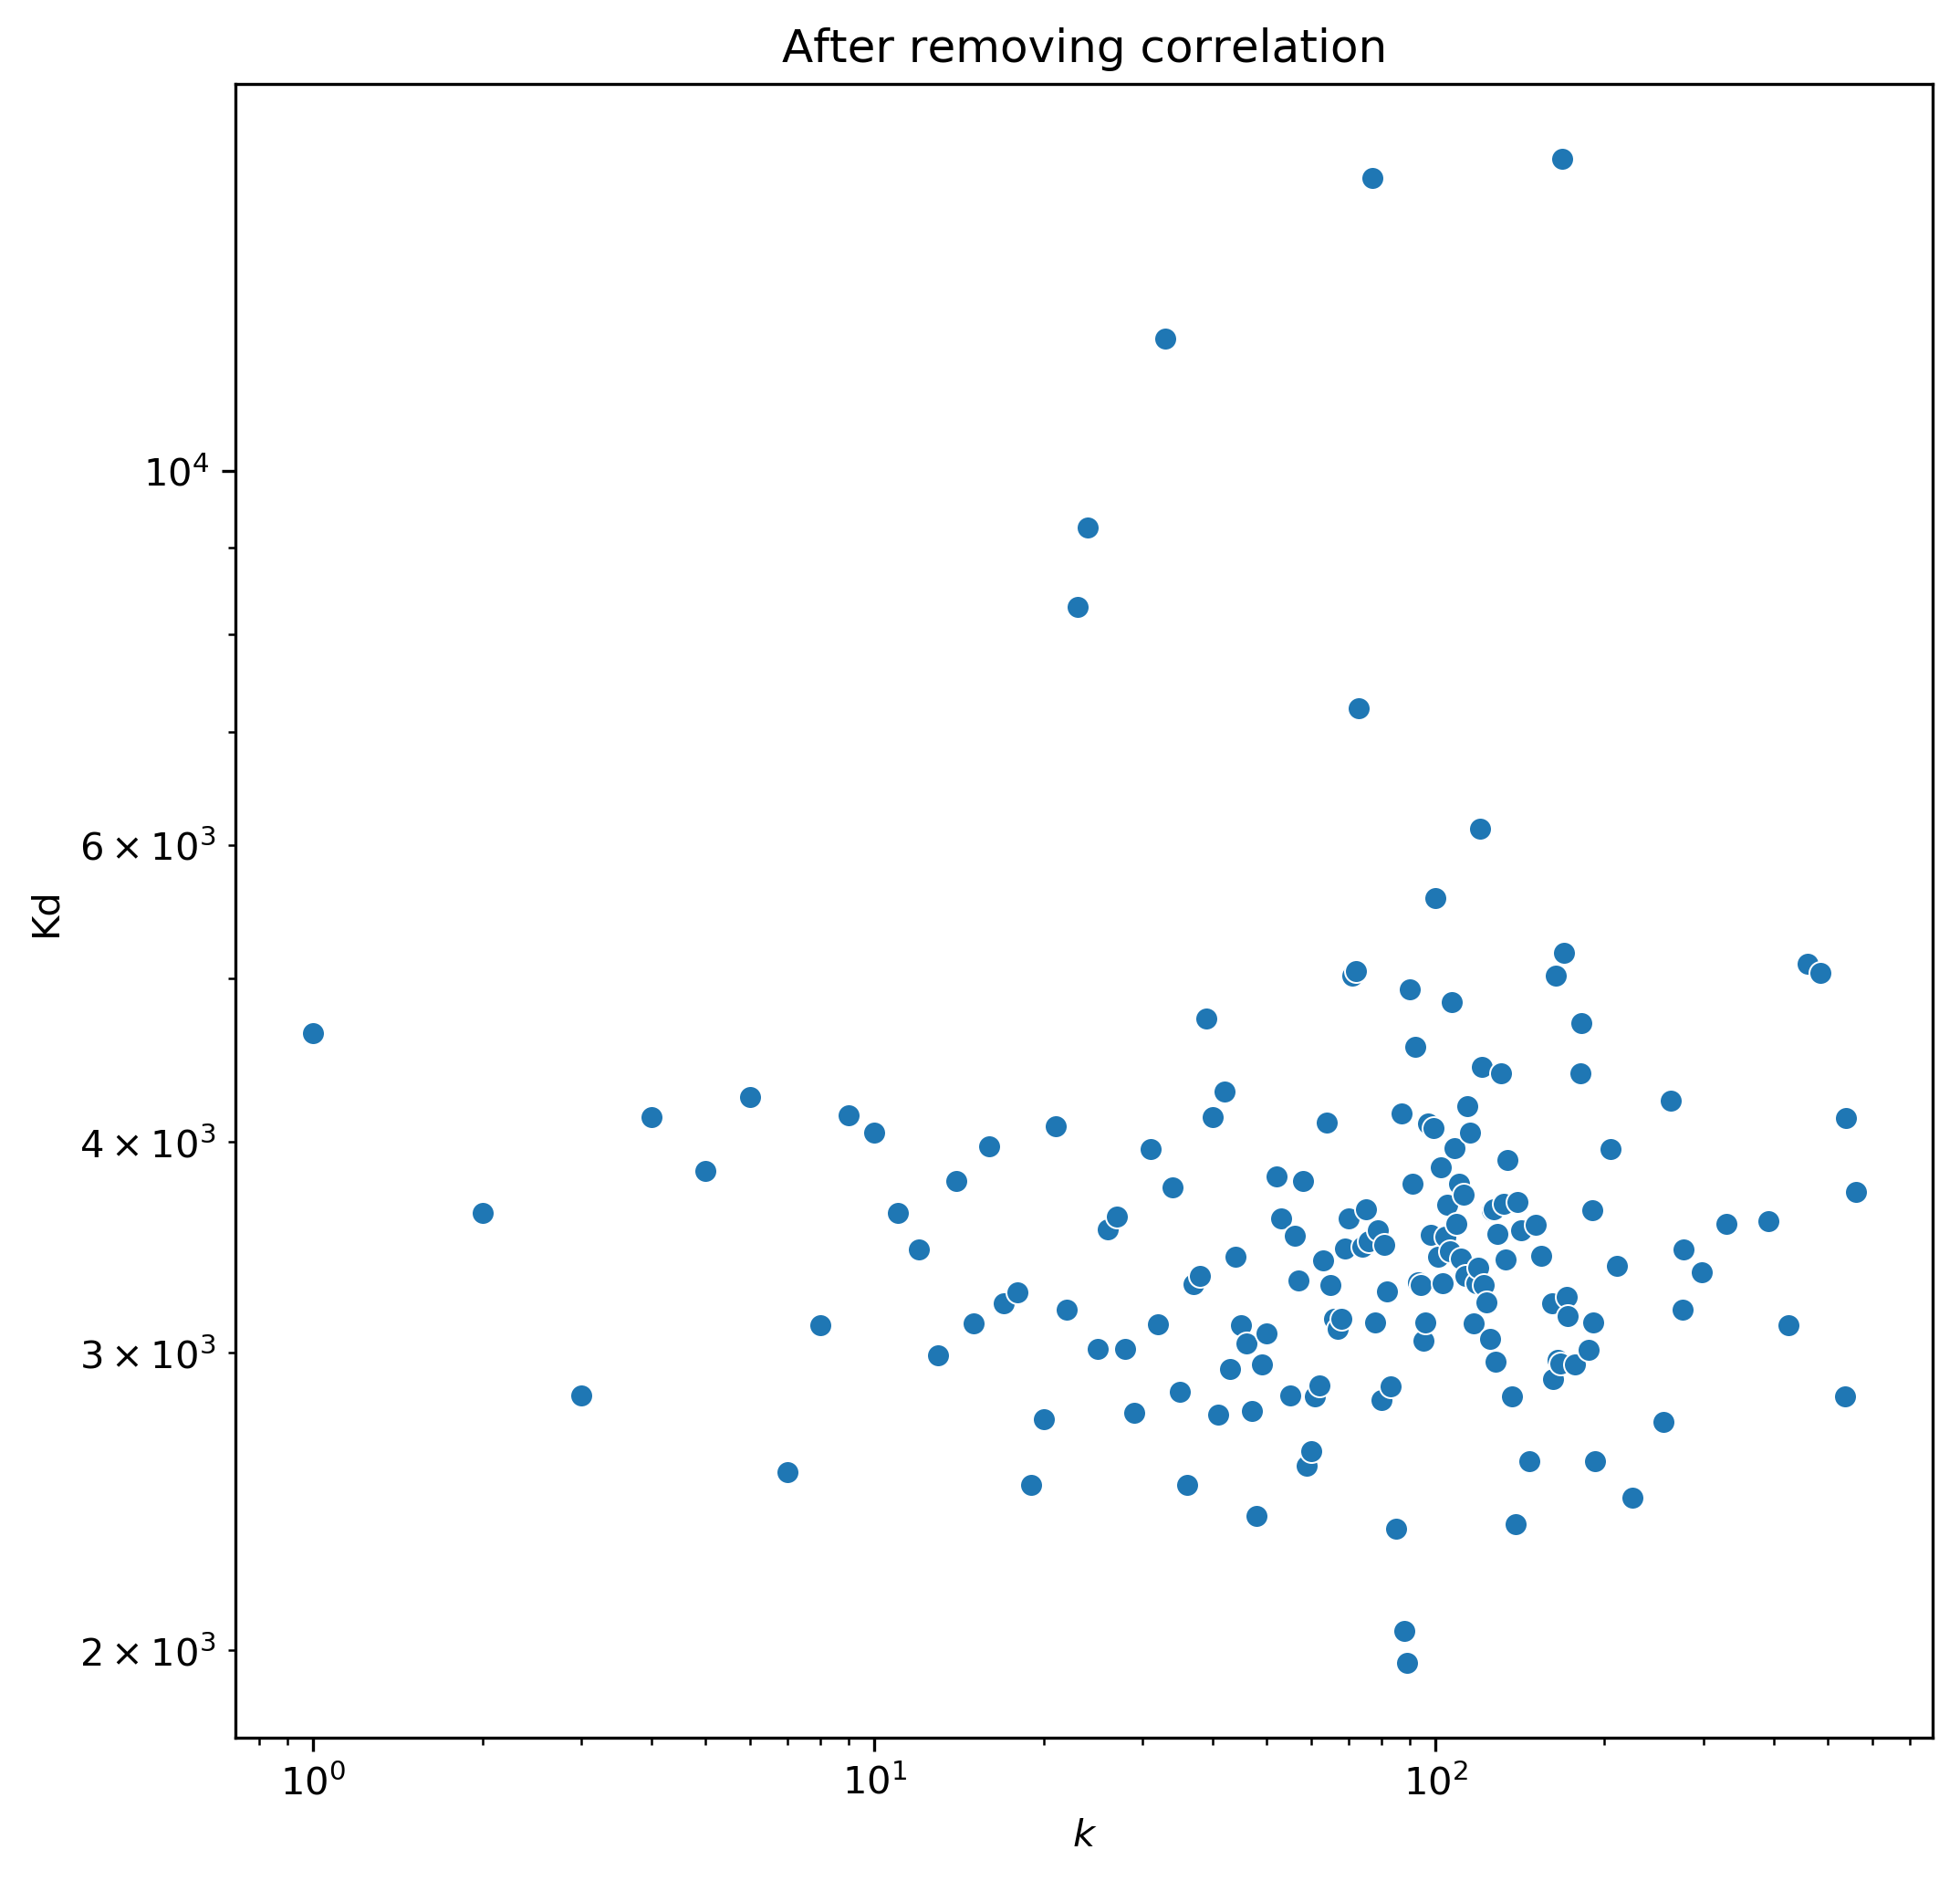

C:\Users\Ayan\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


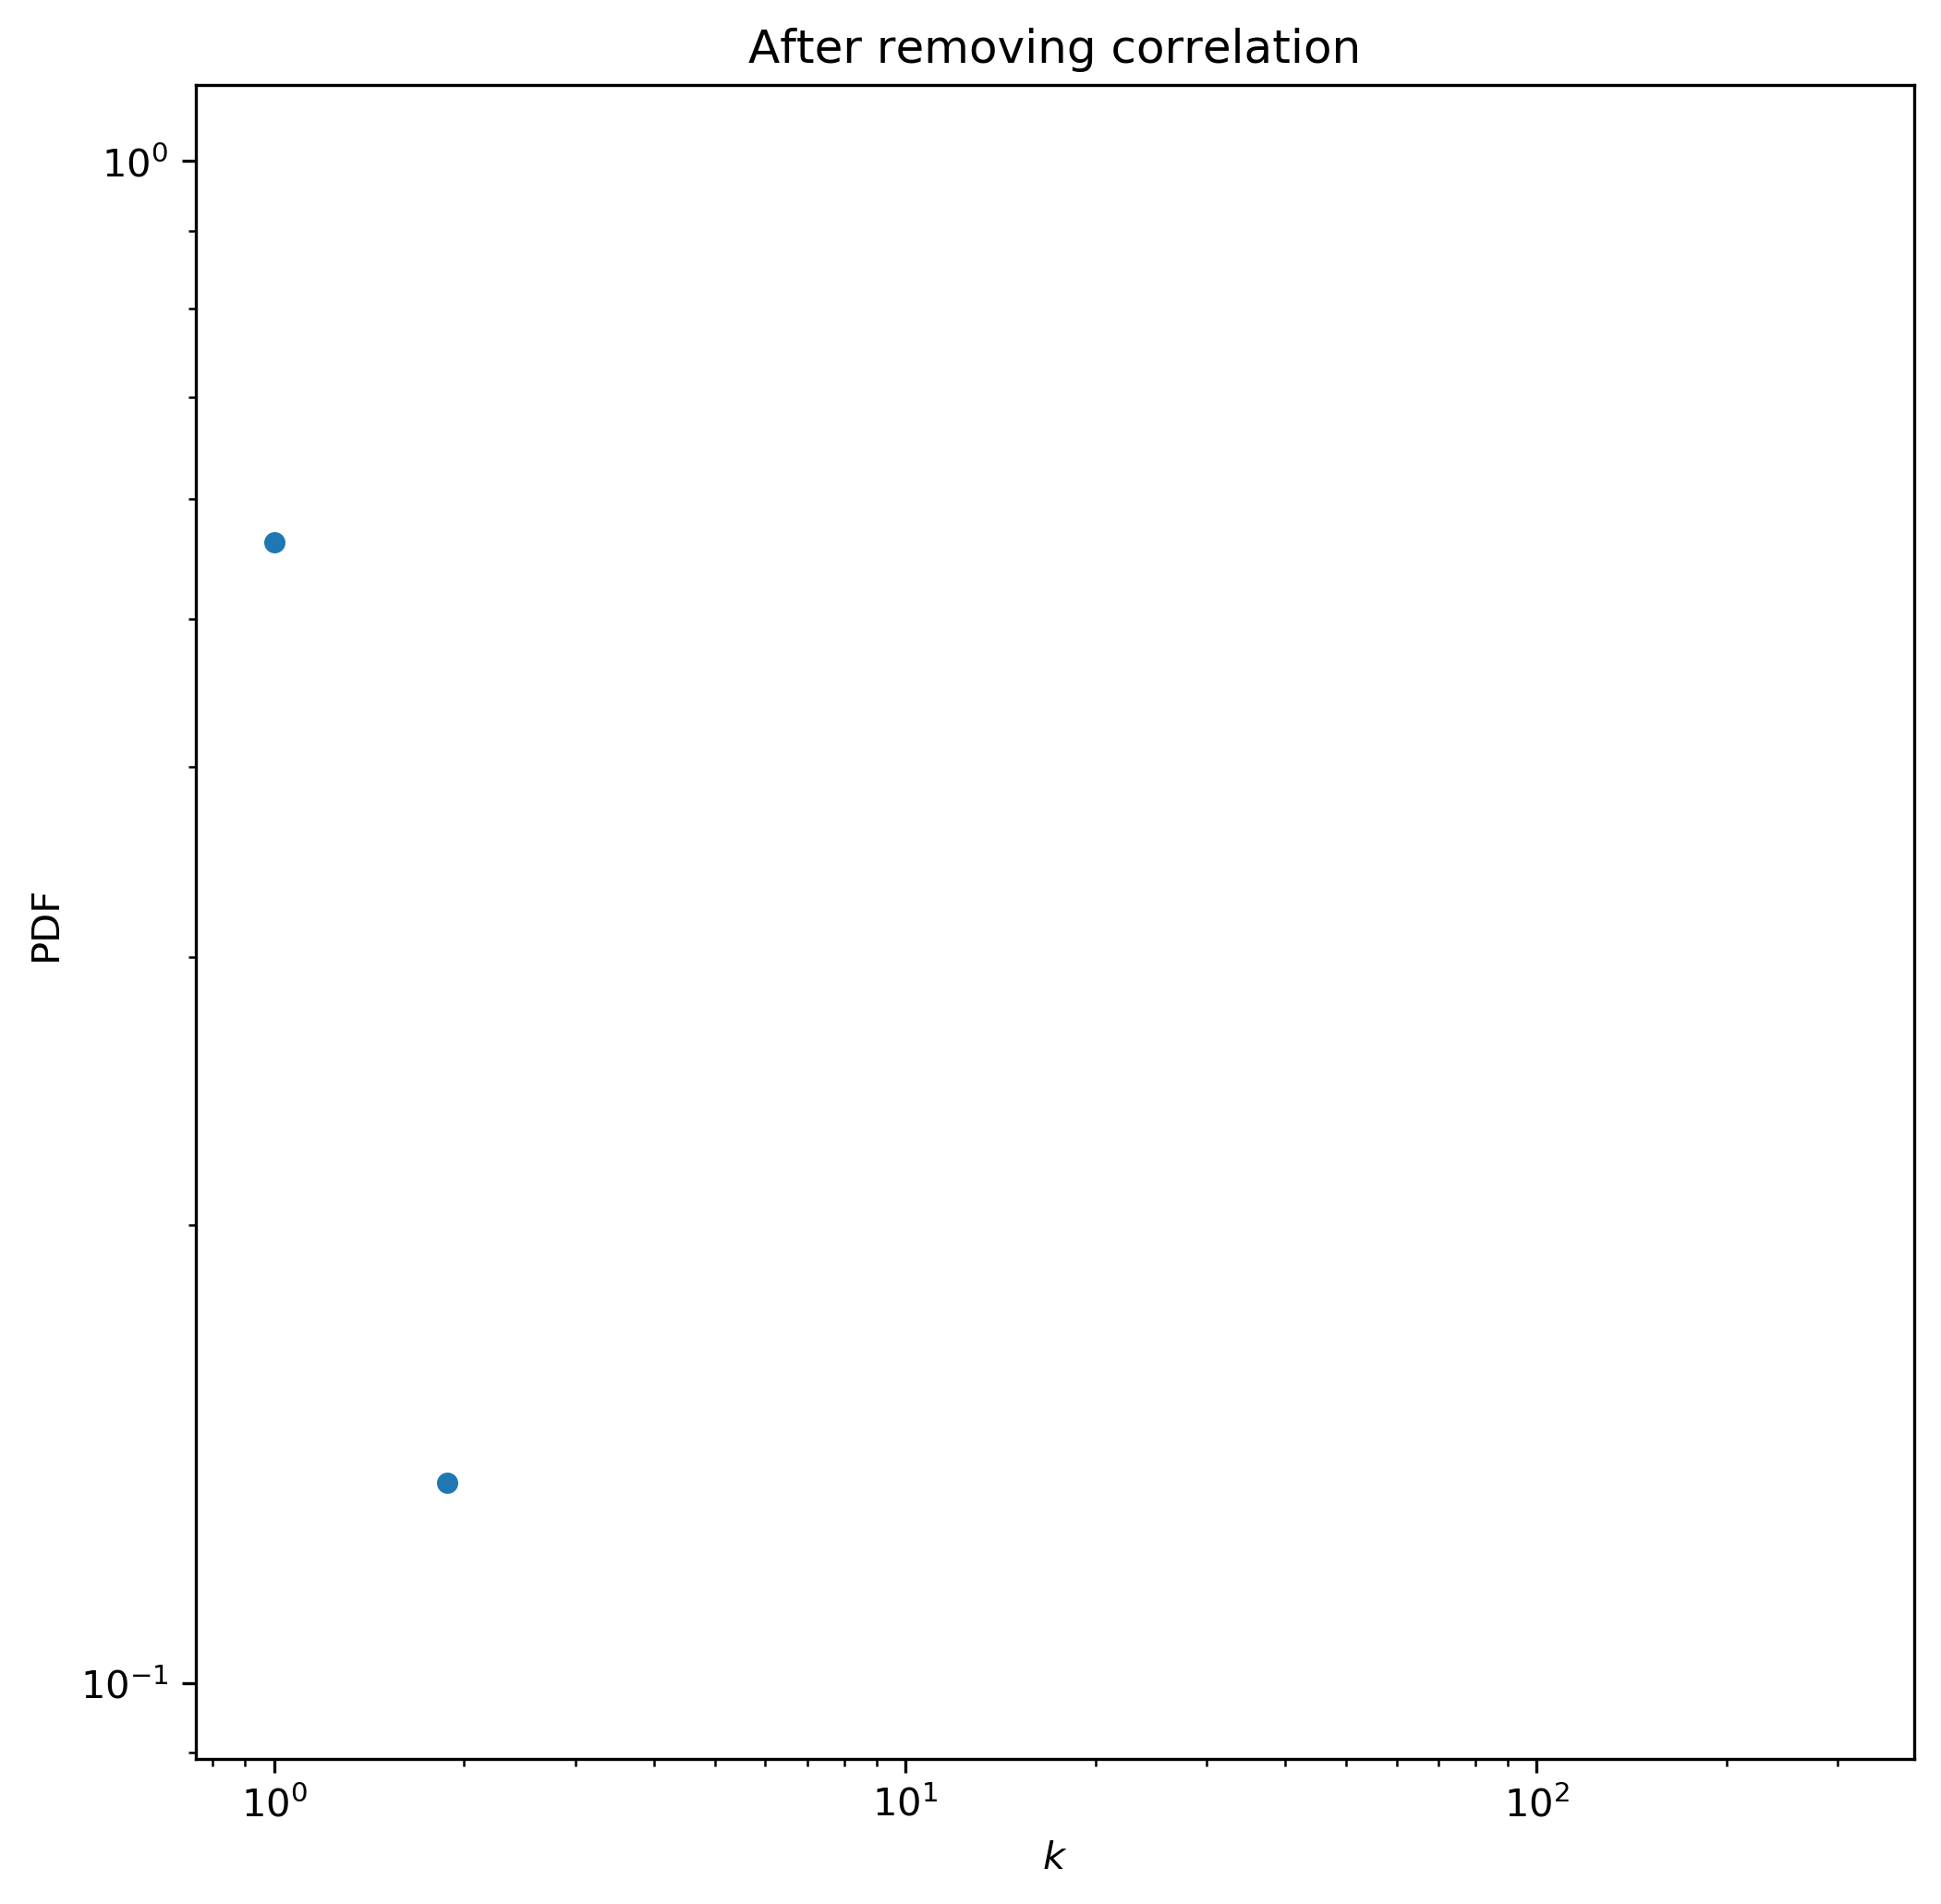

100%|█████████████████████████████████████████████████████████████████████████████| 1380/1380 [00:02<00:00, 549.18it/s]


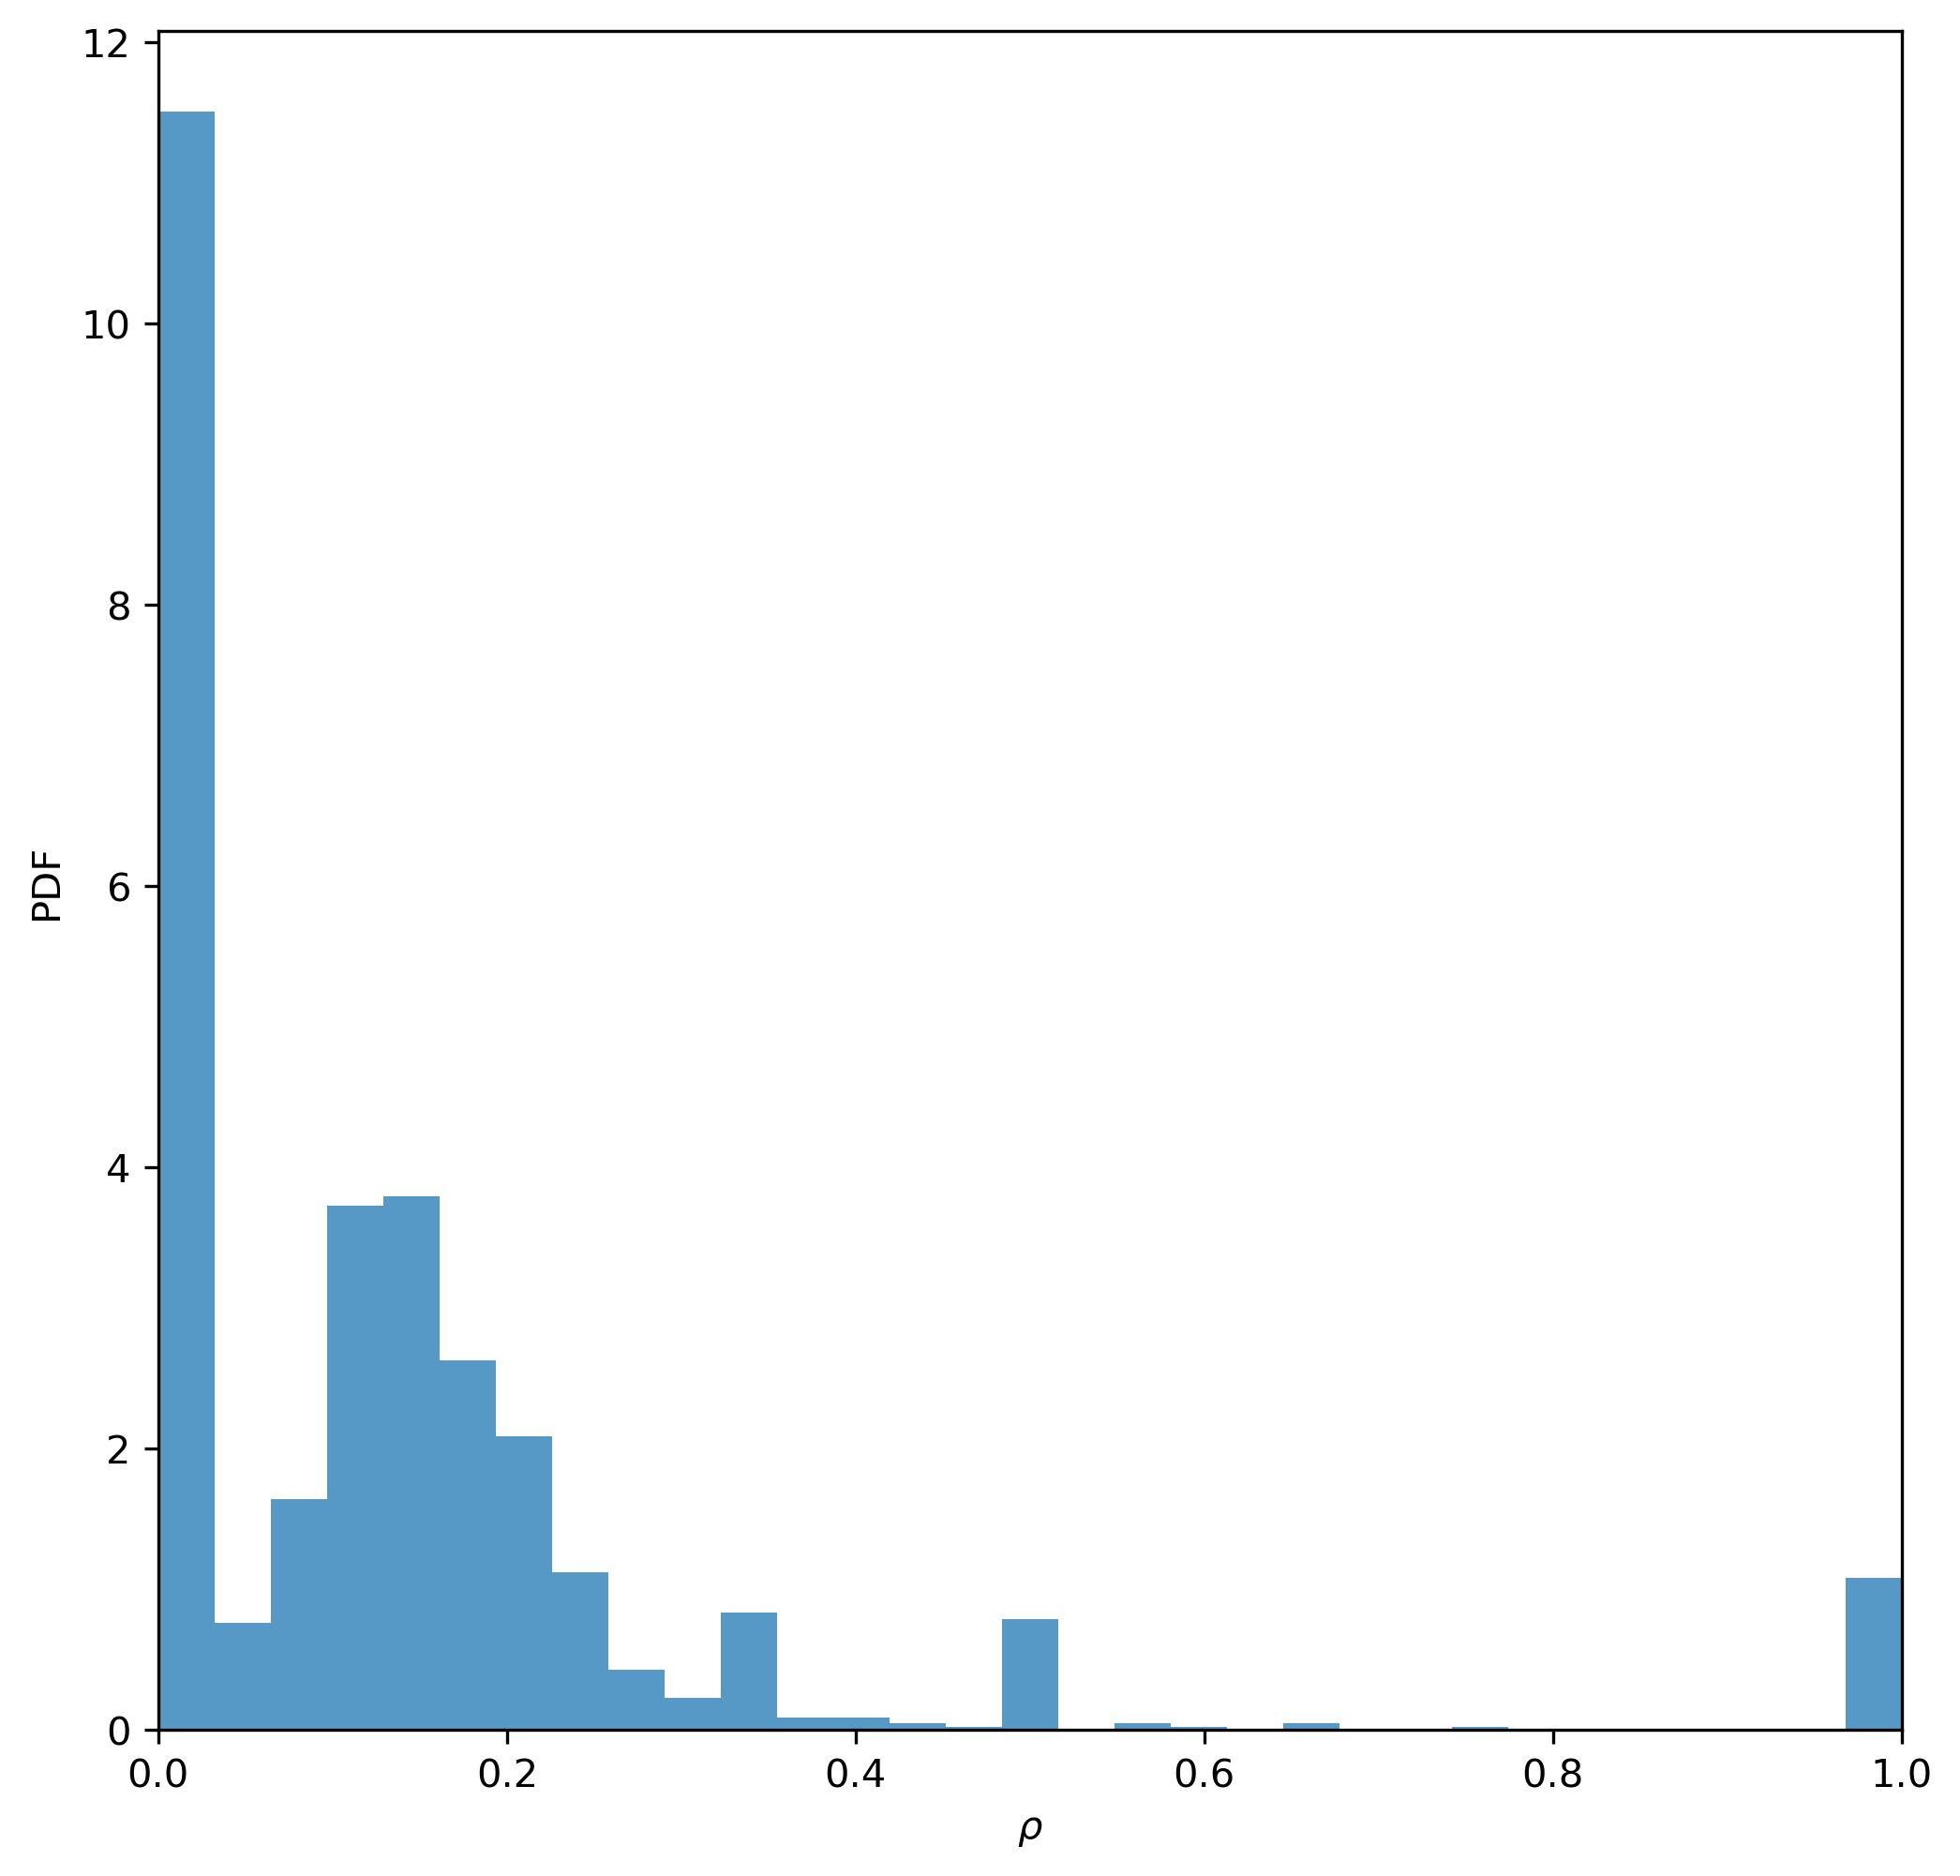

Number of nodes with not positive or negative annotation:  0
Validating p_bind value from binary labels:  0.14262730833799664


  1%|▋                                                                              | 93/10000 [00:08<15:43, 10.51it/s]


Loops  94
Error margin:  [9.6143879e-06]


8578it [00:03, 2282.93it/s]


AUC:  0.4950233733142807
AUP:  0.13704792219173392
Transductive performance:
AUC:  0.4955070121880111
AUP:  0.13747739878600468


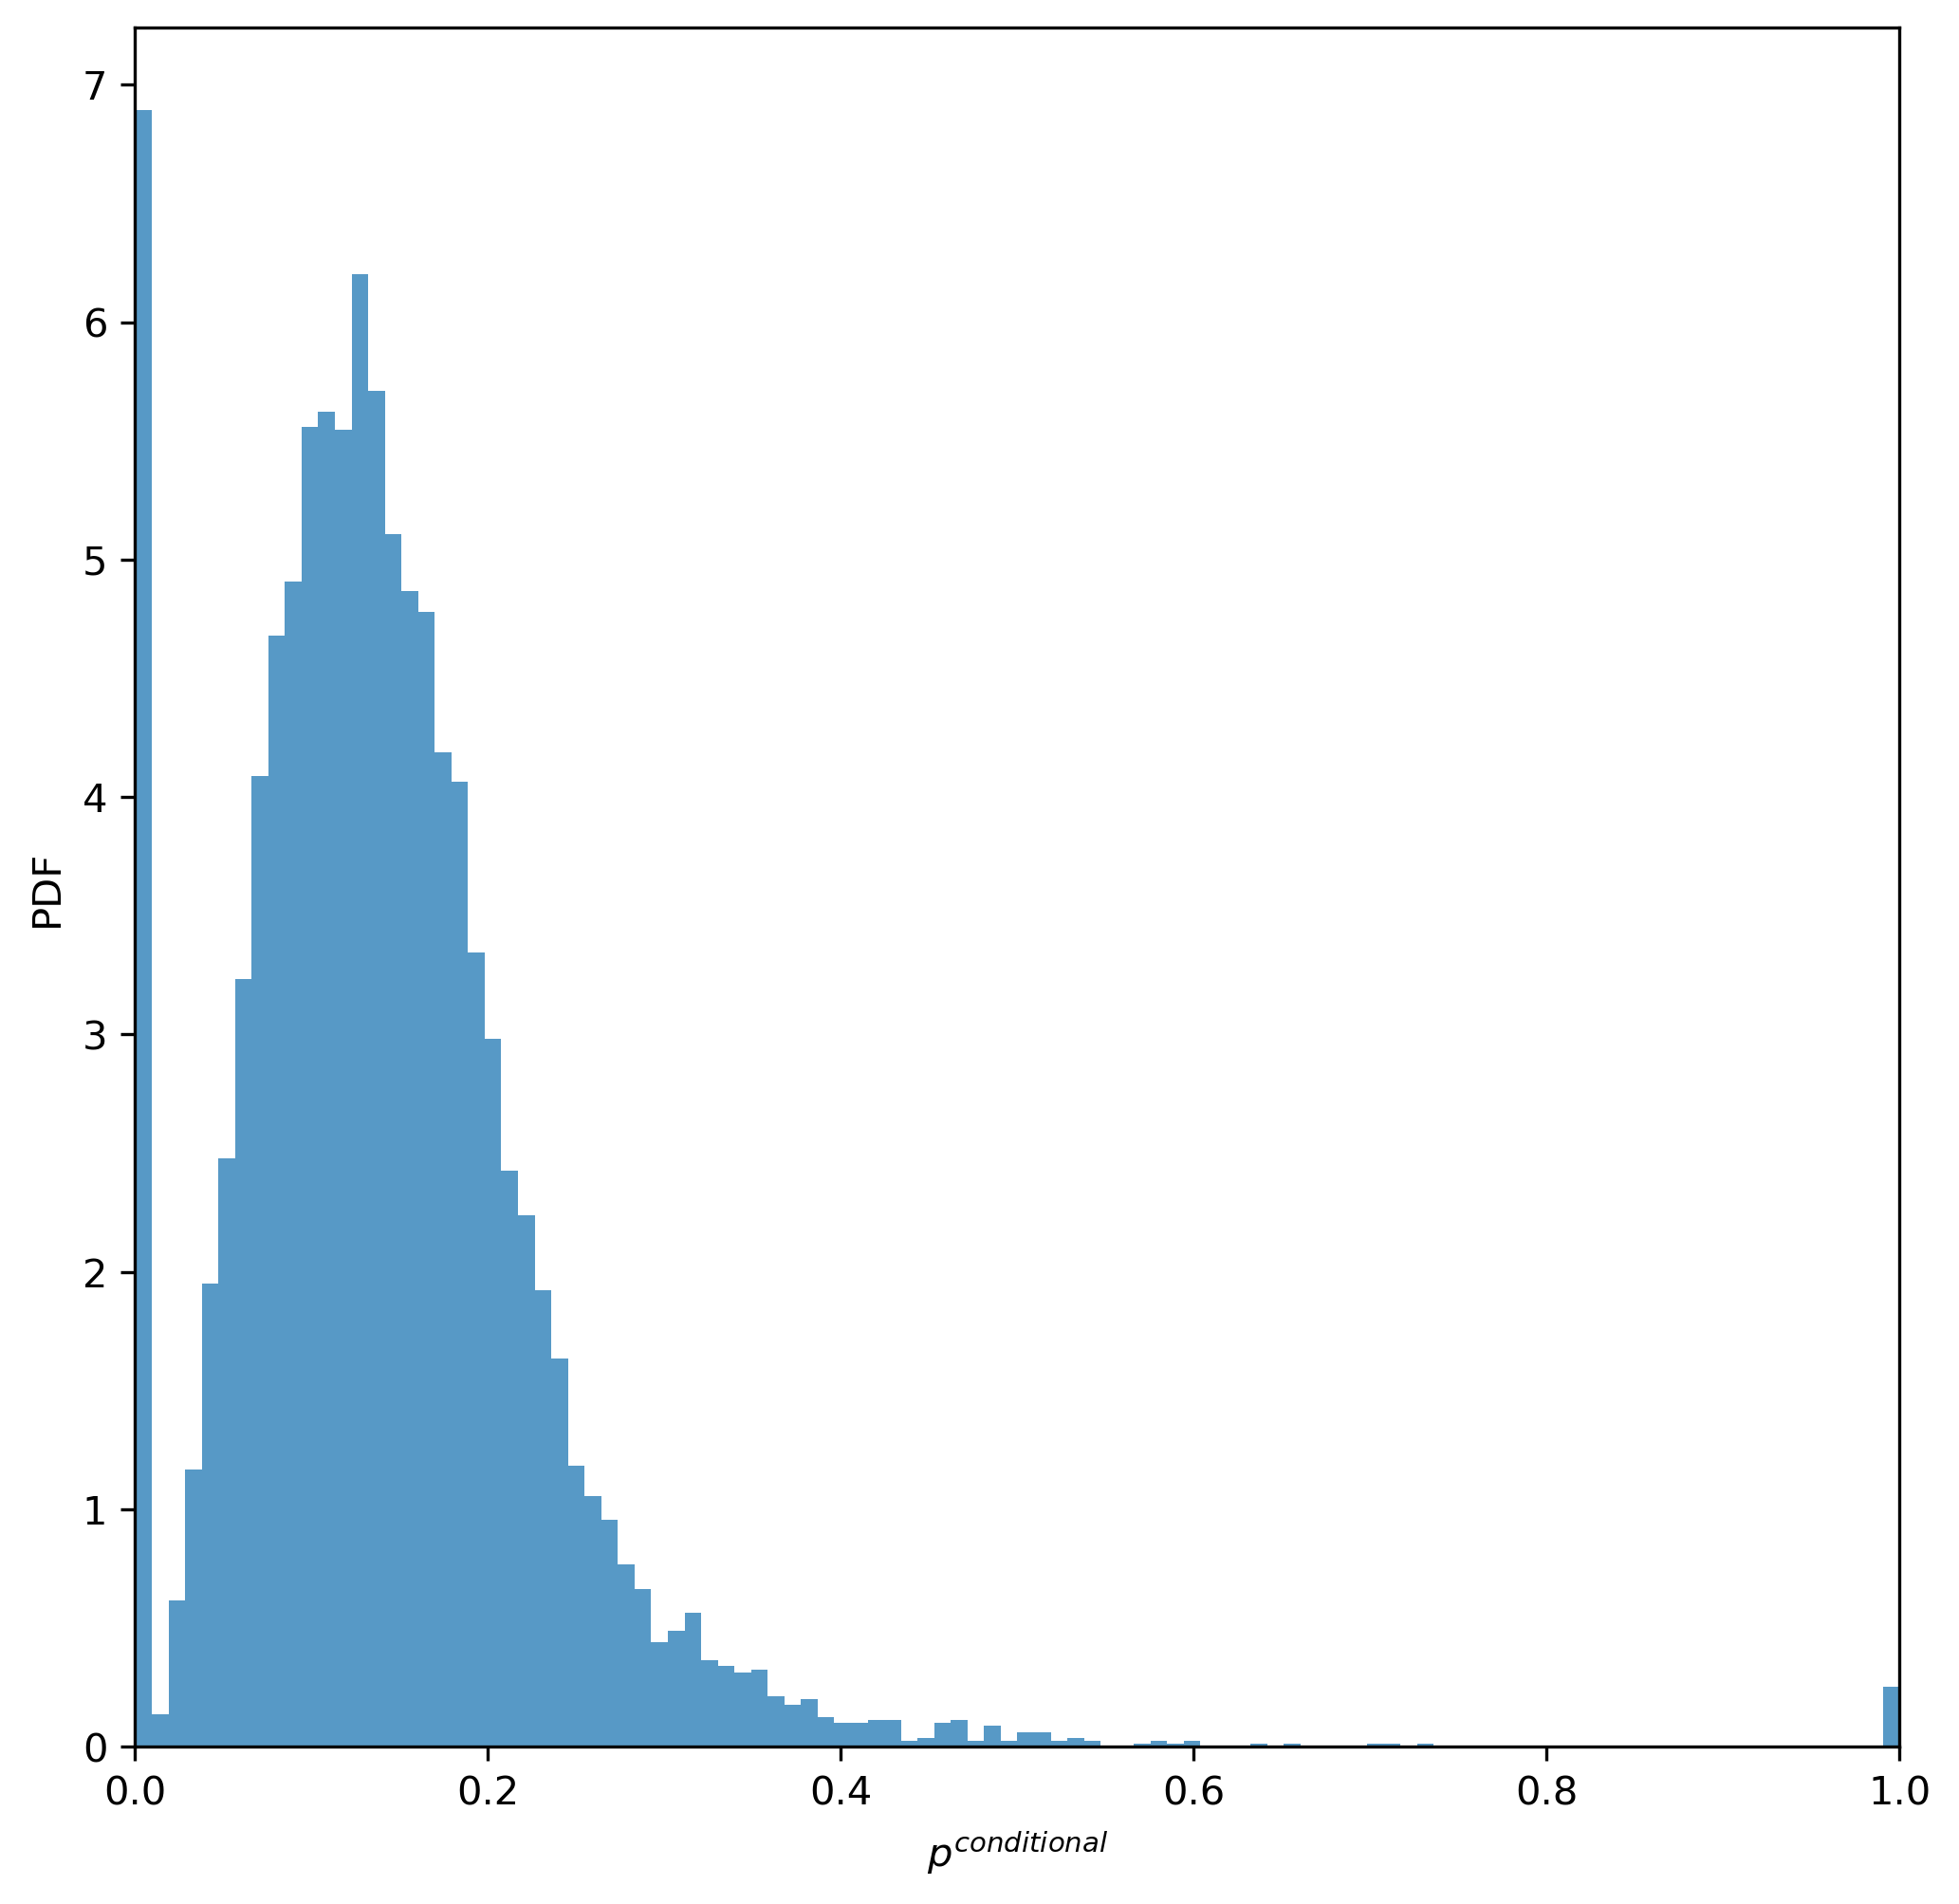

In [12]:
network_dataOrig_shuffled = remove_correlation_run_configuration_model(network_dataOrig, precision=10**(-5), loops=10000)

# Poisson without correlation

100%|███████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 10455.27it/s]
C:\Users\Ayan\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Correlation between k and <Kd>:  SpearmanrResult(correlation=-0.0707398103881371, pvalue=0.6561972457709774)


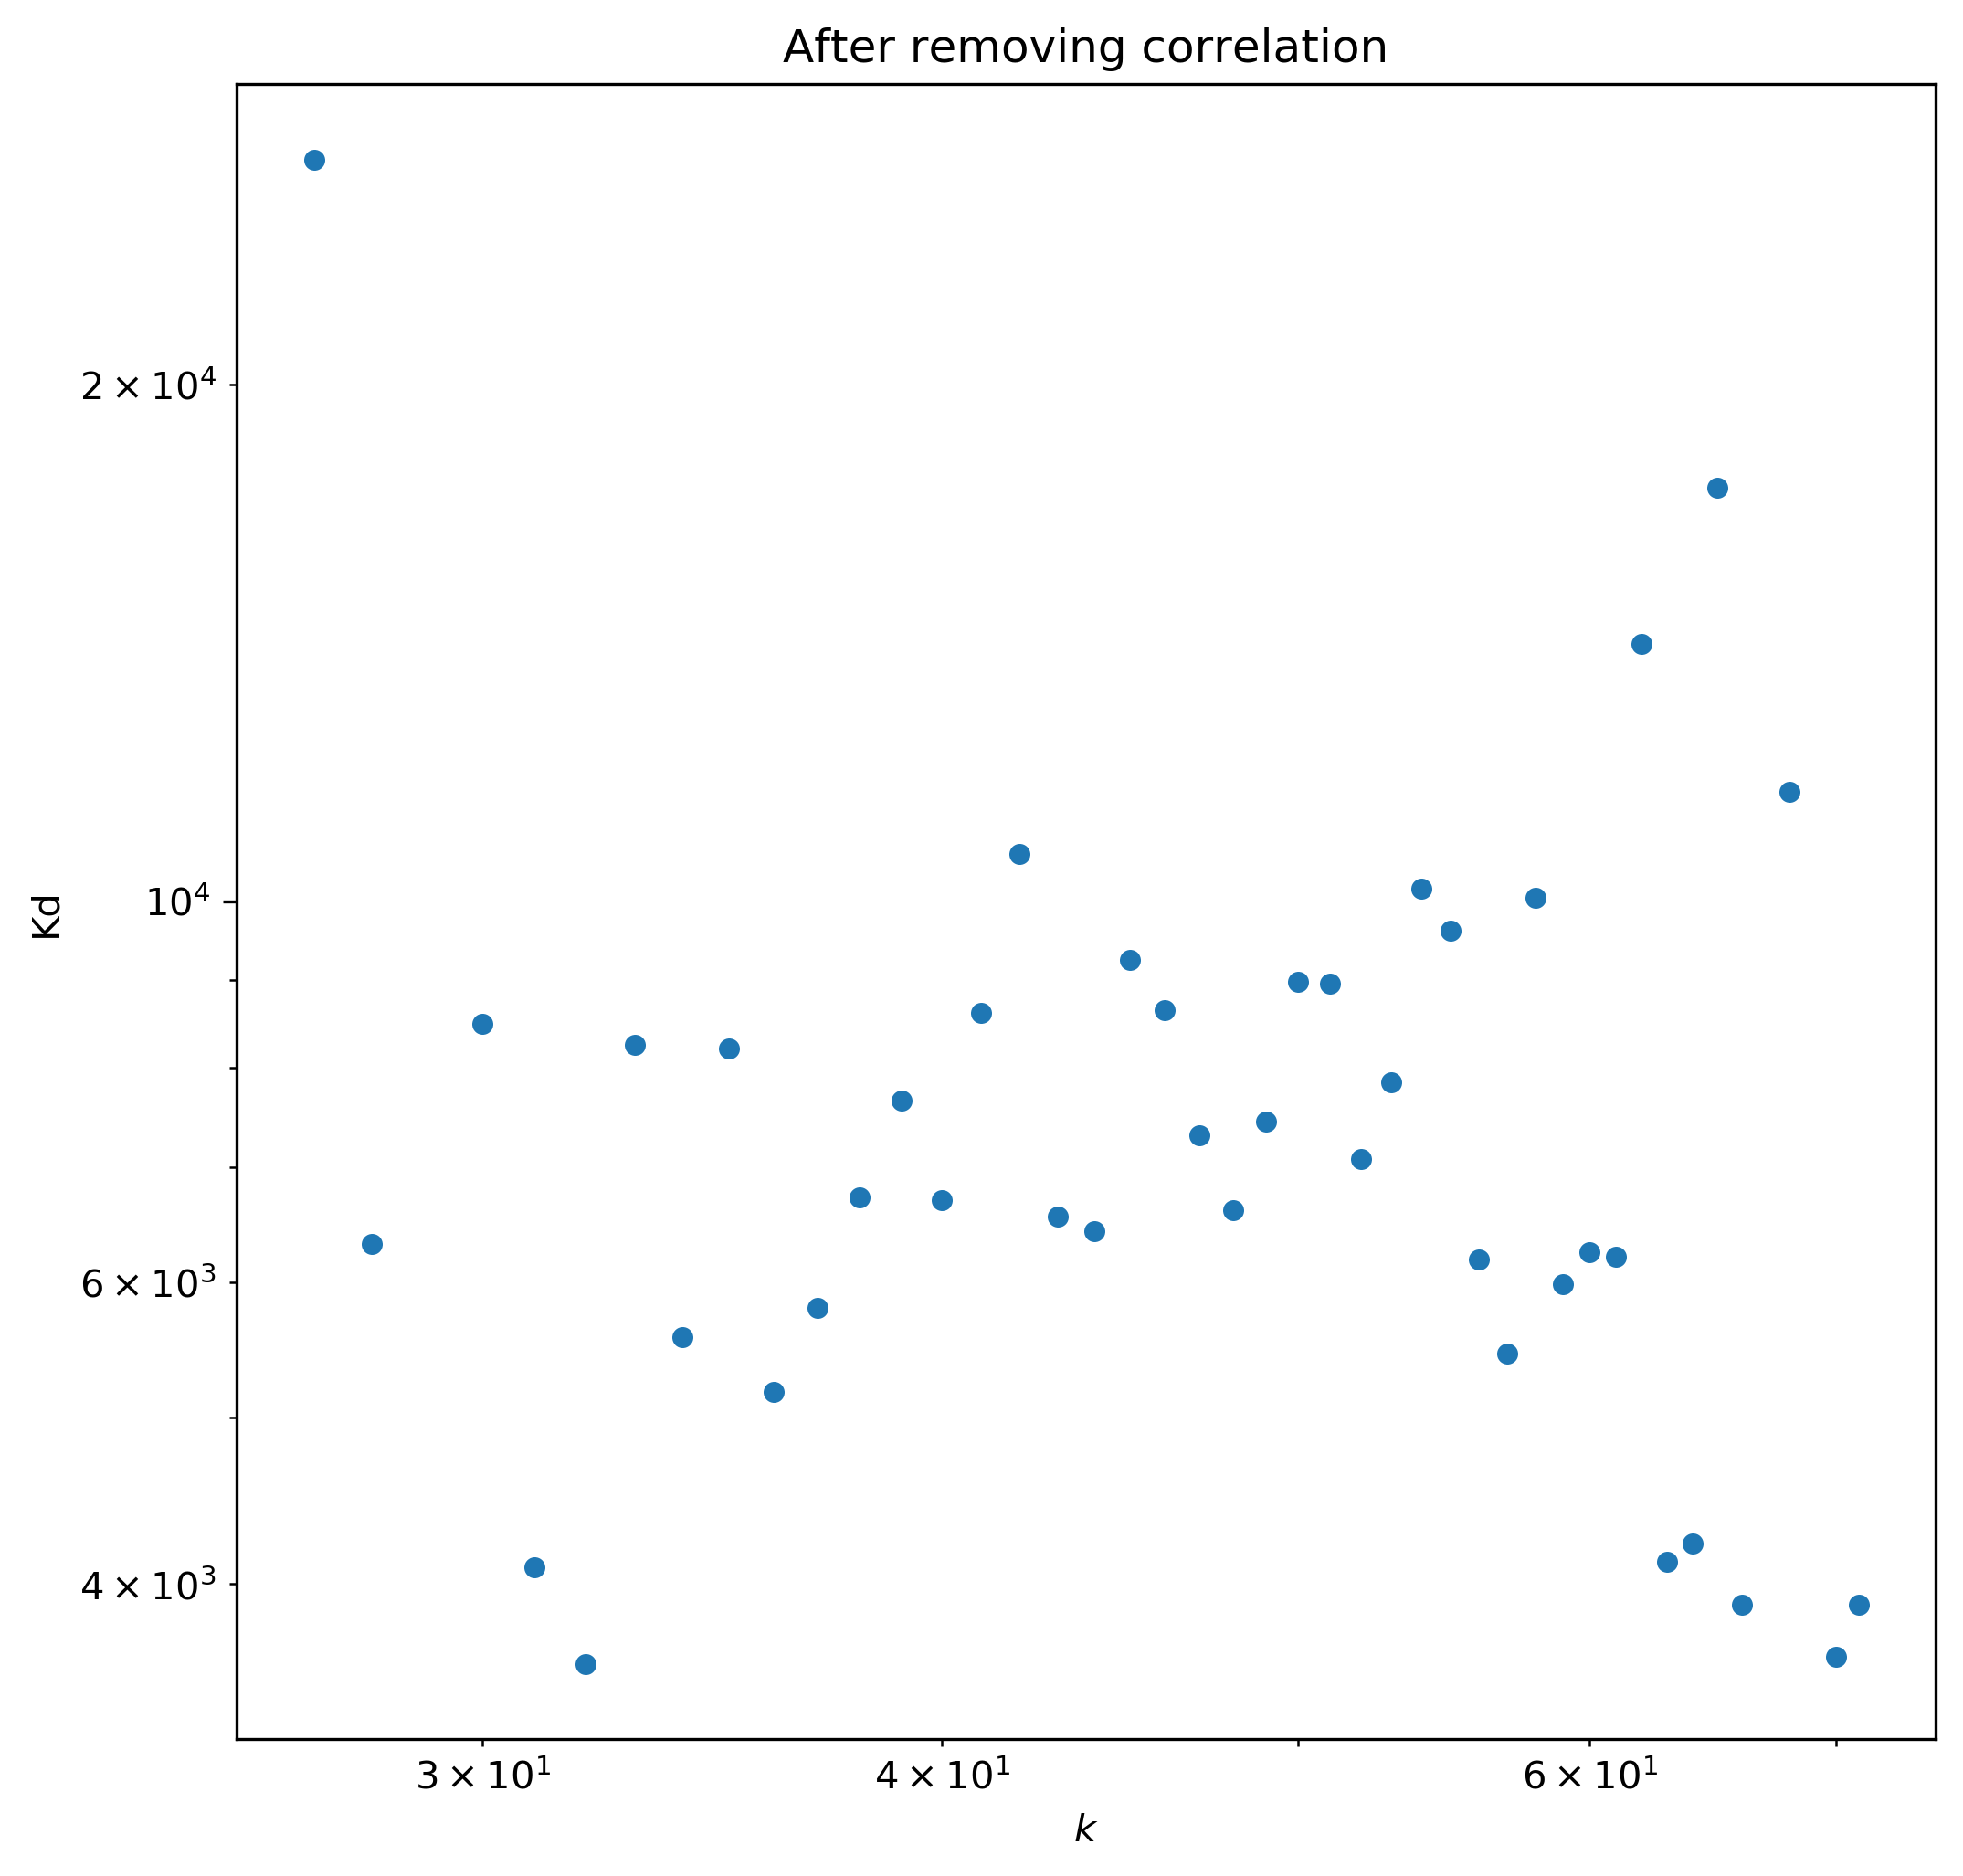

C:\Users\Ayan\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


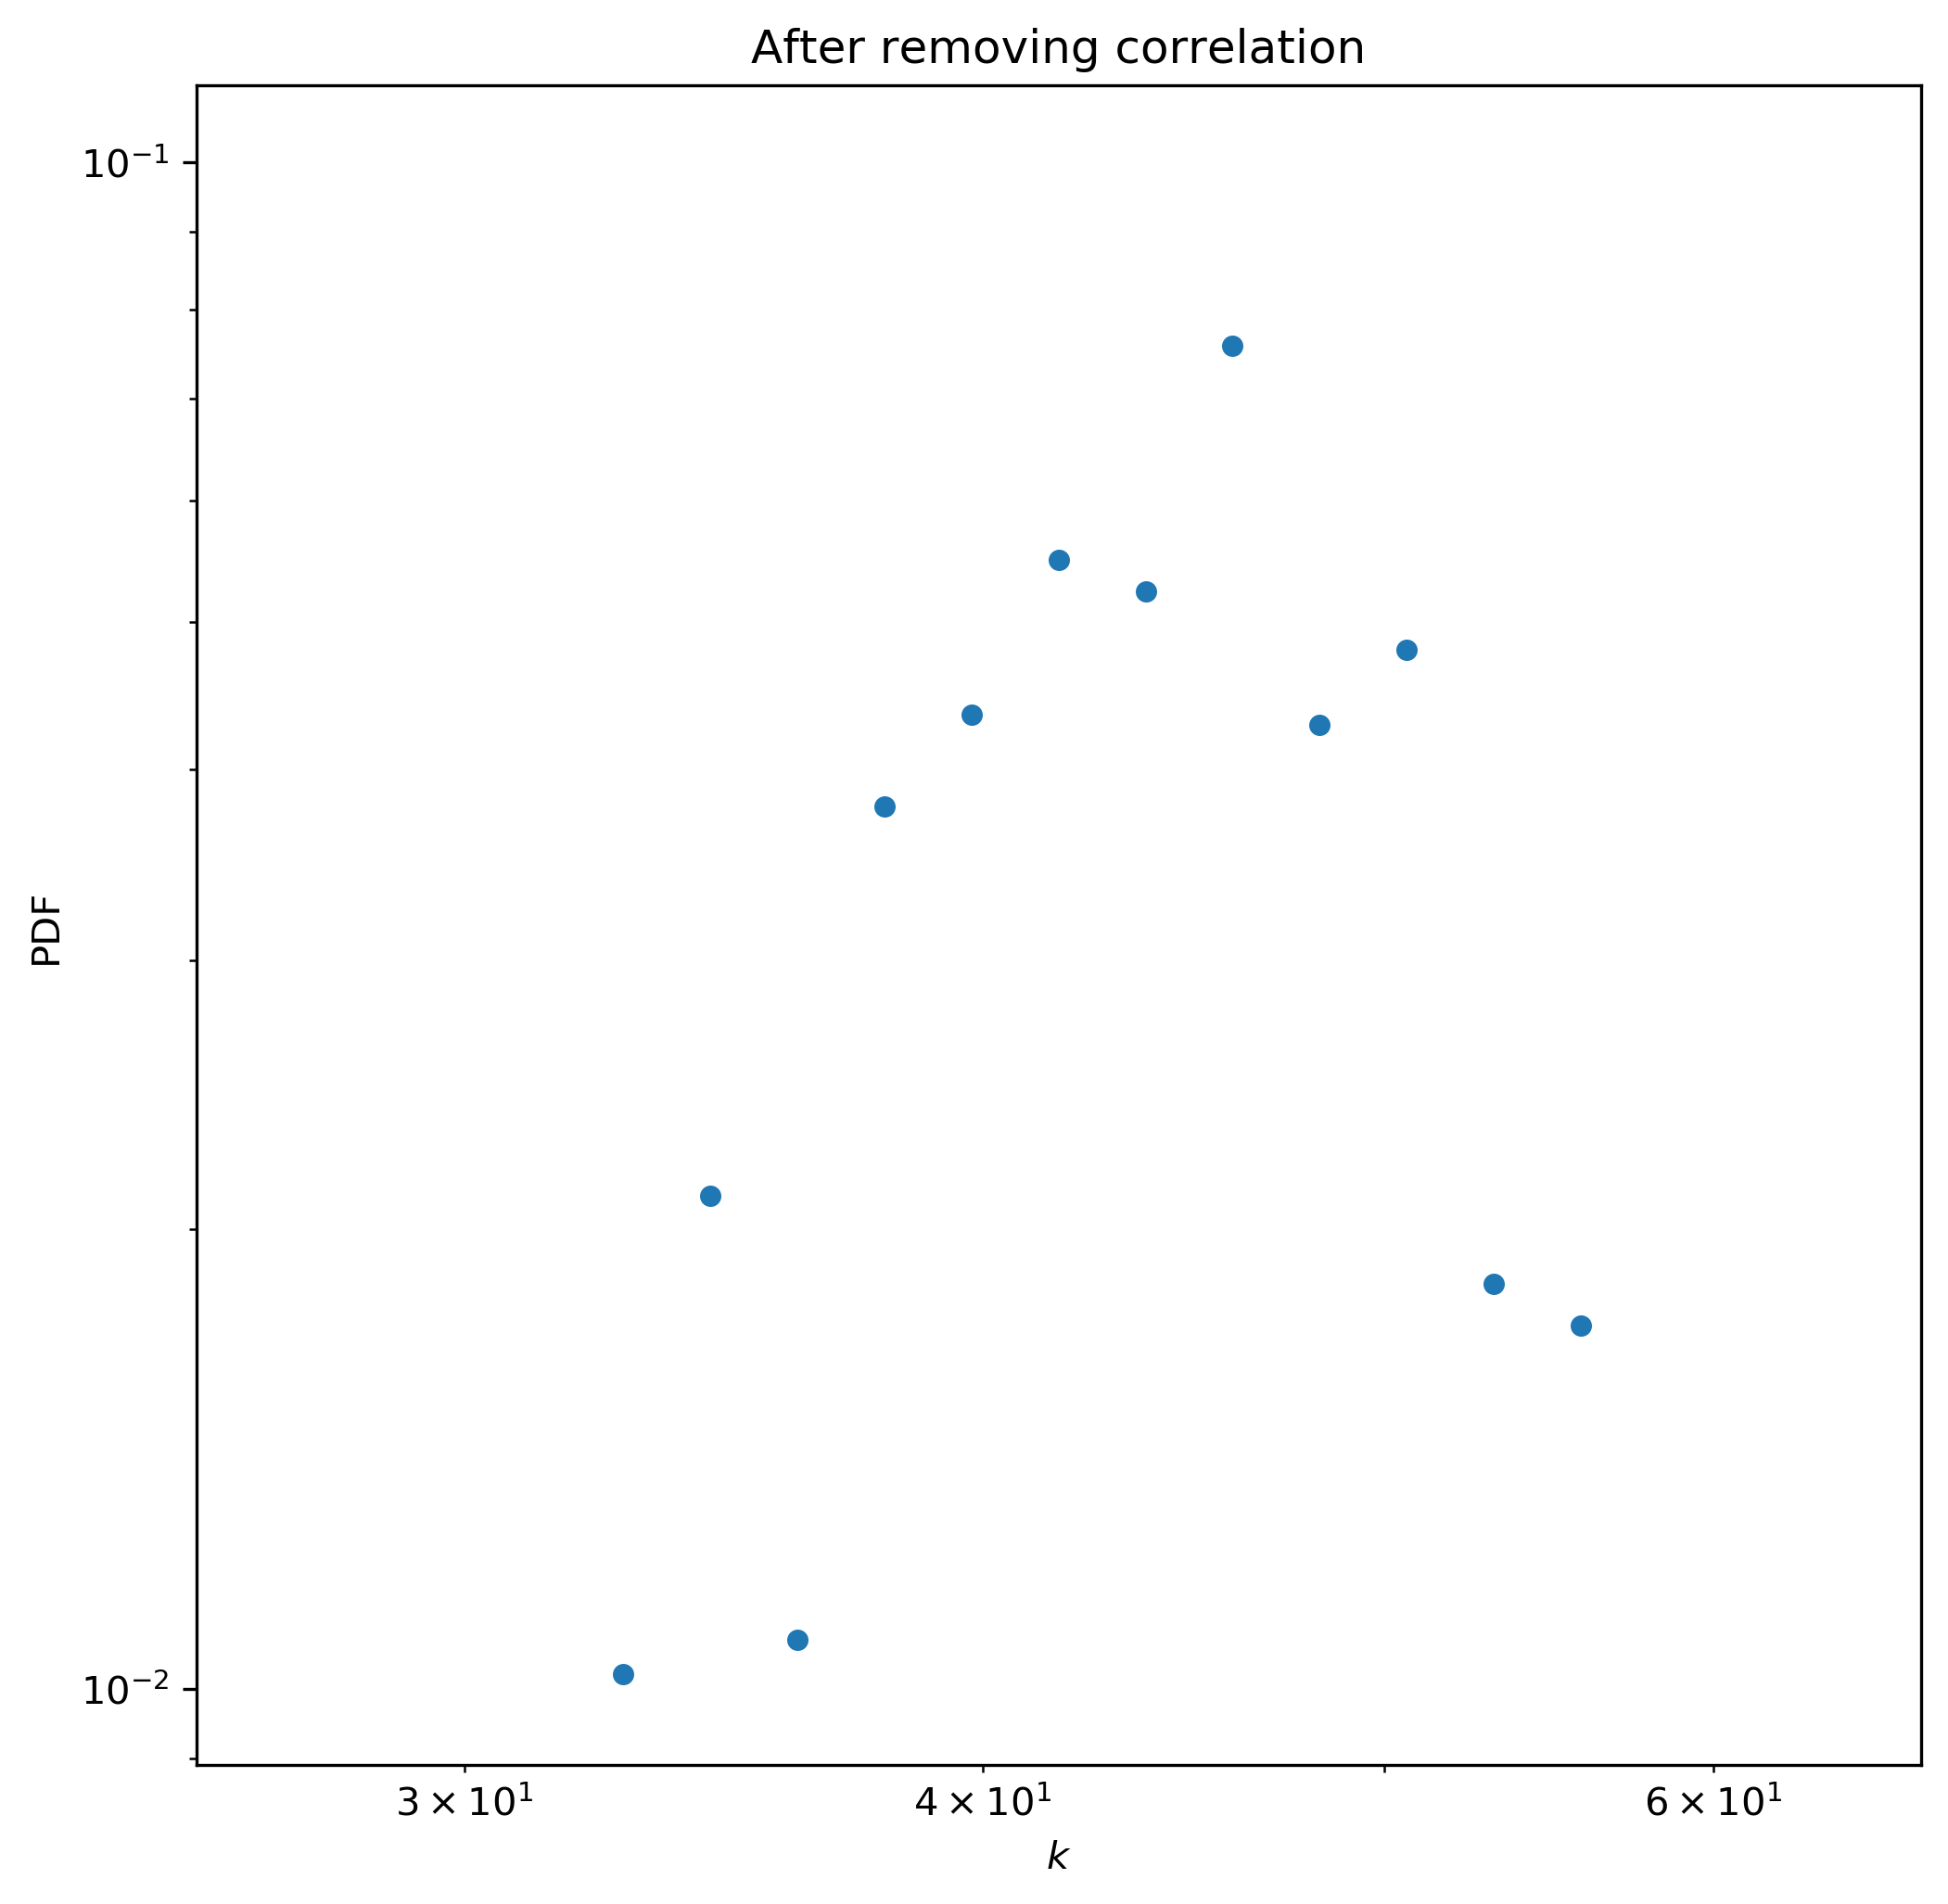

100%|█████████████████████████████████████████████████████████████████████████████| 1507/1507 [00:02<00:00, 572.23it/s]


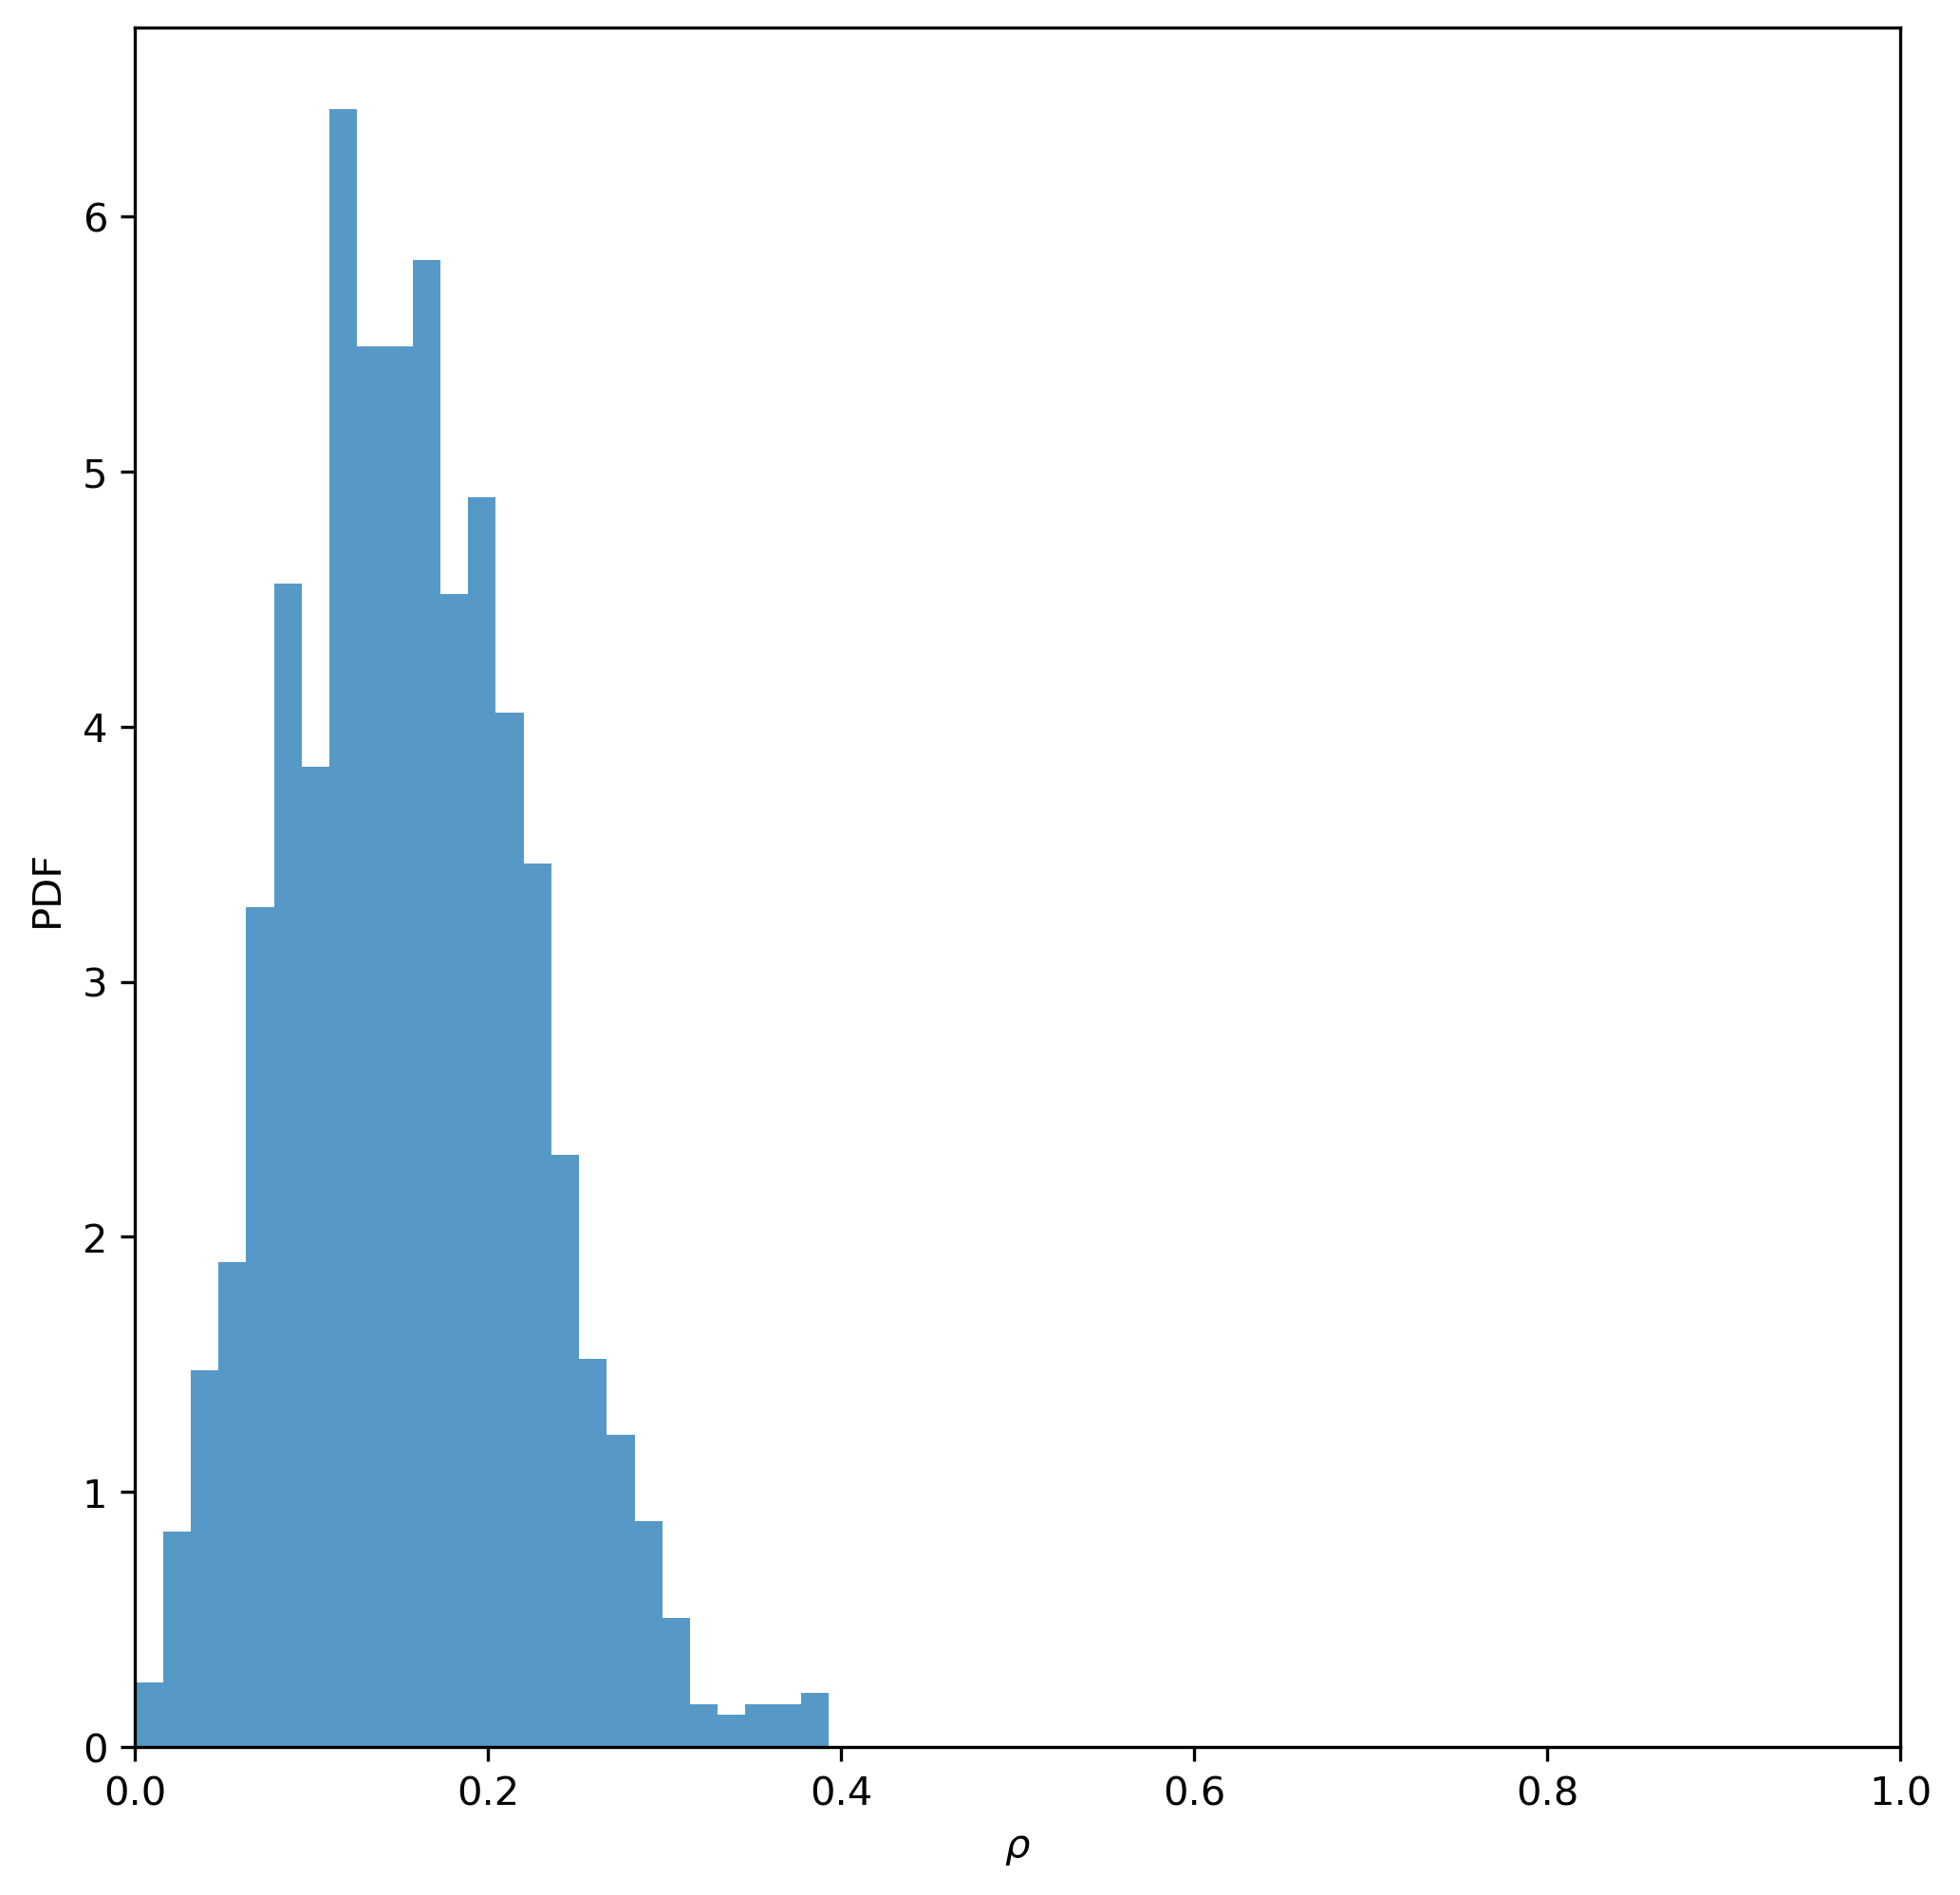

Number of nodes with not positive or negative annotation:  0
Validating p_bind value from binary labels:  0.15851975386738743


  5%|███▌                                                                          | 461/10000 [00:56<19:30,  8.15it/s]


Loops  462
Error margin:  [9.77195365e-06]


10434it [00:04, 2429.17it/s]


AUC:  0.5106315833653132
AUP:  0.16877178336751478
Transductive performance:
AUC:  0.5106315833653132
AUP:  0.16877178336751478


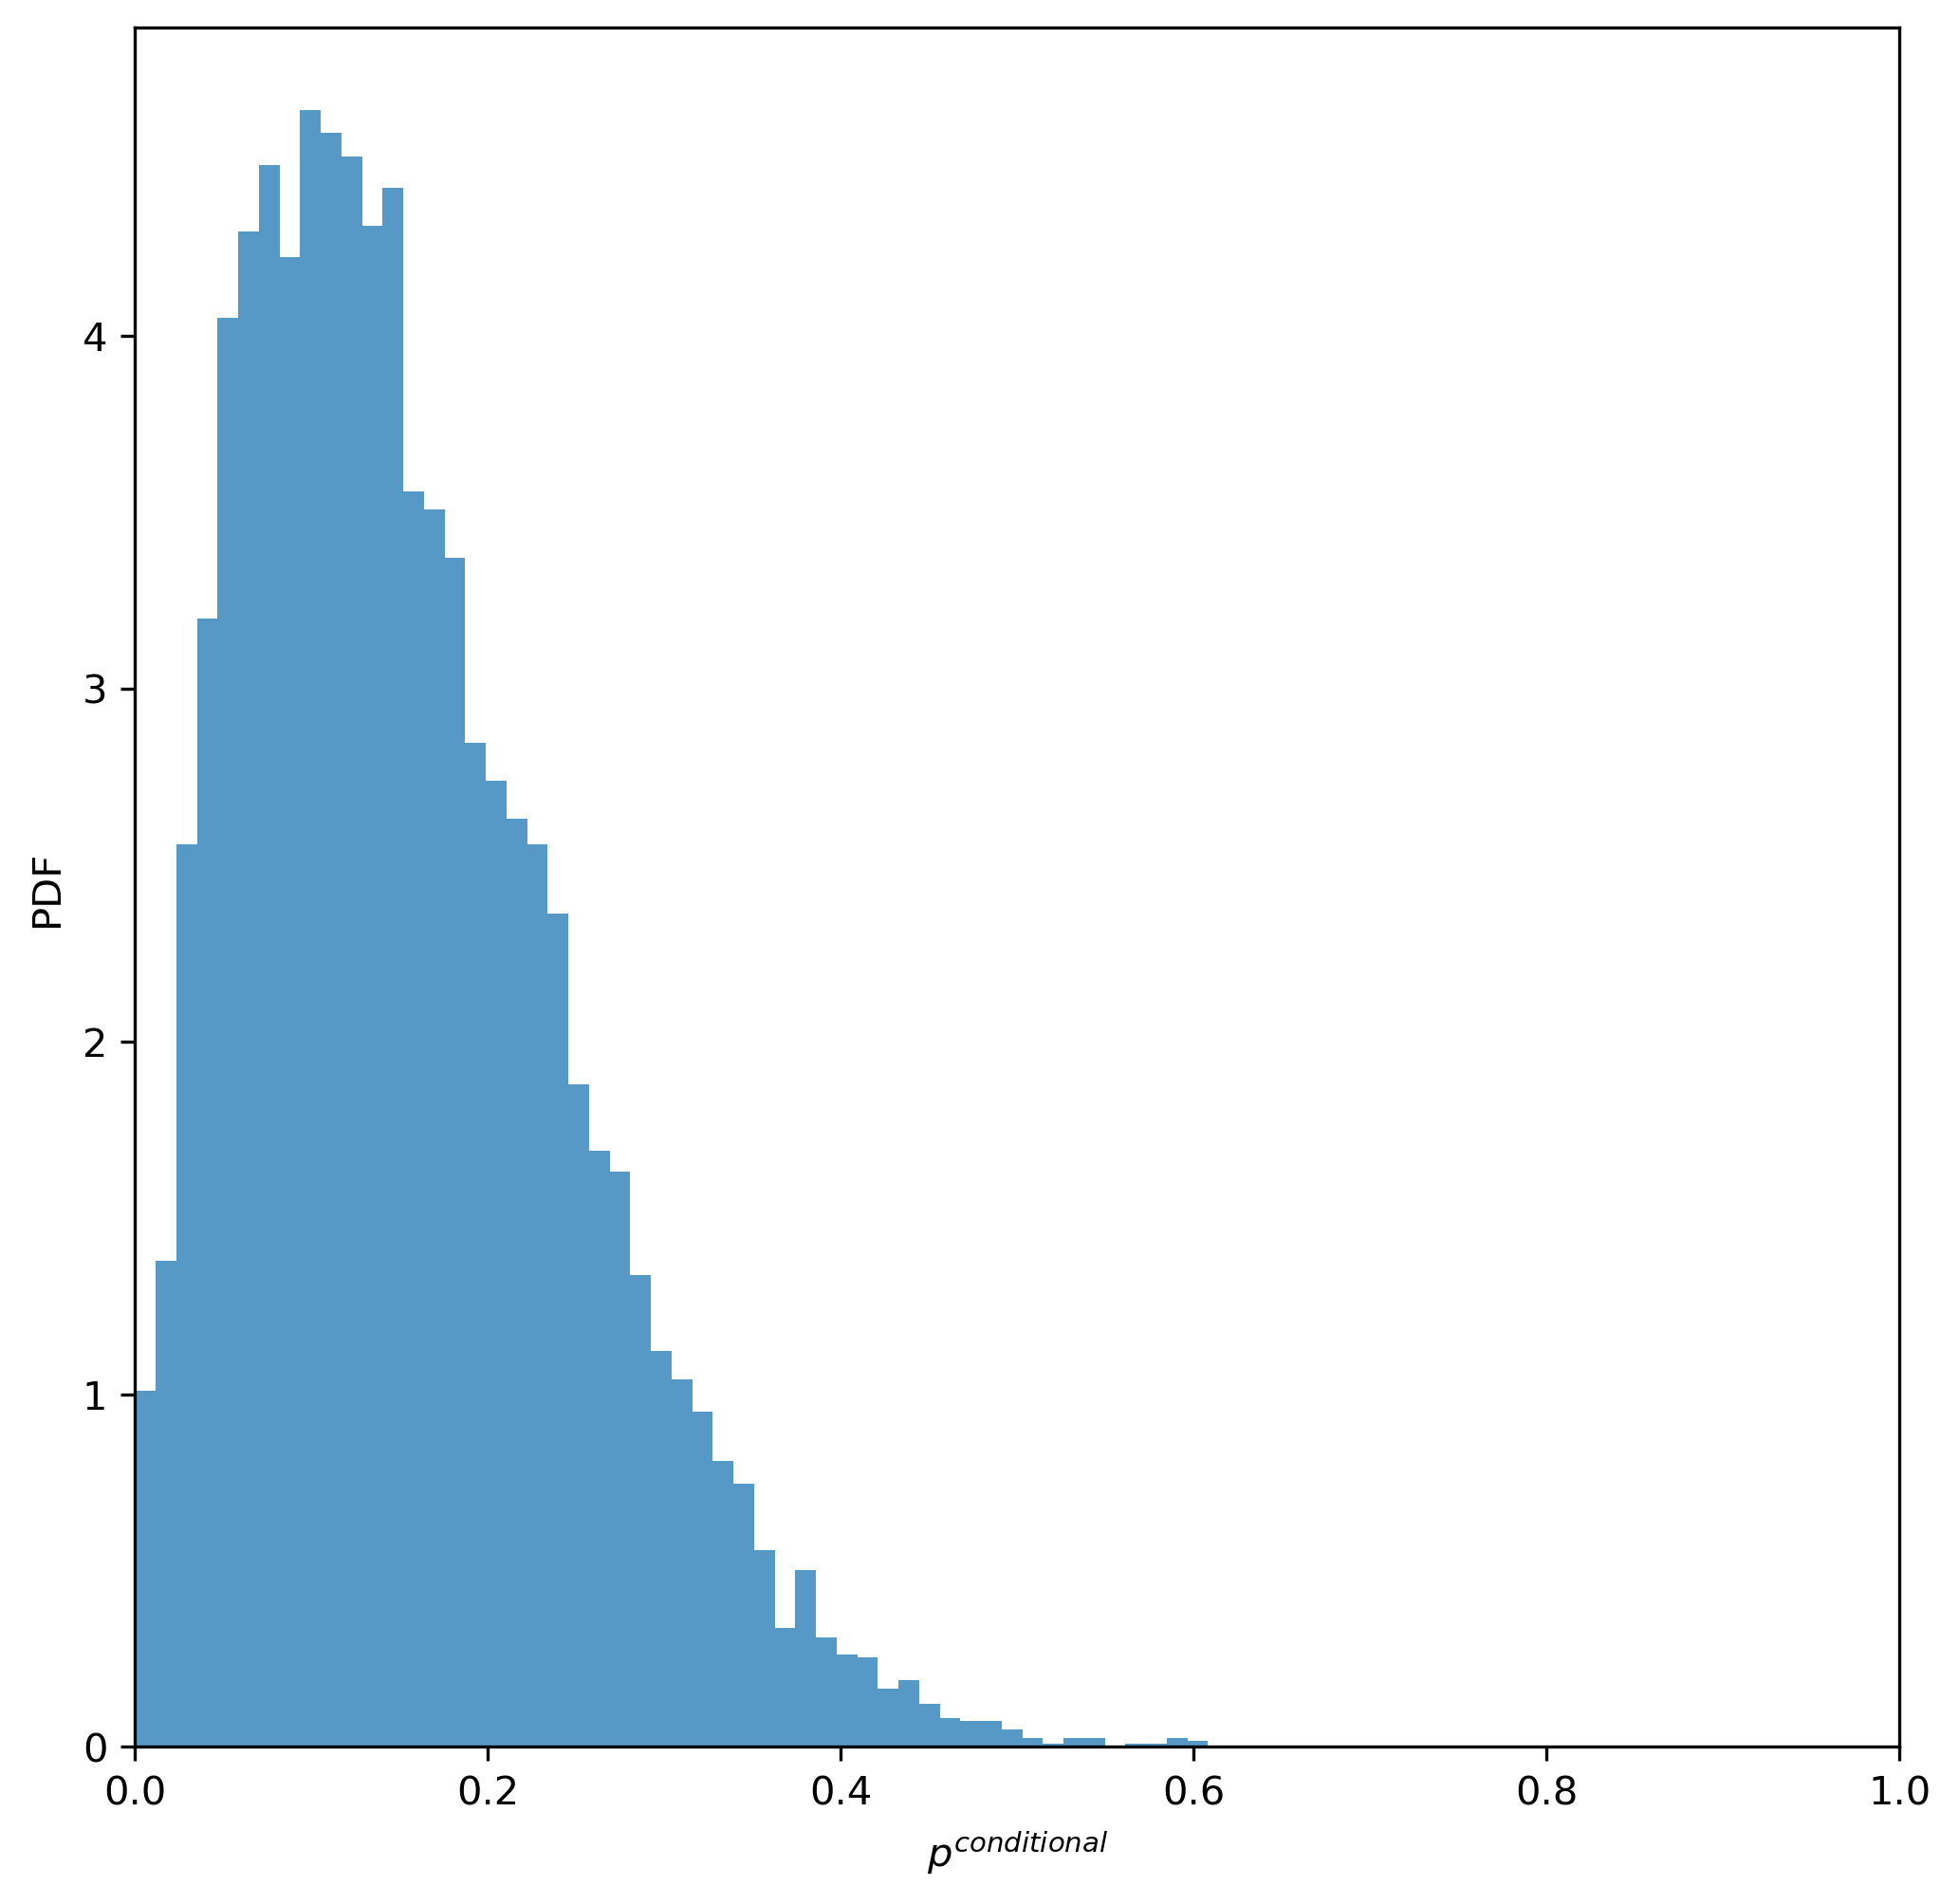

In [13]:
network_dataPois_shuffled = remove_correlation_run_configuration_model(network_dataPois, precision=10**(-5), loops=10000)